# Expore data

## Import & definitions

In [1]:
import os
import sys
from pathlib import Path
import re
import random
import time
import math
from datetime import timedelta
from datetime import timezone
from datetime import datetime
import json
import joblib
# Third Party
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
# from helpers.ocean_helpers import save_list
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import L1L2
# PLOT
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme()

# definitions
PAST_HISTORY = int(60 / 5) * 6 # 4 hours / 72*5min = 6 hours used to predict next values in future
FUTURE_TARGET = 12 + 3 # number of 5 min to predict  : 15
STEP = 1
BATCH_SIZE = 32
TRAIN_SPLIT_RATIO = 0.8 #0.9891 # 1-(60/5*24)/50977
MODE_TRAIN_AE = True # False
MODE_AUTO_SELECT = 1  #0 # 0: False, 1: True, 2: from disk

MODE_TRAIN_PREDICTOR = True
MODE_TRAIN_LSTM = False

# paths
path_data = "data"
path_save_df_feat = os.path.join(path_data, "df_features_05m.csv")

path_save_pred_vals = "data/pred_vals.csv"
path_save_auto_select = "data/list_auto_select.csv"

path_mdl_autoencoder =  os.path.join(path_data, "mdl_autoencoder")
path_mdl_encoder  =  os.path.join(path_data, "mdl_encoder")
path_mdl_predict_lstm  =  os.path.join(path_data, "mdl_predict_lstm")
path_mdl_predict_autoenc_lstm  =  os.path.join(
    path_data, "mdl_predict_autoenc_lstm")

path_scaler = os.path.join(path_data, "scaler.bin")
path_scaler_y = os.path.join(path_data, "scaler_y.bin")
path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")

In [2]:
PAST_HISTORY

72

In [3]:
print(60/5*24*2)
1-(60/5*24*2)/52981

576.0


0.9891281780260848

In [4]:
# helpers: save/load list
def save_list(list_: list, file_name: str):
    """Save a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    p.write_text(str(list_))
    
def load_list(file_name: str) -> list:
    """Load from a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    s = p.read_text()
    list_ = eval(s)
    return list_

In [5]:
def plot_train_history(history, title, saveFolder=None):
    """
    Plot train errors
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    fig = plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    ax = fig.gca()
    ax.set_xlabel("epoch[-]")
    if saveFolder is not None:
        title_clean = re.sub('[^-a-zA-Z0-9 \.]', ' ', title)
        plt.savefig(os.path.join(saveFolder, f"output_{title_clean}.jpg")) 
    plt.show()


def naming_plot(n_unit_enc, encoding_dim, dropout_autoenc):
    return f"TS {TRAIN_SPLIT_RATIO} - units {n_unit_enc} - enc_dim {encoding_dim} - drop {dropout_autoenc}"

## Load raw features

In [6]:
# load
df_feat_raw = pd.read_csv(path_save_df_feat)
df_feat_raw

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_2111/3998402900.py:2: DtypeWarning: Columns (118,119,120,121,122,123,124,134) have mixed types. Specify dtype option on import or set low_memory=False.
  df_feat_raw = pd.read_csv(path_save_df_feat)


Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
65162  1692079800000   1843.37   1843.60  1843.36    1843.54    425.3356   
65163  1692080100000   1843.55   1843.55  1843.32    1843.40    790.3452   
65164  1692080400000   1843.39   1843.67  1843.18    1843.22   2109.8583   
65165  1692080700000   1843.23   1843.23  1842.52    1842.52    857.4082   
65166  1692081000000   1842.53   1842.67  1842.49    1842.66    444.1000   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1753.297639       1752.753789   
1      2023-01-01 00:05:00       1753.297639       1752.753789   
2      2023-01-01 00:10:00       1753.297639       1752.753789   
3      2023-01-01 00:15:00       1753.297639       1752.753789   
4      2023-01-01 00:20:00       1753.297639       1752.753789   
...                    ...               ...               ...   
65162  2023-08-15 06:10:00       1844.482500       1845.380000   
65163  2023-08-15 06:15:00       1844.475000       1845.380000   
65164  2023-08-15 06:20:00       1844.417500       1845.380000   
65165  2023-08-15 06:25:00       1844.427500       1845.380000   
65166  2023-08-15 06:30:00       1844.382500       1845.380000   

       ichi_kijun_ETH  ...  keep  Actual_num  Consensus_num  Previous_num  \
0                 NaN  ...   NaN         NaN            NaN           NaN   
1                 NaN  ...   NaN         NaN            NaN           NaN   
2                 NaN  ...   NaN         NaN            NaN           NaN   
3                 NaN  ...   NaN         NaN            NaN           NaN   
4                 NaN  ...   NaN         NaN            NaN           NaN   
...               ...  ...   ...         ...            ...           ...   
65162        1843.190  ...   NaN         NaN            NaN           NaN   
65163        1843.190  ...   NaN         NaN            NaN           NaN   
65164        1843.065  ...   NaN         NaN            NaN           NaN   
65165        1842.985  ...   NaN         NaN            NaN           NaN   
65166        1842.985  ...   NaN         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   NaN         0.0               NaN         0.0      0.0   
1                   NaN         0.0               NaN         0.0      0.0   
2                   NaN         0.0               NaN         0.0      0.0   
3                   NaN         0.0               NaN         0.0      0.0   
4                   NaN         0.0               NaN         0.0      0.0   
...                 ...         ...               ...         ...      ...   
65162               NaN         0.0               NaN         0.0      0.0   
65163               NaN         0.0               NaN         0.0      0.0   
65164               NaN         0.0               NaN         0.0      0.0   
65165               NaN         0.0               NaN         0.0      0.0   
65166               NaN         0.0               NaN         0.0      0.0   

       date  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN  
...     ...  
65162   NaN  
65163   NaN  
65164   NaN  
65165   NaN  
65166   NaN  

[65167 rows x 135 columns]

### drop nan

In [7]:
def get_missing(df):
    nb_missing = df.isnull().sum()
    nb_missing = nb_missing.sort_values()
    nb_missing = nb_missing[nb_missing.values > 0]
    print("missing data : ")
    print(nb_missing)
    print("")
    print("on {} samples".format(df.shape[0]))
    return nb_missing

nb_missing = get_missing(df_feat_raw)

missing data : 
vwap_z_score_BTC            1
vwap_z_score_ETH            1
ichi_tenkan_BTC             8
ichi_tenkan_ETH             8
min_low_h_BTC              13
rsi_h_BTC                  13
max_high_h_ETH             13
min_low_h_ETH              13
rsi_h_ETH                  13
max_high_h_BTC             13
chop_h_BTC                 14
chop_h_ETH                 14
ichi_cloud_a_ETH           25
ichi_kijun_ETH             25
ichi_kijun_BTC             25
ichi_cloud_a_BTC           25
ichi_tenkan_day_BTC       215
ichi_tenkan_day_ETH       215
dxy                       264
rsi_d_ETH                 335
min_low_d_BTC             335
rsi_d_BTC                 335
max_high_d_ETH            335
min_low_d_ETH             335
max_high_d_BTC            335
chop_d_ETH                335
chop_d_BTC                335
ichi_kijun_day_ETH        623
ichi_cloud_a_day_ETH      623
ichi_kijun_day_BTC        623
ichi_cloud_a_day_BTC      623
fvx                       732
spx                     

#### Cheat Backward Filling

In [8]:
df_feat = df_feat_raw.copy()

In [9]:
df_feat = df_feat.bfill(axis ='rows')

In [10]:
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
65162  1692079800000   1843.37   1843.60  1843.36    1843.54    425.3356   
65163  1692080100000   1843.55   1843.55  1843.32    1843.40    790.3452   
65164  1692080400000   1843.39   1843.67  1843.18    1843.22   2109.8583   
65165  1692080700000   1843.23   1843.23  1842.52    1842.52    857.4082   
65166  1692081000000   1842.53   1842.67  1842.49    1842.66    444.1000   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1753.297639       1752.753789   
1      2023-01-01 00:05:00       1753.297639       1752.753789   
2      2023-01-01 00:10:00       1753.297639       1752.753789   
3      2023-01-01 00:15:00       1753.297639       1752.753789   
4      2023-01-01 00:20:00       1753.297639       1752.753789   
...                    ...               ...               ...   
65162  2023-08-15 06:10:00       1844.482500       1845.380000   
65163  2023-08-15 06:15:00       1844.475000       1845.380000   
65164  2023-08-15 06:20:00       1844.417500       1845.380000   
65165  2023-08-15 06:25:00       1844.427500       1845.380000   
65166  2023-08-15 06:30:00       1844.382500       1845.380000   

       ichi_kijun_ETH  ...  keep  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...   1.0         0.0            0.0           0.0   
1            1194.710  ...   1.0         0.0            0.0           0.0   
2            1194.710  ...   1.0         0.0            0.0           0.0   
3            1194.710  ...   1.0         0.0            0.0           0.0   
4            1194.710  ...   1.0         0.0            0.0           0.0   
...               ...  ...   ...         ...            ...           ...   
65162        1843.190  ...   NaN         NaN            NaN           NaN   
65163        1843.190  ...   NaN         NaN            NaN           NaN   
65164        1843.065  ...   NaN         NaN            NaN           NaN   
65165        1842.985  ...   NaN         NaN            NaN           NaN   
65166        1842.985  ...   NaN         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
65162               NaN         0.0               NaN         0.0      0.0   
65163               NaN         0.0               NaN         0.0      0.0   
65164               NaN         0.0               NaN         0.0      0.0   
65165               NaN         0.0               NaN         0.0      0.0   
65166               NaN         0.0               NaN         0.0      0.0   

                      date  
0      2023-01-02 05:00:00  
1      2023-01-02 05:00:00  
2      2023-01-02 05:00:00  
3      2023-01-02 05:00:00  
4      2023-01-02 05:00:00  
...                    ...  
65162                  NaN  
65163                  NaN  
65164                  NaN  
65165                  NaN  
65166                  NaN  

[65167 rows x 135 columns]

In [11]:
nb_missing = get_missing(df_feat)

missing data : 
Consensus_num       1074
delta_event_real    1074
delta_event_pred    1074
Previous_num        1074
Actual_num          1074
Event               1074
Date                1074
Previous            1074
Consensus           1074
Actual              1074
Country             1074
Time (ET)           1074
keep                1074
date                1074
dtype: int64

on 65167 samples


In [12]:
#print(df_feat.shape)
#df_feat = df_feat.dropna(subset=["Consensus_num"]).copy()
#df_feat.reset_index(inplace=True)
#df_feat.shape

## Features Selection

### Proportional to the Price

In [13]:
list_col = df_feat.columns.to_list()
list_col

['Time',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'fear_greed',
 'fear_greed_class',
 'fvx',
 'spx',
 'dxy',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH',
 'hour',
 'hour_cos',
 'hour_sin',
 'weekday',
 'weekday_cos',
 'weekday_sin',
 'day',
 'days_in_month',
 'day_ratio',
 'da

In [14]:
list_col_ETH = [col for col in list_col if re.search("_ETH", col) is not None]
list_col_ETH

['Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH']

In [15]:
df_feat[list_col_ETH]

Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0       1196.13   1196.32  1195.65    1196.32    334.5592   
1       1196.31   1196.69  1194.90    1195.38    682.3876   
2       1195.38   1195.81  1194.55    1194.55    228.9387   
3       1194.55   1195.98  1194.31    1195.98    601.8903   
4       1195.98   1196.37  1195.97    1196.06    144.8048   
...         ...       ...      ...        ...         ...   
65162   1843.37   1843.60  1843.36    1843.54    425.3356   
65163   1843.55   1843.55  1843.32    1843.40    790.3452   
65164   1843.39   1843.67  1843.18    1843.22   2109.8583   
65165   1843.23   1843.23  1842.52    1842.52    857.4082   
65166   1842.53   1842.67  1842.49    1842.66    444.1000   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1753.297639       1752.753789   
1      2023-01-01 00:05:00       1753.297639       1752.753789   
2      2023-01-01 00:10:00       1753.297639       1752.753789   
3      2023-01-01 00:15:00       1753.297639       1752.753789   
4      2023-01-01 00:20:00       1753.297639       1752.753789   
...                    ...               ...               ...   
65162  2023-08-15 06:10:00       1844.482500       1845.380000   
65163  2023-08-15 06:15:00       1844.475000       1845.380000   
65164  2023-08-15 06:20:00       1844.417500       1845.380000   
65165  2023-08-15 06:25:00       1844.427500       1845.380000   
65166  2023-08-15 06:30:00       1844.382500       1845.380000   

       ichi_kijun_ETH  ichi_tenkan_ETH  ...   vwap_m_ETH  vwap_3m_ETH  \
0            1194.710         1194.710  ...  1196.096667  1196.096667   
1            1194.710         1194.710  ...  1195.801420  1195.801420   
2            1194.710         1194.710  ...  1195.648641  1195.648641   
3            1194.710         1194.710  ...  1195.575250  1195.575250   
4            1194.710         1194.710  ...  1195.615807  1195.615807   
...               ...              ...  ...          ...          ...   
65162        1843.190         1842.535  ...  1847.044725  1886.592760   
65163        1843.190         1842.535  ...  1847.041911  1886.586689   
65164        1843.065         1842.570  ...  1847.036990  1886.575313   
65165        1842.985         1842.570  ...  1847.034793  1886.567930   
65166        1842.985         1842.675  ...  1847.031154  1886.562493   

       vwap_6m_ETH   vwap_y_ETH  vwap_all_ETH  vwap_z_score_ETH  nupl_ETH  \
0      1196.096667  1196.096667   1196.096667         -0.634018  0.000187   
1      1195.801420  1195.801420   1195.801420         -0.634018 -0.000353   
2      1195.648641  1195.648641   1195.648641         -1.240604 -0.000920   
3      1195.575250  1195.575250   1195.575250          0.521593  0.000338   
4      1195.615807  1195.615807   1195.615807          0.626856  0.000371   
...            ...          ...           ...               ...       ...   
65162  1851.304926  1865.629256   1733.458283          0.622080  0.059712   
65163  1851.305074  1865.623583   1733.459212          0.621287  0.059640   
65164  1851.305146  1865.612324   1733.461692          0.620260  0.059547   
65165  1851.305224  1865.605970   1733.462694          0.616302  0.059189   
65166  1851.305434  1865.599303   1733.463212          0.617093  0.059260   

         supply_ETH  act_addr_ETH  market_dom_ETH  
0      1.205254e+08      522461.0       17.889820  
1      1.205254e+08      522461.0       17.889820  
2      1.205254e+08      522461.0       17.889820  
3      1.205254e+08      522461.0       17.889820  
4      1.205254e+08      522461.0       17.889820  
...             ...           ...             ...  
65162  1.201444e+08      452926.0       18.950225  
65163  1.201444e+08      452926.0       18.950225  
65164  1.201444e+08      452926.0       18.950225  
65165  1.201444e+08      452926.0       18.950225  
65166  1.201444e+08      452926.0       18.950225  

[65167 rows x 46 columns]

In [16]:
list_price_dep_ETH = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
    'ichi_cloud_a_ETH',
    'ichi_cloud_b_ETH',
    'ichi_kijun_ETH',
    'ichi_tenkan_ETH',
    'ichi_cloud_a_day_ETH',
    'ichi_cloud_b_day_ETH',
    'ichi_kijun_day_ETH',
    'ichi_tenkan_day_ETH',
    'ichi_cloud_a_week_ETH',
    'ichi_cloud_b_week_ETH',
    'ichi_kijun_week_ETH',
    'ichi_tenkan_week_ETH',
    'max_high_h_ETH',
    'min_low_h_ETH',
    'max_high_d_ETH',
    'min_low_d_ETH',
    'max_high_w_ETH',
    'min_low_w_ETH',
    'vwap_h_ETH',
    'vwap_d_ETH',
    'vwap_w_ETH',
    'vwap_m_ETH',
    'vwap_3m_ETH',
    'vwap_6m_ETH',
    'vwap_y_ETH',
    'vwap_all_ETH',
]


#    'max_high_h_ETH',
#    'ichi_tenkan_week_ETH',

In [17]:
list_col_BTC = [col for col in list_col if re.search("_BTC", col) is not None]
list_col_BTC

['Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'Volume_BTC',
 'date_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'rsi_h_BTC',
 'rsi_d_BTC',
 'rsi_w_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'atr_h_BTC',
 'chop_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'atr_d_BTC',
 'chop_d_BTC',
 'max_high_w_BTC',
 'min_low_w_BTC',
 'atr_w_BTC',
 'chop_w_BTC',
 'vwap_h_BTC',
 'vwap_d_BTC',
 'vwap_w_BTC',
 'vwap_m_BTC',
 'vwap_3m_BTC',
 'vwap_6m_BTC',
 'vwap_y_BTC',
 'vwap_all_BTC',
 'vwap_z_score_BTC',
 'nupl_BTC',
 'supply_BTC',
 'act_addr_BTC',
 'market_dom_BTC']

In [18]:
list_price_dep_BTC = [
    'Open_BTC',
    'High_BTC',
    'Low_BTC',
    'Close_BTC',
    'ichi_cloud_a_BTC',
    'ichi_cloud_b_BTC',
    'ichi_kijun_BTC',
    'ichi_tenkan_BTC',
    'ichi_cloud_a_day_BTC',
    'ichi_cloud_b_day_BTC',
    'ichi_kijun_day_BTC',
    'ichi_tenkan_day_BTC',
    'ichi_cloud_a_week_BTC',
    'ichi_cloud_b_week_BTC',
    'ichi_kijun_week_BTC',
    'ichi_tenkan_week_BTC',
    'max_high_h_BTC',
    'min_low_h_BTC',
    'max_high_d_BTC',
    'min_low_d_BTC',
    'max_high_w_BTC',
    'min_low_w_BTC',
    'vwap_h_BTC',
    'vwap_d_BTC',
    'vwap_w_BTC',
    'vwap_m_BTC',
    'vwap_3m_BTC',
    'vwap_6m_BTC',
    'vwap_y_BTC',
    'vwap_all_BTC',
    'vwap_z_score_BTC',
]

In [19]:
list_col_BNB = [col for col in list_col if re.search("_BNB", col) is not None]
list_col_BNB

['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB', 'Volume_BNB', 'date_BNB']

In [20]:
list_price_dep_BNB = ['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB']

### Not proportional to the Price 

In [21]:
set(list_col) - set(list_price_dep_ETH) - set(list_price_dep_BTC) - set(list_price_dep_BNB)

{'Actual',
 'Actual_num',
 'Consensus',
 'Consensus_num',
 'Country',
 'Date',
 'Event',
 'Previous',
 'Previous_num',
 'Time',
 'Time (ET)',
 'Volume_BNB',
 'Volume_BTC',
 'Volume_ETH',
 'act_addr_BTC',
 'act_addr_ETH',
 'atr_d_BTC',
 'atr_d_ETH',
 'atr_h_BTC',
 'atr_h_ETH',
 'atr_w_BTC',
 'atr_w_ETH',
 'chop_d_BTC',
 'chop_d_ETH',
 'chop_h_BTC',
 'chop_h_ETH',
 'chop_w_BTC',
 'chop_w_ETH',
 'date',
 'date_BNB',
 'date_BTC',
 'date_ETH',
 'day',
 'day_in_month_cos',
 'day_in_month_sin',
 'day_off',
 'day_ratio',
 'days_in_month',
 'delta_event_pred',
 'delta_event_real',
 'dxy',
 'event_pred',
 'event_real',
 'fear_greed',
 'fear_greed_class',
 'fvx',
 'hour',
 'hour_cos',
 'hour_sin',
 'keep',
 'market_dom_BTC',
 'market_dom_ETH',
 'month',
 'month_cos',
 'month_sin',
 'nupl_BTC',
 'nupl_ETH',
 'rsi_d_BTC',
 'rsi_d_ETH',
 'rsi_h_BTC',
 'rsi_h_ETH',
 'rsi_w_BTC',
 'rsi_w_ETH',
 'spx',
 'supply_BTC',
 'supply_ETH',
 'vwap_z_score_ETH',
 'weekday',
 'weekday_cos',
 'weekday_sin'}

In [22]:
list_col_other = [
    'Volume_BNB',
    'Volume_BTC',
    'Volume_ETH',
    'chop_d_BTC',
    'chop_d_ETH',
    'chop_h_BTC',
    'chop_h_ETH',
    'chop_w_BTC',
    'chop_w_ETH',
    'rsi_d_BTC',
    'rsi_d_ETH',
    'rsi_h_BTC',
    'rsi_h_ETH',
    'rsi_w_BTC',
    'rsi_w_ETH',
    'vwap_z_score_ETH',
    'dxy',
    'spx',
    'fvx',
    'act_addr_BTC',
    'act_addr_ETH',
    'market_dom_BTC',
    'market_dom_ETH',
    'nupl_BTC',
    'nupl_ETH',
    'fear_greed',
    'supply_BTC',
    'supply_ETH',
    'hour_cos',
    'hour_sin',
    'weekday_cos',
    'weekday_sin',
    'day_in_month_cos',
    'day_in_month_sin',
    'month_cos',
    'month_sin',
    'day_off',
    'event_pred',
    'event_real',
]

### Final selection

In [23]:
list_col_select_simple = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
]

list_col_select_global = (
    list_price_dep_ETH +
    list_price_dep_BTC +
    list_price_dep_BNB +    
    list_col_other
)


# selection
list_col_select = list_col_select_global

# only col in df_feat
list_col_select = [feat for feat in list_col_select if feat in df_feat.columns]
print("num features : ", len(list_col_select))

num features :  104


In [24]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

## Features preparation

df_feat [selected features]   
--> X_train_raw, X_test_raw, y_train_raw, y_test_raw  
--> X_train (with prices ratio of ETH Close price at last lag) <-- used by autoencoder 


X [nb samples, nb lags, nb features]


In [25]:
df_feat.shape[0]

65167

In [26]:
TRAIN_SPLIT = round(TRAIN_SPLIT_RATIO * df_feat.shape[0])
TRAIN_SPLIT

52134

In [27]:
bol_train = [True if I <= TRAIN_SPLIT else False \
                       for I in range(df_feat.shape[0])]
df_feat["train"] = bol_train
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
65162  1692079800000   1843.37   1843.60  1843.36    1843.54    425.3356   
65163  1692080100000   1843.55   1843.55  1843.32    1843.40    790.3452   
65164  1692080400000   1843.39   1843.67  1843.18    1843.22   2109.8583   
65165  1692080700000   1843.23   1843.23  1842.52    1842.52    857.4082   
65166  1692081000000   1842.53   1842.67  1842.49    1842.66    444.1000   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1753.297639       1752.753789   
1      2023-01-01 00:05:00       1753.297639       1752.753789   
2      2023-01-01 00:10:00       1753.297639       1752.753789   
3      2023-01-01 00:15:00       1753.297639       1752.753789   
4      2023-01-01 00:20:00       1753.297639       1752.753789   
...                    ...               ...               ...   
65162  2023-08-15 06:10:00       1844.482500       1845.380000   
65163  2023-08-15 06:15:00       1844.475000       1845.380000   
65164  2023-08-15 06:20:00       1844.417500       1845.380000   
65165  2023-08-15 06:25:00       1844.427500       1845.380000   
65166  2023-08-15 06:30:00       1844.382500       1845.380000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...         0.0            0.0           0.0   
1            1194.710  ...         0.0            0.0           0.0   
2            1194.710  ...         0.0            0.0           0.0   
3            1194.710  ...         0.0            0.0           0.0   
4            1194.710  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
65162        1843.190  ...         NaN            NaN           NaN   
65163        1843.190  ...         NaN            NaN           NaN   
65164        1843.065  ...         NaN            NaN           NaN   
65165        1842.985  ...         NaN            NaN           NaN   
65166        1842.985  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
65162               NaN         0.0               NaN         0.0      0.0   
65163               NaN         0.0               NaN         0.0      0.0   
65164               NaN         0.0               NaN         0.0      0.0   
65165               NaN         0.0               NaN         0.0      0.0   
65166               NaN         0.0               NaN         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
65162                  NaN  False  
65163                  NaN  False  
65164                  NaN  False  
65165                  NaN  False  
65166                  NaN  False  

[65167 rows x 136 columns]

In [28]:
df_feat[df_feat["train"] == True]

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
52130  1688170200000   1937.07   1938.42  1930.01    1933.46   1455.2039   
52131  1688170500000   1933.47   1935.20  1932.33    1934.02    864.3585   
52132  1688170800000   1934.01   1935.93  1933.00    1935.73    603.7555   
52133  1688171100000   1935.74   1940.80  1934.00    1939.59   1640.2021   
52134  1688171400000   1939.58   1940.12  1937.74    1937.74   4820.1384   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1753.297639       1752.753789   
1      2023-01-01 00:05:00       1753.297639       1752.753789   
2      2023-01-01 00:10:00       1753.297639       1752.753789   
3      2023-01-01 00:15:00       1753.297639       1752.753789   
4      2023-01-01 00:20:00       1753.297639       1752.753789   
...                    ...               ...               ...   
52130  2023-07-01 00:10:00       1927.612500       1931.575000   
52131  2023-07-01 00:15:00       1930.040000       1928.775000   
52132  2023-07-01 00:20:00       1930.350000       1928.775000   
52133  2023-07-01 00:25:00       1930.350000       1928.775000   
52134  2023-07-01 00:30:00       1930.350000       1928.775000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...         0.0            0.0           0.0   
1            1194.710  ...         0.0            0.0           0.0   
2            1194.710  ...         0.0            0.0           0.0   
3            1194.710  ...         0.0            0.0           0.0   
4            1194.710  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
52130        1936.845  ...         0.0            0.0           0.0   
52131        1936.845  ...         0.0            0.0           0.0   
52132        1936.845  ...         0.0            0.0           0.0   
52133        1936.845  ...         0.0            0.0           0.0   
52134        1936.845  ...         0.0            0.0           0.0   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
52130               0.0         0.0               0.0         0.0      0.0   
52131               0.0         0.0               0.0         0.0      0.0   
52132               0.0         0.0               0.0         0.0      0.0   
52133               0.0         0.0               0.0         0.0      0.0   
52134               0.0         0.0               0.0         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
52130  2023-07-03 05:00:00   True  
52131  2023-07-03 05:00:00   True  
52132  2023-07-03 05:00:00   True  
52133  2023-07-03 05:00:00   True  
52134  2023-07-03 05:00:00   True  

[52135 rows x 136 columns]

In [29]:
df_feat[df_feat["train"] == False]

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
52135  1688171700000   1937.74   1941.38  1935.77    1941.38   3266.1048   
52136  1688172000000   1941.37   1944.56  1940.32    1943.18   2489.0068   
52137  1688172300000   1943.17   1943.18  1937.50    1938.61   1613.3710   
52138  1688172600000   1938.60   1938.61  1934.90    1935.82    921.5095   
52139  1688172900000   1935.81   1936.00  1933.50    1934.11    559.9021   
...              ...       ...       ...      ...        ...         ...   
65162  1692079800000   1843.37   1843.60  1843.36    1843.54    425.3356   
65163  1692080100000   1843.55   1843.55  1843.32    1843.40    790.3452   
65164  1692080400000   1843.39   1843.67  1843.18    1843.22   2109.8583   
65165  1692080700000   1843.23   1843.23  1842.52    1842.52    857.4082   
65166  1692081000000   1842.53   1842.67  1842.49    1842.66    444.1000   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
52135  2023-07-01 00:35:00         1930.3500          1925.865   
52136  2023-07-01 00:40:00         1930.5525          1926.025   
52137  2023-07-01 00:45:00         1932.1600          1927.480   
52138  2023-07-01 00:50:00         1932.5525          1927.480   
52139  2023-07-01 00:55:00         1932.8875          1927.480   
...                    ...               ...               ...   
65162  2023-08-15 06:10:00         1844.4825          1845.380   
65163  2023-08-15 06:15:00         1844.4750          1845.380   
65164  2023-08-15 06:20:00         1844.4175          1845.380   
65165  2023-08-15 06:25:00         1844.4275          1845.380   
65166  2023-08-15 06:30:00         1844.3825          1845.380   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
52135        1936.845  ...         0.0            0.0           0.0   
52136        1937.285  ...         0.0            0.0           0.0   
52137        1937.285  ...         0.0            0.0           0.0   
52138        1937.285  ...         0.0            0.0           0.0   
52139        1937.285  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
65162        1843.190  ...         NaN            NaN           NaN   
65163        1843.190  ...         NaN            NaN           NaN   
65164        1843.065  ...         NaN            NaN           NaN   
65165        1842.985  ...         NaN            NaN           NaN   
65166        1842.985  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
52135               0.0         0.0               0.0         0.0      0.0   
52136               0.0         0.0               0.0         0.0      0.0   
52137               0.0         0.0               0.0         0.0      0.0   
52138               0.0         0.0               0.0         0.0      0.0   
52139               0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
65162               NaN         0.0               NaN         0.0      0.0   
65163               NaN         0.0               NaN         0.0      0.0   
65164               NaN         0.0               NaN         0.0      0.0   
65165               NaN         0.0               NaN         0.0      0.0   
65166               NaN         0.0               NaN         0.0      0.0   

                      date  train  
52135  2023-07-03 05:00:00  False  
52136  2023-07-03 05:00:00  False  
52137  2023-07-03 05:00:00  False  
52138  2023-07-03 05:00:00  False  
52139  2023-07-03 05:00:00  False  
...                    ...    ...  
65162                  NaN  False  
65163                  NaN  False  
65164                  NaN  False  
65165                  NaN  False  
65166                  NaN  False  

[13032 rows x 136 columns]

In [30]:
def gen_sequence(id_df, seq_length, len_pred, seq_cols, i_price_dep=None):

    data_matrix = id_df[seq_cols].values # data of selected col
    num_elements = data_matrix.shape[0] # nb samples

    for start, stop in zip(
            range(0, num_elements - seq_length - len_pred), 
            range(seq_length, num_elements - len_pred)
        ):
            out_matrix = data_matrix[start:stop, :].copy()
            if i_price_dep is not None:
                out_matrix[:, i_price_dep] = (
                    out_matrix[:, i_price_dep] / out_matrix[-1, 0]
                )
            yield out_matrix

def gen_labels(id_df, seq_length, len_pred, label, divide_price=False):

    data_matrix = id_df[label].values 
    num_elements = data_matrix.shape[0]

    for start, stop in zip(
            range(seq_length, num_elements - len_pred), 
            range(seq_length + len_pred, num_elements)
        ):
        out_matrix = data_matrix[start:stop, :].copy()
        if divide_price:
            out_matrix = out_matrix / data_matrix[start-1, 0]
        yield np.swapaxes(out_matrix,0,1).squeeze()

In [31]:
x = np.array([[1,2,3]])
x = np.swapaxes(x,0,1)
x = np.swapaxes(x,0,1).squeeze()
x

array([1, 2, 3])

In [32]:
i_col_price_dep = [
    (
        (col in list_price_dep_ETH) 
        or (col in list_price_dep_BTC) 
        or (col in list_price_dep_BNB)
    ) 
    for col in list_col_select ]

In [33]:
X_train, X_test = [], []
y_train, y_test = [], []

for is_train, _df in df_feat.groupby("train"):

    for seq in gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        i_col_price_dep
        ):
            if is_train:
                X_train.append(seq)
            else:
                X_test.append(seq)
    
    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH'], divide_price=True):

        if is_train:
            y_train.append(seq_y)
        else:
            y_test.append(seq_y)    

X_train = np.asarray(X_train)
y_train = np.array(y_train)
X_test = np.asarray(X_test)
y_test = np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(52048, 72, 104) (52048, 15)
(12945, 72, 104) (12945, 15)


In [34]:
X_train

array([[[1.00149011, 1.00133106, 1.00149011, ..., 0.        ,
         0.        , 0.        ],
        [1.0007032 , 1.00148174, 1.00179986, ..., 0.        ,
         0.        , 0.        ],
        [1.00000837, 1.0007032 , 1.00106317, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.99983257, 0.99962329, 0.99984094, ..., 0.        ,
         0.        , 0.        ],
        [0.99977397, 0.99984094, 0.99987443, ..., 0.        ,
         0.        , 0.        ],
        [1.        , 0.99978234, 1.00010883, ..., 0.        ,
         0.        , 0.        ]],

       [[1.00024266, 1.00102084, 1.00133881, ..., 0.        ,
         0.        , 0.        ],
        [0.99954815, 1.00024266, 1.00060247, ..., 0.        ,
         0.        , 0.        ],
        [1.00074471, 0.99954815, 1.00074471, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.99931386, 0.9993808 , 0.99941427, ..., 0.        ,
         0.        , 0.        ],
        [0.9

In [35]:
seq_y

array([0.99991203, 1.00168172, 1.00199736, 1.00392745, 1.00111252,
       1.00123671, 1.00032599, 1.00085897, 1.00064164, 1.00178003,
       1.0023337 , 1.00047088, 1.00076065, 1.00164549, 1.00364286])

In [36]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [0.99979294, 1.00039342, 1.00030542, ..., 1.00272804, 1.00086448,
        1.00115437],
       [1.0006006 , 1.00051258, 1.00228333, ..., 1.00107177, 1.00136171,
        1.00224709],
       [0.99991203, 1.00168172, 1.00199736, ..., 1.00076065, 1.00164549,
        1.00364286]])

In [37]:
seq_y

array([0.99991203, 1.00168172, 1.00199736, 1.00392745, 1.00111252,
       1.00123671, 1.00032599, 1.00085897, 1.00064164, 1.00178003,
       1.0023337 , 1.00047088, 1.00076065, 1.00164549, 1.00364286])

In [38]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [0.99979294, 1.00039342, 1.00030542, ..., 1.00272804, 1.00086448,
        1.00115437],
       [1.0006006 , 1.00051258, 1.00228333, ..., 1.00107177, 1.00136171,
        1.00224709],
       [0.99991203, 1.00168172, 1.00199736, ..., 1.00076065, 1.00164549,
        1.00364286]])

In [39]:
df_feat["Close_ETH"].iloc[PAST_HISTORY] / df_feat["Close_ETH"].iloc[PAST_HISTORY-1] == y_train[0,0]

True

In [40]:
X_train.shape

(52048, 72, 104)

In [41]:
X_train_raw, X_test_raw = [], []
y_train_raw, y_test_raw = [], []

for is_train, _df in df_feat.groupby("train"):

    for seq in gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        ):
            if is_train:
                X_train_raw.append(seq)
            else:
                X_test_raw.append(seq)
    
    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH']):

        if is_train:
            y_train_raw.append(seq_y)
        else:
            y_test_raw.append(seq_y)    

X_train_raw = np.asarray(X_train_raw)
y_train_raw = np.array(y_train_raw)
X_test_raw = np.asarray(X_test_raw)
y_test_raw = np.array(y_test_raw)

print(X_train_raw.shape, y_train_raw.shape)
print(X_test_raw.shape, y_test_raw.shape)

(52048, 72, 104) (52048, 15)
(12945, 72, 104) (12945, 15)


## Standardization

In [42]:
if MODE_TRAIN_AE:
    scaler = StandardScaler()
    X_train_sca = scaler.fit_transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
    X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)
    joblib.dump(scaler, path_scaler)
    
    scaler_y = StandardScaler()
    y_train_sca = scaler_y.fit_transform(y_train.ravel().reshape(-1, 1)).reshape(y_train.shape)
    y_test_sca = scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)
    joblib.dump(scaler_y, path_scaler_y)
else:
    print("Load standardization from disk...")
    scaler = joblib.load(path_scaler)
    X_train_sca = scaler.transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
    X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)

    scaler_y =  joblib.load(path_scaler_y)
    y_train_sca = scaler_y.transform(y_train.ravel().reshape(-1, 1)).reshape(y_train.shape)
    y_test_sca = scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)

In [43]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [0.99979294, 1.00039342, 1.00030542, ..., 1.00272804, 1.00086448,
        1.00115437],
       [1.0006006 , 1.00051258, 1.00228333, ..., 1.00107177, 1.00136171,
        1.00224709],
       [0.99991203, 1.00168172, 1.00199736, ..., 1.00076065, 1.00164549,
        1.00364286]])

In [44]:
np.mean(y_train_sca)

1.3031786259120535e-14

In [45]:
np.std(y_train_sca)

1.0

In [46]:
np.mean(y_test_sca)

-0.023927268361950284

In [47]:
np.std(y_test_sca)

0.545430143545489

### Check unscaling

In [48]:
df_feat[list_col_select].head(10)

Close_ETH  Open_ETH  High_ETH  Low_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0    1196.32   1196.13   1196.32  1195.65       1753.297639       1752.753789   
1    1195.38   1196.31   1196.69  1194.90       1753.297639       1752.753789   
2    1194.55   1195.38   1195.81  1194.55       1753.297639       1752.753789   
3    1195.98   1194.55   1195.98  1194.31       1753.297639       1752.753789   
4    1196.06   1195.98   1196.37  1195.97       1753.297639       1752.753789   
5    1196.61   1196.06   1196.70  1196.06       1753.297639       1752.753789   
6    1194.36   1196.62   1196.62  1193.72       1753.297639       1752.753789   
7    1194.22   1194.37   1194.43  1192.72       1753.297639       1752.753789   
8    1193.64   1194.22   1194.22  1193.02       1753.297639       1752.753789   
9    1194.64   1193.64   1195.06  1193.63       1753.297639       1752.753789   

   ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0         1194.71          1194.71           1756.430057   
1         1194.71          1194.71           1756.430057   
2         1194.71          1194.71           1756.430057   
3         1194.71          1194.71           1756.430057   
4         1194.71          1194.71           1756.430057   
5         1194.71          1194.71           1756.430057   
6         1194.71          1194.71           1756.430057   
7         1194.71          1194.71           1756.430057   
8         1194.71          1194.71           1756.430057   
9         1194.71          1194.71           1756.430057   

   ichi_cloud_b_day_ETH  ...  hour_sin  weekday_cos  weekday_sin  \
0           1747.191967  ...       0.0      0.62349    -0.781831   
1           1747.191967  ...       0.0      0.62349    -0.781831   
2           1747.191967  ...       0.0      0.62349    -0.781831   
3           1747.191967  ...       0.0      0.62349    -0.781831   
4           1747.191967  ...       0.0      0.62349    -0.781831   
5           1747.191967  ...       0.0      0.62349    -0.781831   
6           1747.191967  ...       0.0      0.62349    -0.781831   
7           1747.191967  ...       0.0      0.62349    -0.781831   
8           1747.191967  ...       0.0      0.62349    -0.781831   
9           1747.191967  ...       0.0      0.62349    -0.781831   

   day_in_month_cos  day_in_month_sin  month_cos  month_sin  day_off  \
0           0.97953          0.201299   0.866025        0.5      0.0   
1           0.97953          0.201299   0.866025        0.5      0.0   
2           0.97953          0.201299   0.866025        0.5      0.0   
3           0.97953          0.201299   0.866025        0.5      0.0   
4           0.97953          0.201299   0.866025        0.5      0.0   
5           0.97953          0.201299   0.866025        0.5      0.0   
6           0.97953          0.201299   0.866025        0.5      0.0   
7           0.97953          0.201299   0.866025        0.5      0.0   
8           0.97953          0.201299   0.866025        0.5      0.0   
9           0.97953          0.201299   0.866025        0.5      0.0   

   event_pred  event_real  
0         0.0         0.0  
1         0.0         0.0  
2         0.0         0.0  
3         0.0         0.0  
4         0.0         0.0  
5         0.0         0.0  
6         0.0         0.0  
7         0.0         0.0  
8         0.0         0.0  
9         0.0         0.0  

[10 rows x 104 columns]

In [49]:
df_feat["Close_ETH"].iloc[0:10]

0    1196.32
1    1195.38
2    1194.55
3    1195.98
4    1196.06
5    1196.61
6    1194.36
7    1194.22
8    1193.64
9    1194.64
Name: Close_ETH, dtype: float64

In [50]:
X_train_raw[0,:10, 0] == df_feat["Close_ETH"].iloc[0:10].values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [51]:
# Check unscaling
# X [nb samples, nb lags, nb features]
# X_train_sca -> unscaler -> X_train -> multiply by  Close price last lag
X_train_unscaled = scaler.inverse_transform(X_train_sca.reshape(-1,X_train_sca.shape[-1])).reshape(X_train_sca.shape)
print("X train unscaled : ", X_train_unscaled[:,-1,0])
print("X train          : ", X_train[:,-1,0])
# Close price ?
if np.testing.assert_array_almost_equal(X_train[0,:10, 0] * X_train_raw[0,-1, 0],
                                     df_feat["Close_ETH"].iloc[0:10].values, decimal=5) is None:
    print("Almost equal")
print("unscaled to raw: ", X_train[0,:10, 0] * X_train_raw[0,-1, 0])
print("X_train_raw:     ", X_train_raw[0,:10, 0])

X train unscaled :  [1. 1. 1. ... 1. 1. 1.]
X train          :  [1. 1. 1. ... 1. 1. 1.]
Almost equal
unscaled to raw:  [1196.32 1195.38 1194.55 1195.98 1196.06 1196.61 1194.36 1194.22 1193.64
 1194.64]
X_train_raw:      [1196.32 1195.38 1194.55 1195.98 1196.06 1196.61 1194.36 1194.22 1193.64
 1194.64]


In [52]:
# Check unscaling
# X  _raw : df feat raw data
# X : price normalized
# X  _sca : standardized use by model
# X      _pred : predict
# X [nb samples, nb lags, nb features]
# X_train_sca -> unscaler -> X_train -> multiply by Close price last lag => X_raw
X_test_unscaled = scaler.inverse_transform(X_test_sca.reshape(-1,X_test_sca.shape[-1])).reshape(X_test_sca.shape)
print("X test unscaled: ", X_test_unscaled[:,-1,0])
print("X test         : ", X_test[:,-1,0])
# Close price ?
#if np.testing.assert_array_almost_equal(X_test[0,:10, 0] * X_test_raw[0,-1, 0],
#                                     df_feat["Close_ETH"].iloc[0:10].values, decimal=5) is None:
#    print("Almost equal")
print("unscaled to raw: ", X_test[0,:10, 0] * X_test_raw[0,-1, 0])
print("X_test_raw     : ", X_test_raw[0,:10, 0])

X test unscaled:  [1. 1. 1. ... 1. 1. 1.]
X test         :  [1. 1. 1. ... 1. 1. 1.]
unscaled to raw:  [1941.38 1943.18 1938.61 1935.82 1934.11 1933.53 1930.81 1932.61 1927.83
 1926.86]
X_test_raw     :  [1941.38 1943.18 1938.61 1935.82 1934.11 1933.53 1930.81 1932.61 1927.83
 1926.86]


## Check Inputs TRAIN/TEST 

In [53]:
X_train.reshape(-1, X_train.shape[-1]).shape

(3747456, 104)

In [54]:
X_train[:,-1,:].shape

(52048, 104)

In [55]:
X_test[:,-1,:].shape

(12945, 104)

In [56]:
df = pd.DataFrame(np.vstack((np.hstack((X_train_sca[:,-1,:], np.ones((X_train_sca.shape[0], 1)))),
           np.hstack((X_test_sca[:,-1,:], np.zeros((X_test_sca.shape[0], 1)))))),
           columns=list_col_select + ["TRAIN"])
df

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0       0.030368  0.007817 -0.052906  0.103817         -0.014830   
1       0.030368 -0.016890 -0.063592  0.079015         -0.043649   
2       0.030368  0.039607 -0.044009  0.110915         -0.038042   
3       0.030368  0.112060  0.017474  0.117111          0.022290   
4       0.030368 -0.039854 -0.061811  0.056850         -0.014344   
...          ...       ...       ...       ...               ...   
64988   0.030368  0.093732 -0.001007  0.127179          0.138133   
64989   0.030368  0.053676 -0.041395  0.127754          0.152005   
64990   0.030368  0.042801 -0.051783  0.127754          0.146658   
64991   0.030368  0.029061 -0.055824  0.126030          0.131892   
64992   0.030368  0.088057 -0.006728  0.127754          0.172004   

       ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
0              0.042555       -0.105671        -0.014058   
1              0.009901       -0.133392        -0.043190   
2              0.015242       -0.120545        -0.012731   
3              0.069294       -0.045113         0.066499   
4              0.021772       -0.111433        -0.003160   
...                 ...             ...              ...   
64988          0.159448        0.105878         0.083993   
64989          0.174873        0.105082         0.088517   
64990          0.172190        0.110737         0.089934   
64991          0.159864        0.109122         0.088239   
64992          0.198065        0.136608         0.117067   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  weekday_cos  \
0                  7.361225              6.921907  ...     0.877503   
1                  7.350659              6.911931  ...     0.877503   
2                  7.352387              6.913563  ...     0.877503   
3                  7.369878              6.930077  ...     0.877503   
4                  7.354500              6.915557  ...     0.877503   
...                     ...                   ...  ...          ...   
64988              0.061862              0.176472  ...     0.877503   
64989              0.065261              0.179713  ...     0.877503   
64990              0.067046              0.181415  ...     0.877503   
64991              0.066791              0.181172  ...     0.877503   
64992              0.075211              0.189201  ...     0.877503   

       weekday_sin  day_in_month_cos  day_in_month_sin  month_cos  month_sin  \
0        -1.117204          1.388451          0.284662   1.508507  -0.359581   
1        -1.117204          1.388451          0.284662   1.508507  -0.359581   
2        -1.117204          1.388451          0.284662   1.508507  -0.359581   
3        -1.117204          1.388451          0.284662   1.508507  -0.359581   
4        -1.117204          1.388451          0.284662   1.508507  -0.359581   
...            ...               ...               ...        ...        ...   
64988     1.099346         -1.405849          0.143162  -0.478063  -4.430344   
64989     1.099346         -1.405849          0.143162  -0.478063  -4.430344   
64990     1.099346         -1.405849          0.143162  -0.478063  -4.430344   
64991     1.099346         -1.405849          0.143162  -0.478063  -4.430344   
64992     1.099346         -1.405849          0.143162  -0.478063  -4.430344   

        day_off  event_pred  event_real  TRAIN  
0     -0.053761   -0.001216         0.0    1.0  
1     -0.053761   -0.001216         0.0    1.0  
2     -0.053761   -0.001216         0.0    1.0  
3     -0.053761   -0.001216         0.0    1.0  
4     -0.053761   -0.001216         0.0    1.0  
...         ...         ...         ...    ...  
64988 -0.053761   -0.001216         0.0    0.0  
64989 -0.053761   -0.001216         0.0    0.0  
64990 -0.053761   -0.001216         0.0    0.0  
64991 -0.053761   -0.001216         0.0    0.0  
64992 -0.053761   -0.001216         0.0    0.0  

[64993 rows x 105 columns]

In [57]:
df[df["TRAIN"] == 1].describe()

Close_ETH      Open_ETH      High_ETH       Low_ETH  \
count  5.204800e+04  52048.000000  52048.000000  52048.000000   
mean   3.036799e-02      0.029940      0.030301      0.029954   
std    2.419269e-14      0.167239      0.127305      0.130508   
min    3.036799e-02     -5.081483     -0.064482     -5.022558   
25%    3.036799e-02     -0.035759     -0.043792      0.000441   
50%    3.036799e-02      0.030222     -0.004869      0.066790   
75%    3.036799e-02      0.094821      0.059377      0.106431   
max    3.036799e-02      3.297186      3.229712      0.127754   

       ichi_cloud_a_ETH  ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
count      52048.000000      52048.000000    52048.000000     52048.000000   
mean           0.017364          0.016085        0.027922         0.029494   
std            0.625196          0.678710        0.361259         0.232157   
min           -5.150808         -5.337975       -3.547112        -3.496985   
25%           -0.203561         -0.229497       -0.127057        -0.070688   
50%            0.030966          0.034418        0.039458         0.034332   
75%            0.253063          0.295261        0.196884         0.137128   
max            6.297481          5.798061        3.704742         3.231237   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...   weekday_cos  \
count          52048.000000          52048.000000  ...  52048.000000   
mean              -0.000826             -0.000615  ...     -0.001467   
std                0.973051              0.976608  ...      1.000299   
min               -2.913295             -2.491604  ...     -1.273467   
25%               -0.398139             -0.461199  ...     -1.273467   
50%               -0.037608             -0.055209  ...     -0.316195   
75%                0.296620              0.372436  ...      0.877503   
max                7.384698              6.944070  ...      1.408749   

        weekday_sin  day_in_month_cos  day_in_month_sin     month_cos  \
count  52048.000000      52048.000000      52048.000000  52048.000000   
mean       0.000336          0.000020         -0.000194     -0.001851   
std        0.999717          1.000037          0.999982      0.999727   
min       -1.390925         -1.413110         -1.412973     -1.205198   
25%       -1.117204         -0.944842         -1.024059     -1.010362   
50%       -0.008929         -0.069526          0.000194     -0.478063   
75%        1.099346          0.977227          1.024447      0.976207   
max        1.373067          1.417421          1.413361      1.508507   

          month_sin       day_off    event_pred   event_real    TRAIN  
count  52048.000000  5.204800e+04  5.204800e+04  52048.00000  52048.0  
mean      -0.001016 -1.255955e-17 -3.139887e-18      0.00000      1.0  
std        1.001131  1.000010e+00  1.000010e+00      1.00001      0.0  
min       -1.849583 -5.376137e-02 -6.327600e+01    -72.14430      1.0  
25%       -0.359581 -5.376137e-02 -1.215701e-03      0.00000      1.0  
50%       -0.359581 -5.376137e-02 -1.215701e-03      0.00000      1.0  
75%        0.731177 -5.376137e-02 -1.215701e-03      0.00000      1.0  
max        1.130422  1.860072e+01  6.327357e+01     72.14430      1.0  

[8 rows x 105 columns]

In [58]:
df[df["TRAIN"] == 0].describe()

Close_ETH      Open_ETH      High_ETH       Low_ETH  \
count  1.294500e+04  12945.000000  12945.000000  12945.000000   
mean   3.036799e-02      0.031143     -0.016433      0.077711   
std    8.729466e-15      0.090355      0.070121      0.070459   
min    3.036799e-02     -0.998221     -0.064482     -1.082715   
25%    3.036799e-02     -0.006111     -0.059302      0.060585   
50%    3.036799e-02      0.030779     -0.036455      0.098969   
75%    3.036799e-02      0.068941      0.000553      0.122212   
max    3.036799e-02      1.466397      1.449200      0.127754   

       ichi_cloud_a_ETH  ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
count      12945.000000      12945.000000    12945.000000     12945.000000   
mean           0.050528          0.066249        0.049435         0.038026   
std            0.359539          0.383111        0.211446         0.132669   
min           -3.733807         -3.598899       -2.053263        -1.414515   
25%           -0.086012         -0.087100       -0.046989        -0.025296   
50%            0.043295          0.059161        0.050459         0.038959   
75%            0.169897          0.206998        0.143163         0.102051   
max            3.548373          3.457138        2.291607         1.488584   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...   weekday_cos  \
count          12945.000000          12945.000000  ...  12945.000000   
mean               0.030430              0.094460  ...      0.047927   
std                0.291596              0.295606  ...      0.997284   
min               -1.107793             -1.020361  ...     -1.273467   
25%               -0.089142             -0.022085  ...     -1.273467   
50%                0.068347              0.142617  ...     -0.316195   
75%                0.183781              0.293111  ...      0.877503   
max                0.932324              0.691901  ...      1.408749   

        weekday_sin  day_in_month_cos  day_in_month_sin     month_cos  \
count  12945.000000      12945.000000      12945.000000  12945.000000   
mean      -0.050611          0.002532          0.305968     -0.841976   
std        1.000719          0.983782          0.968882      0.247554   
min       -1.390925         -1.405849         -1.411159     -1.010362   
25%       -1.117204         -0.864137         -0.557097     -1.010362   
50%       -0.008929         -0.069526          0.557485     -1.010362   
75%        1.099346          0.977227          1.199470     -0.478063   
max        1.373067          1.417421          1.411547     -0.478063   

          month_sin       day_off    event_pred    event_real    TRAIN  
count  12945.000000  12945.000000  12945.000000  12945.000000  12945.0  
mean      -3.684635      0.018291     -0.006104      0.011146      0.0  
std        0.507273      1.157160      0.963278      1.268180      0.0  
min       -4.430344     -0.053761    -63.275999    -72.144300      0.0  
25%       -4.430344     -0.053761     -0.001216      0.000000      0.0  
50%       -3.339586     -0.053761     -0.001216      0.000000      0.0  
75%       -3.339586     -0.053761     -0.001216      0.000000      0.0  
max       -3.339586     18.600717     63.273568     72.144300      0.0  

[8 rows x 105 columns]

Text(0.5, 1.0, 'Features scaled boxplot')

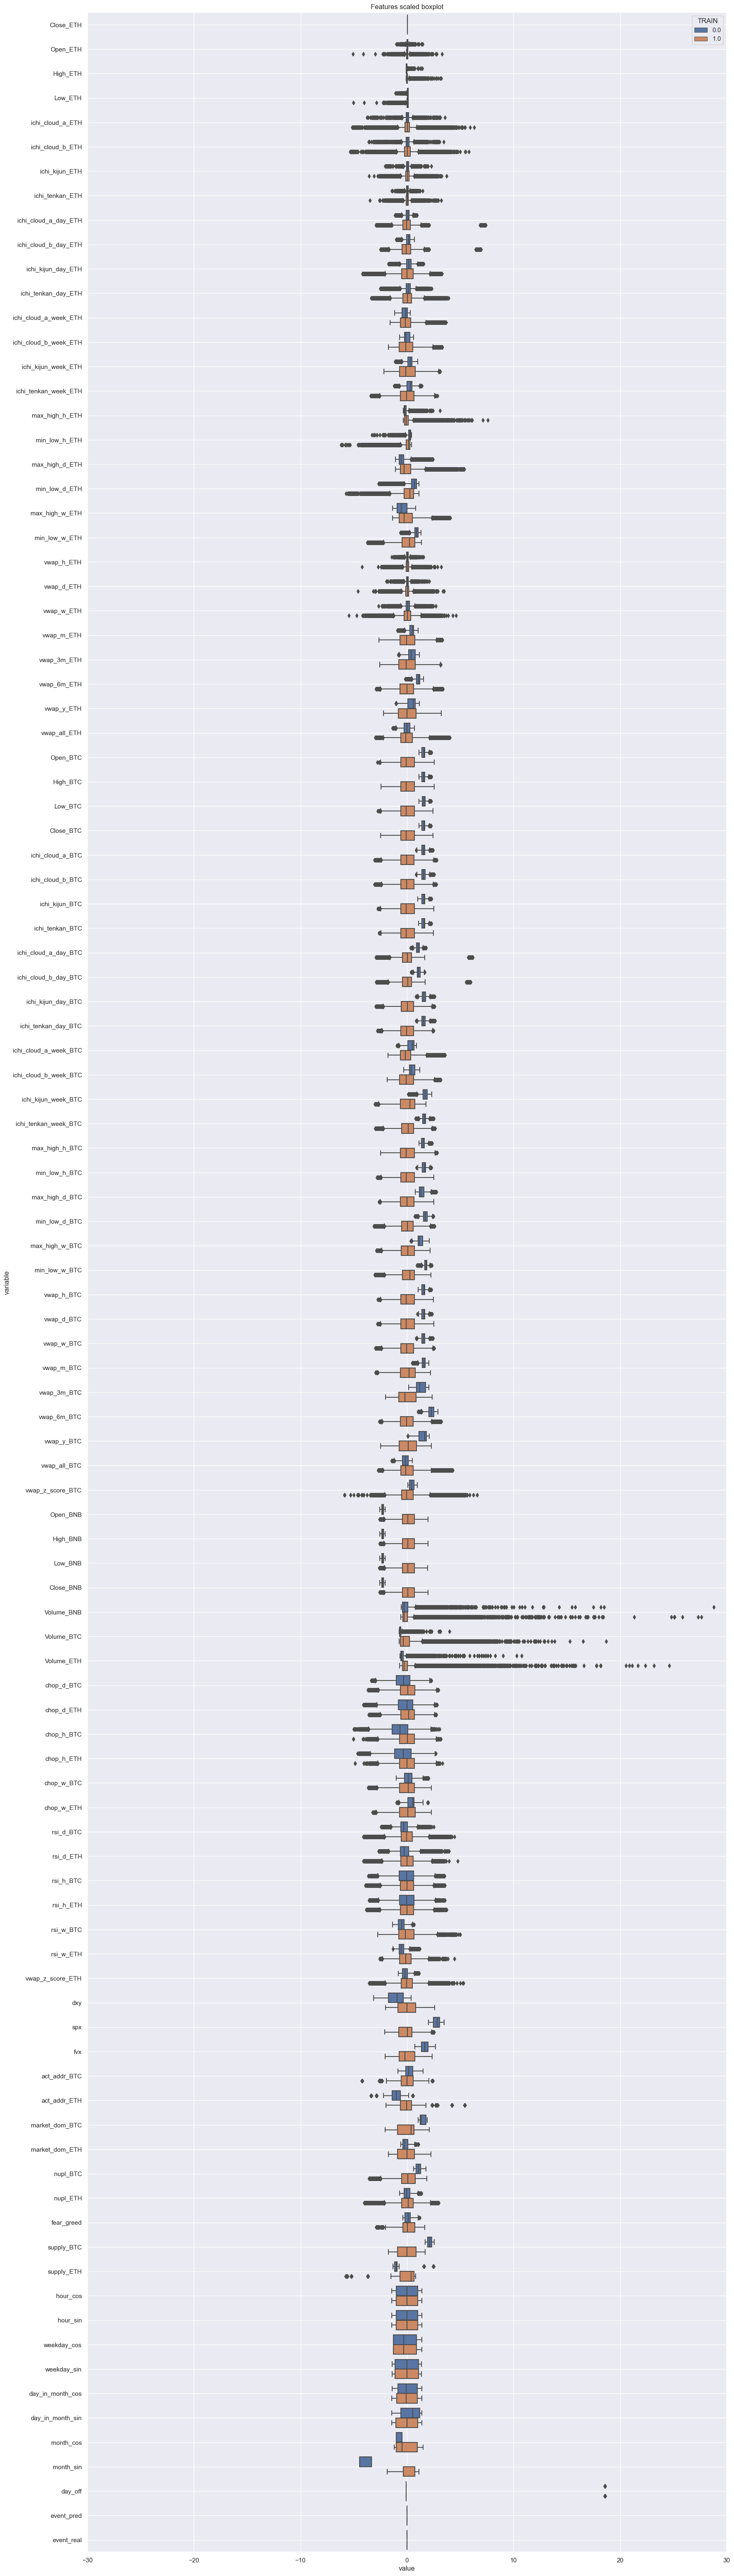

In [59]:
df_comp = df.melt(id_vars=["TRAIN"], value_vars=list_col_select, value_name="value")
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_comp, x="value", y="variable" , hue="TRAIN")
fig = plt.gcf()
ax = fig.gca()
ax.set_xlim([-30,30])
ax.yaxis.grid(True)
plt.title("Features scaled boxplot")

<AxesSubplot: >

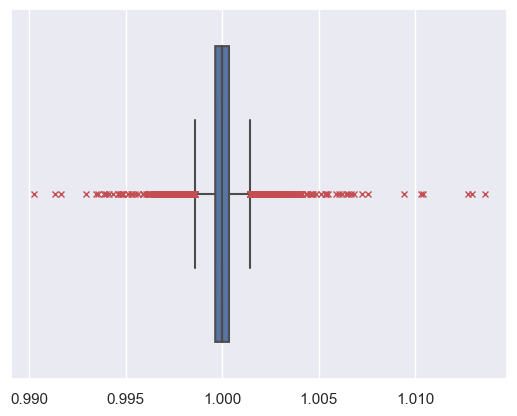

In [60]:
sns.boxplot(
    x=X_test[:,-1,:][:,1],  
    notch=True,
    flierprops={"markeredgecolor":"r", "marker": "x"}
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


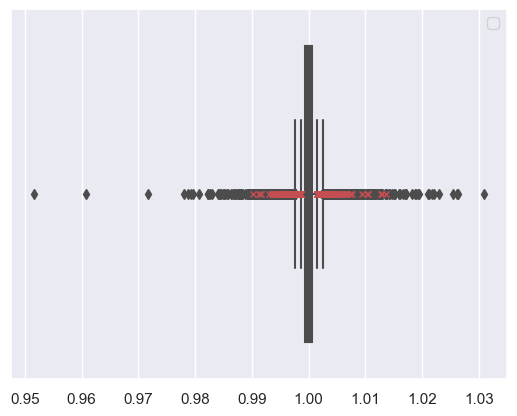

In [61]:
ax = sns.boxplot(
    x=X_train[:,-1,:][:,1],  
)
sns.boxplot(
    x=X_test[:,-1,:][:,1],  
    ax=ax, 
    flierprops={"markeredgecolor":"r", "marker": "x"},
)
plt.legend(loc='upper right')

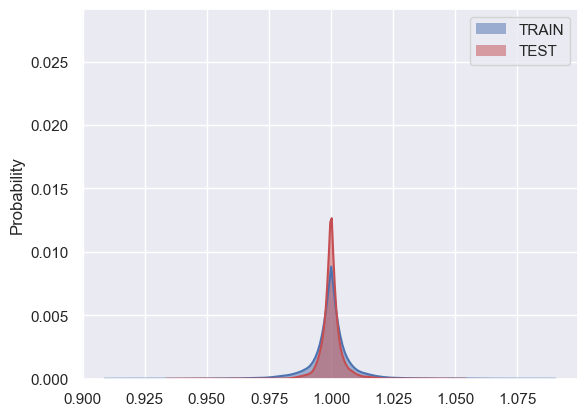

In [62]:

ax = sns.histplot(x=X_train.reshape(-1, X_train.shape[-1])[:,0],  stat="probability", kde=True, label="TRAIN")
sns.histplot(
    x=X_test.reshape(-1, X_test.shape[-1])[:,0],  
    stat="probability", 
    kde=True, 
    ax=ax, 
    color="r",
    label="TEST")
plt.legend(loc='upper right')

## Correlation

To simplify, we try to find correlation between all features X t-0 and target y t+1

In [63]:
X_train_sca.shape

(52048, 72, 104)

In [64]:
X_train_sca[:,-1,:].shape

(52048, 104)

In [65]:
y_train_sca[:,0][:, np.newaxis]

array([[ 0.08516126],
       [-0.03601705],
       [-0.19122832],
       ...,
       [-0.06581844],
       [ 0.11686756],
       [-0.03888029]])

In [66]:
np.hstack((X_train_sca[:,-1,:], y_train_sca[:,0][:, np.newaxis])).shape

(52048, 105)

In [67]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [68]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [69]:
def plot_corr(corr_matrix, title='Corrélation with 2 variables', aspect=None):
    # Afficher la matrice de corrélation
    if aspect is None:
        aspect = 1
    fig_size = (16, 16*len(corr_matrix.index)/len(corr_matrix.columns))
    fig, ax = plt.subplots(figsize=fig_size)
    im = ax.matshow(corr_matrix, aspect=aspect)
    plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
    plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
    plt.title(title)
    fig.colorbar(im)
    plt.show()

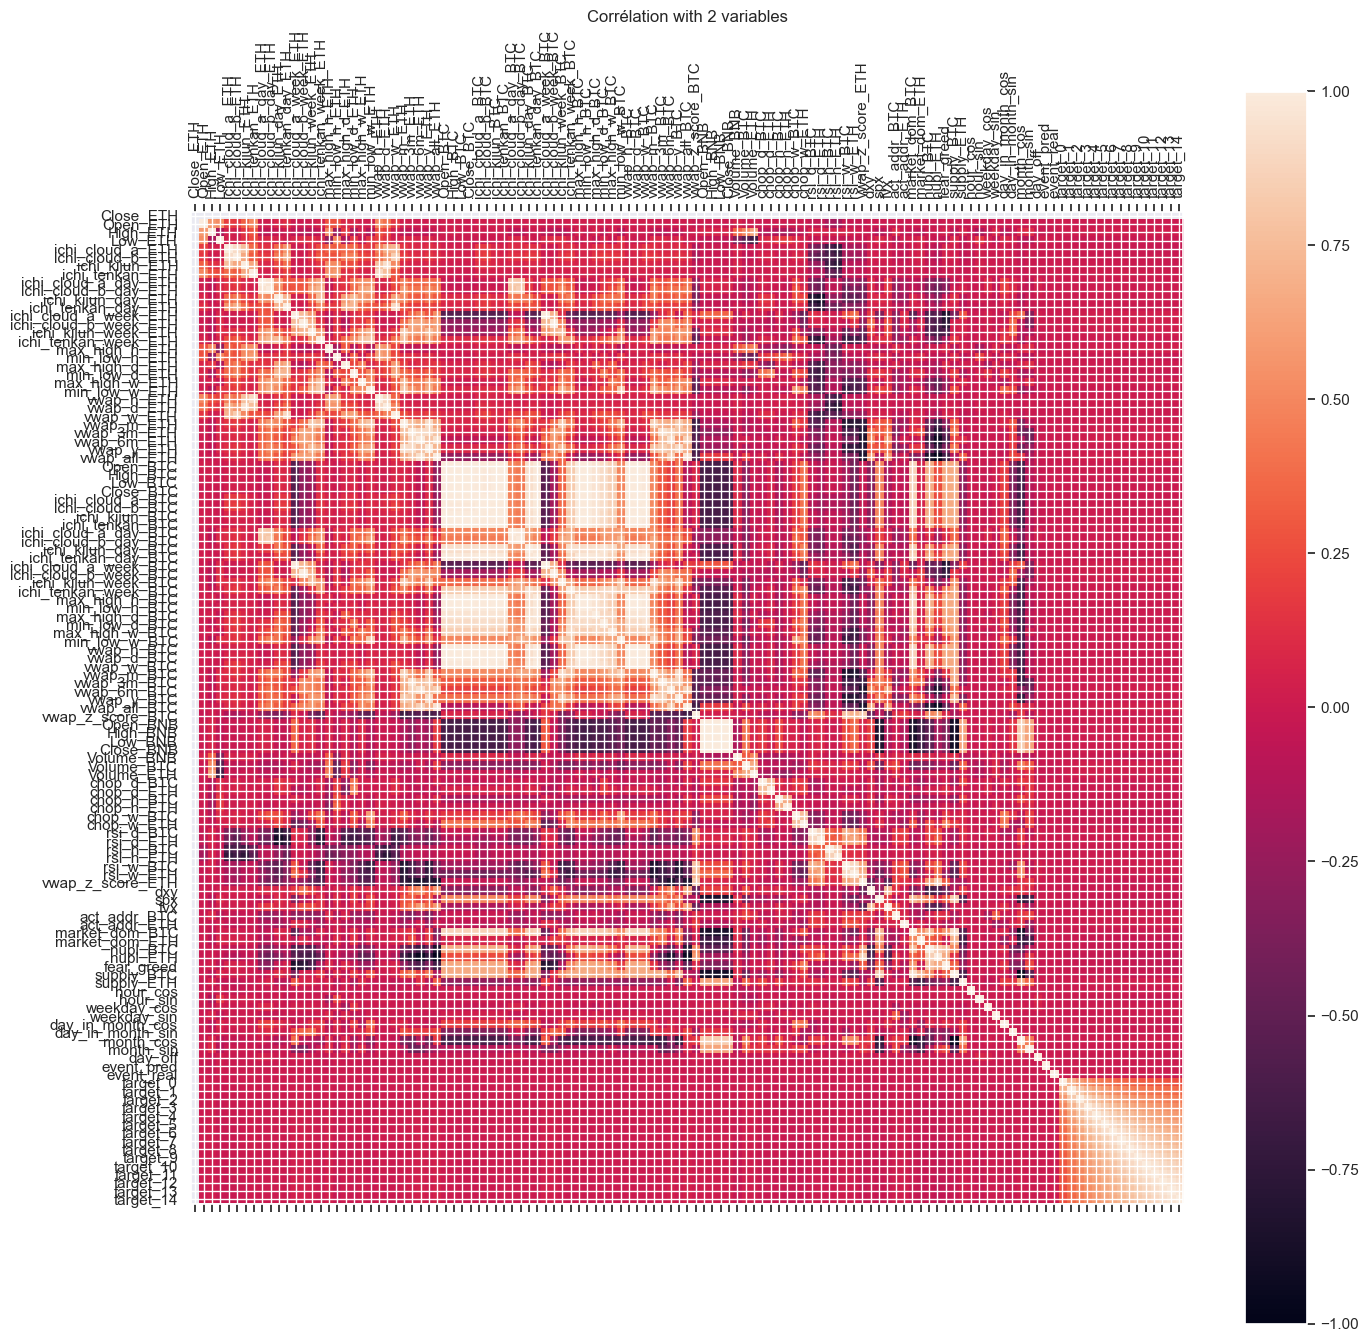

In [70]:

nb_plot = len(list_col_select)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_select[:nb_plot] + list_col_targets

# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), 
#    columns=list_col_select[:nb_plot] + ['target'])
df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train)), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df.corr()

fig = plot_corr(corr_matrix)


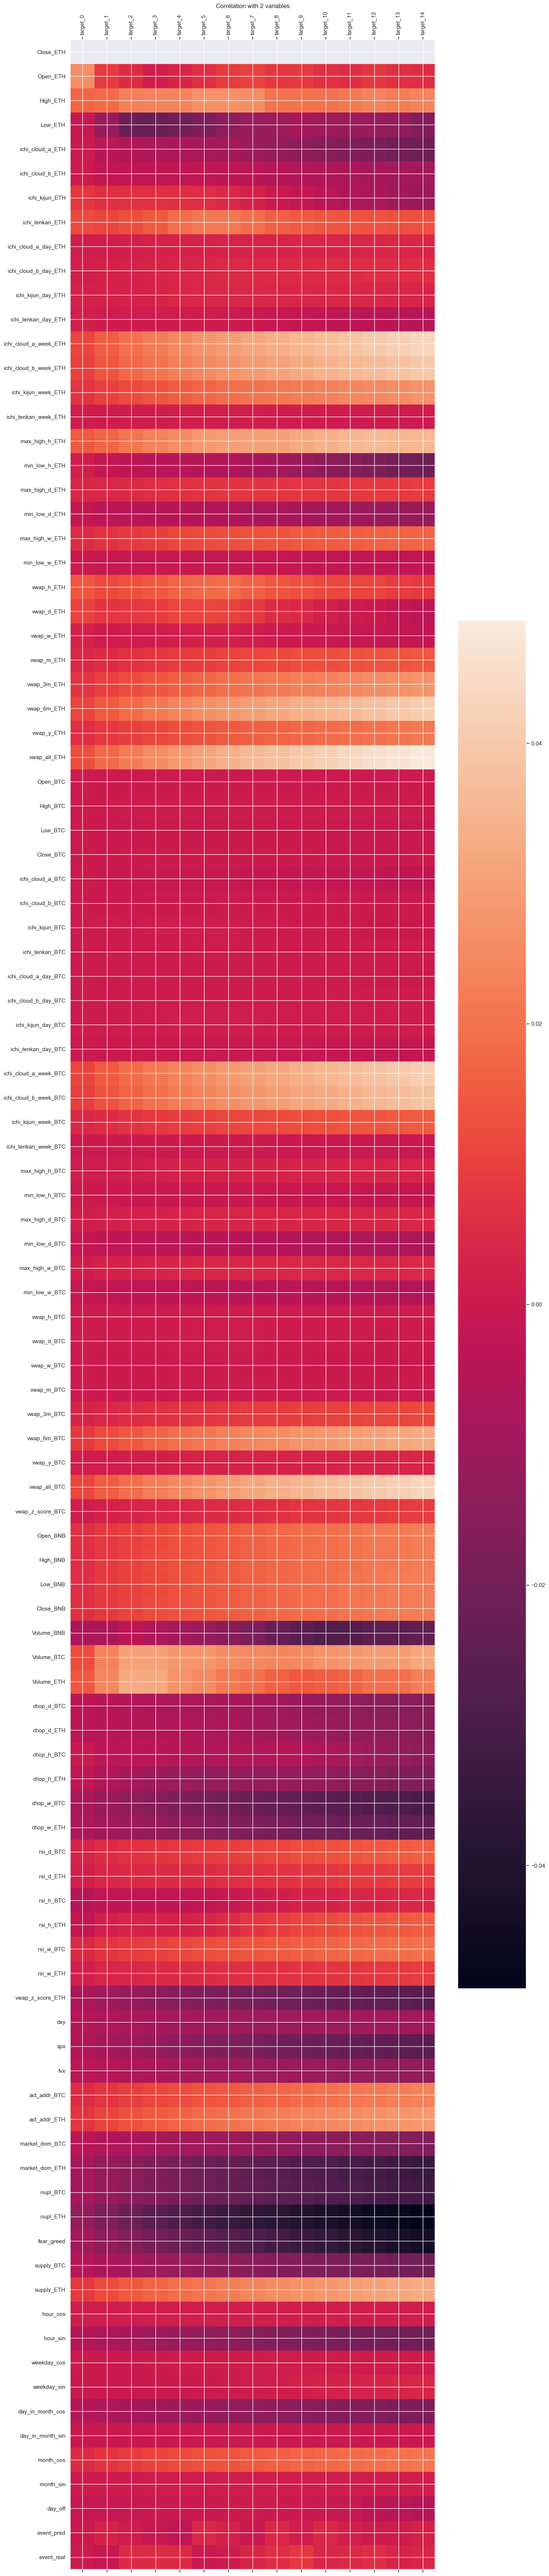

In [71]:
corr_matrix_targets = corr_matrix.copy().loc[list_col_select[:nb_plot], list_col_targets]
fig = plot_corr(corr_matrix_targets)


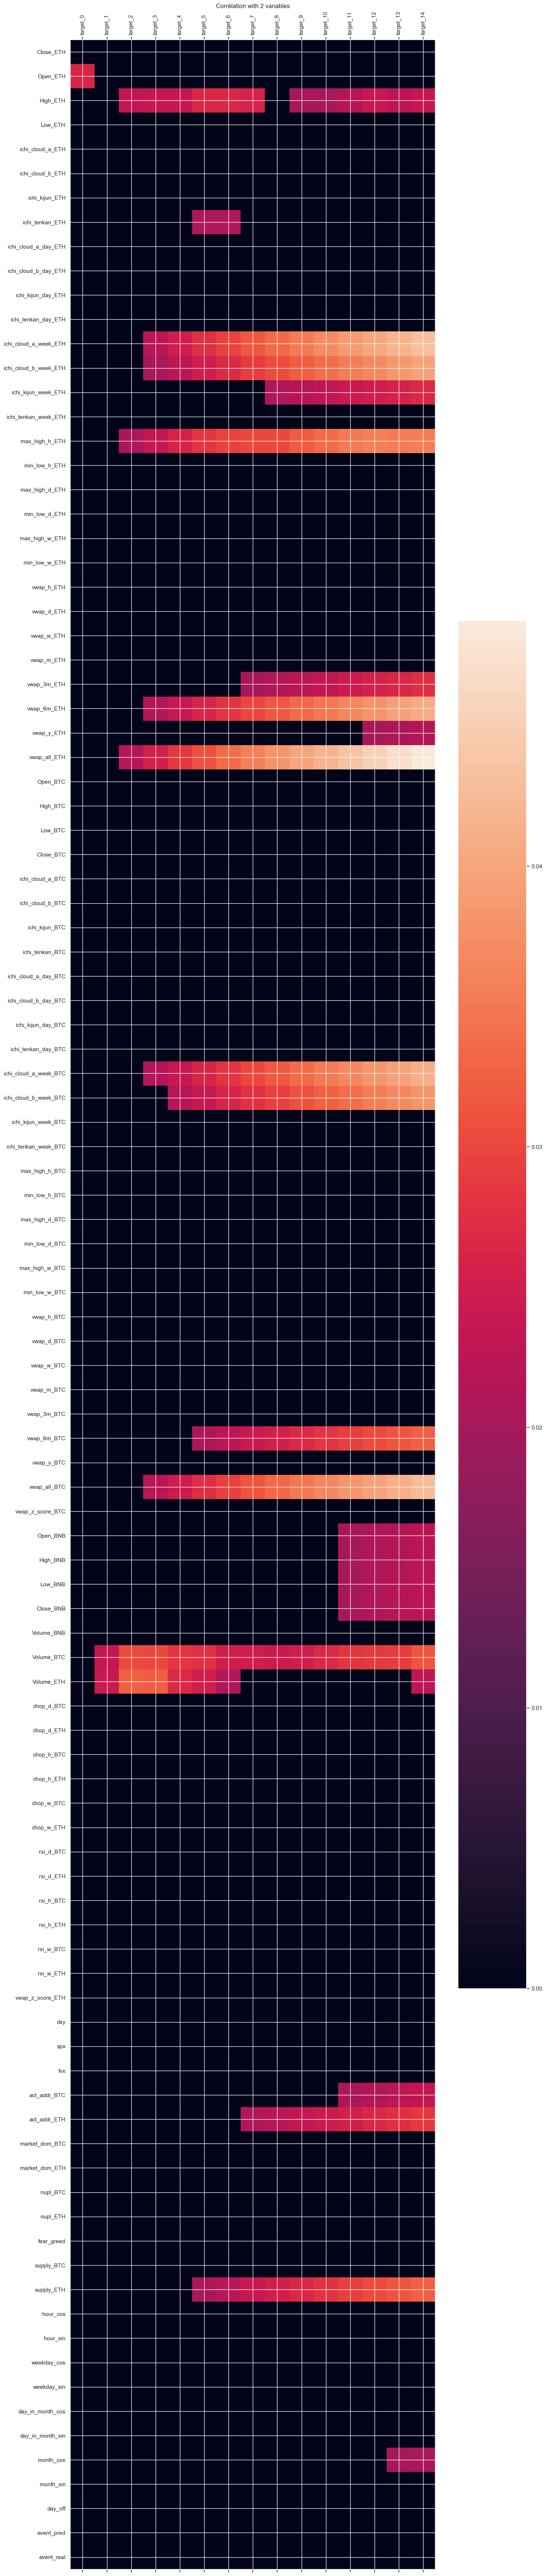

In [72]:
fig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0))

In [73]:
list_ichi_level=["lower", "neutral", "higher"]
df["ichi_cloud_a_week_cat"] = "neutral"
df.loc[df["ichi_cloud_a_week_ETH"] >= 1.05, "ichi_cloud_a_week_cat"] = "lower"
df.loc[df["ichi_cloud_a_week_ETH"] <= 0.95, "ichi_cloud_a_week_cat"] = "higher"

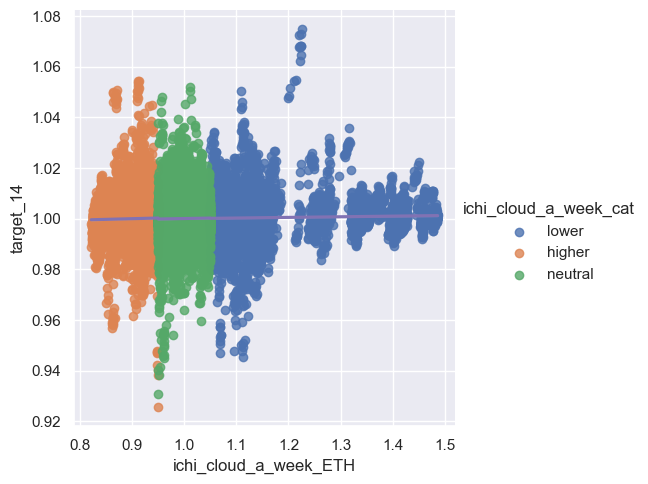

In [74]:
sns.lmplot(x="ichi_cloud_a_week_ETH", y="target_14",
            hue="ichi_cloud_a_week_cat", data=df,
           line_kws={"color": "C4"})

<AxesSubplot: xlabel='target_14', ylabel='ichi_cloud_a_week_cat'>

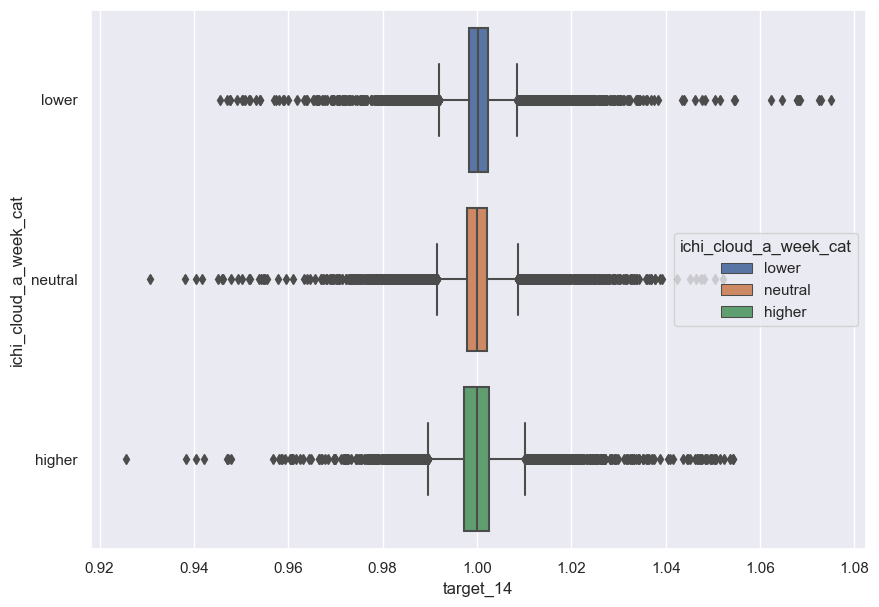

In [75]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="ichi_cloud_a_week_cat", 
    hue="ichi_cloud_a_week_cat", dodge=False, 
    order=list_ichi_level, hue_order=list_ichi_level)

In [76]:
"""df["vwap_all_ETH_under"] = df["vwap_all_ETH"] >= 1.05
df["vwap_all_ETH_above"] = df["vwap_all_ETH"] <= 0.95
df["vwap_all_ETH_neutral"] = ((df["vwap_all_ETH"] > 0.95) & (df["vwap_all_ETH"] < 1.05))
"""
list_vwap_level=["lower", "neutral", "higher"]
df["vwap_all_ETH_cat"] = "neutral"
df.loc[df["vwap_all_ETH"] >= 1.05, "vwap_all_ETH_cat"] = "lower"
df.loc[df["vwap_all_ETH"] <= 0.95, "vwap_all_ETH_cat"] = "higher"


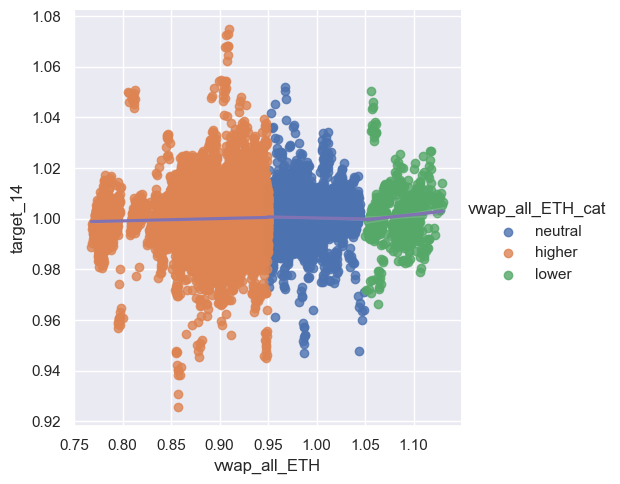

In [77]:
sns.lmplot(x="vwap_all_ETH", y="target_14", hue="vwap_all_ETH_cat", data=df,
           line_kws={"color": "C4"})

<AxesSubplot: xlabel='target_14', ylabel='vwap_all_ETH_cat'>

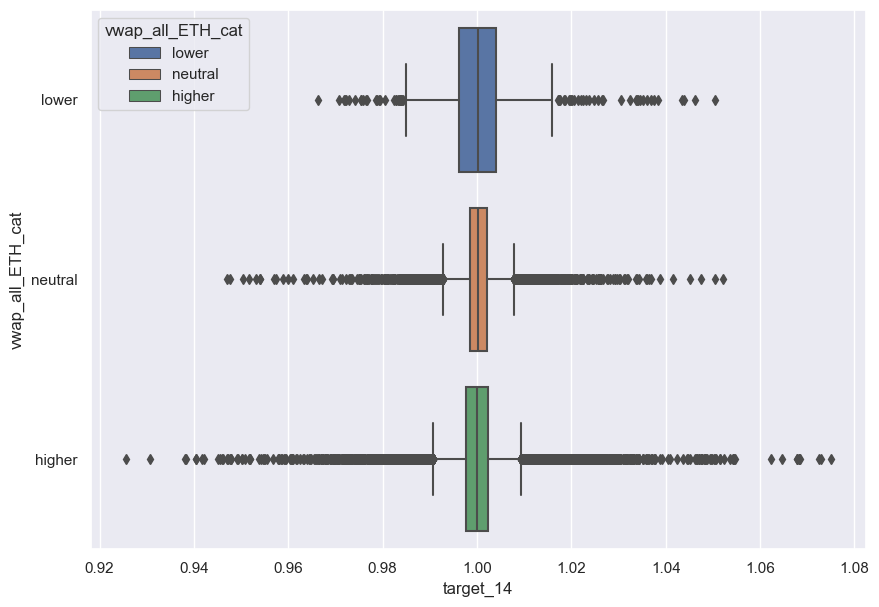

In [78]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="vwap_all_ETH_cat", 
    hue="vwap_all_ETH_cat", dodge=False, 
    order=list_vwap_level, hue_order=list_vwap_level)

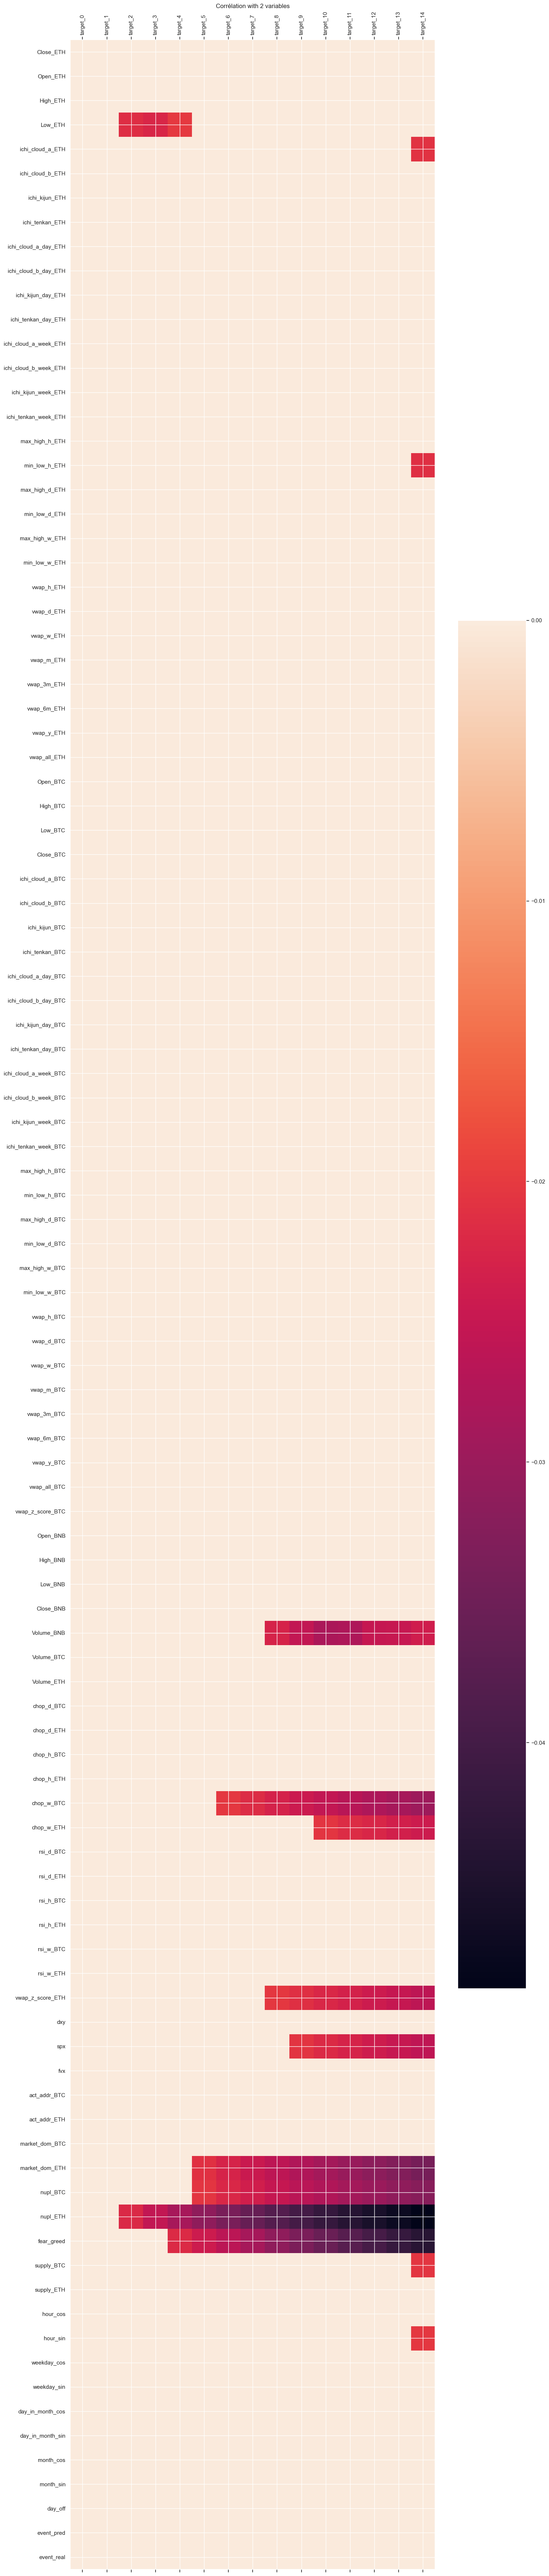

In [79]:
plot_corr(corr_matrix_targets.where(corr_matrix_targets<-0.02, 0))

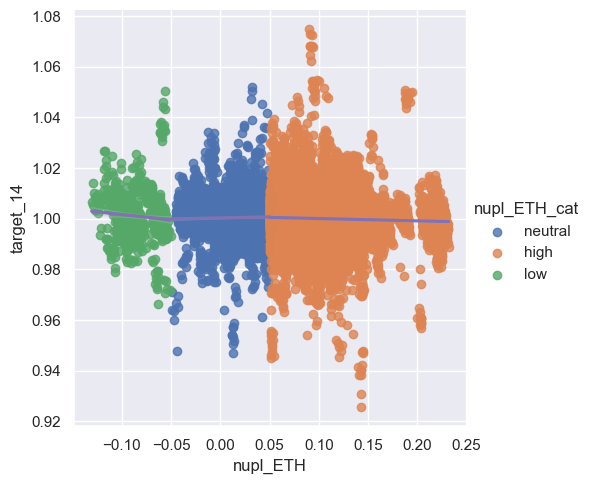

In [80]:


list_nupl_level=["low", "neutral", "high"]
df["nupl_ETH_cat"] = "neutral"
df.loc[df["nupl_ETH"] <= -0.05, "nupl_ETH_cat"] = "low"
df.loc[df["nupl_ETH"] >= 0.05, "nupl_ETH_cat"] = "high"

sns.lmplot(x="nupl_ETH", y="target_14", hue="nupl_ETH_cat", data=df,
           line_kws={"color": "C4"})

<AxesSubplot: xlabel='target_14', ylabel='nupl_ETH_cat'>

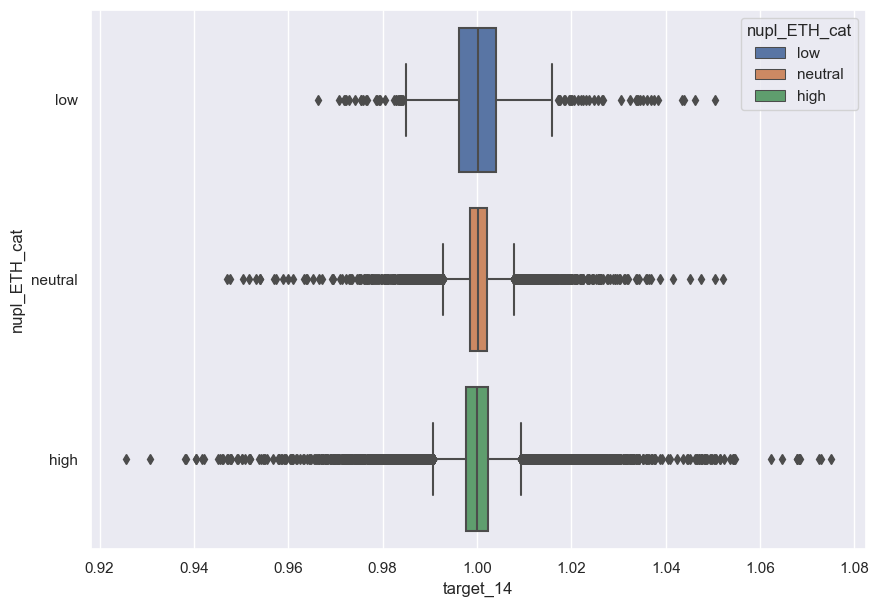

In [81]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="nupl_ETH_cat", 
    hue="nupl_ETH_cat", dodge=False, 
    order=list_nupl_level, hue_order=list_nupl_level)

In [82]:
df["target_14"].describe()

count    52048.000000
mean         1.000157
std          0.006035
min          0.925613
25%          0.997880
50%          1.000050
75%          1.002322
max          1.074927
Name: target_14, dtype: float64

In [83]:
df["target_1"].describe()

count    52048.000000
mean         1.000021
std          0.002213
min          0.967271
25%          0.999166
50%          1.000011
75%          1.000862
max          1.053076
Name: target_1, dtype: float64

<AxesSubplot: xlabel='target_14'>

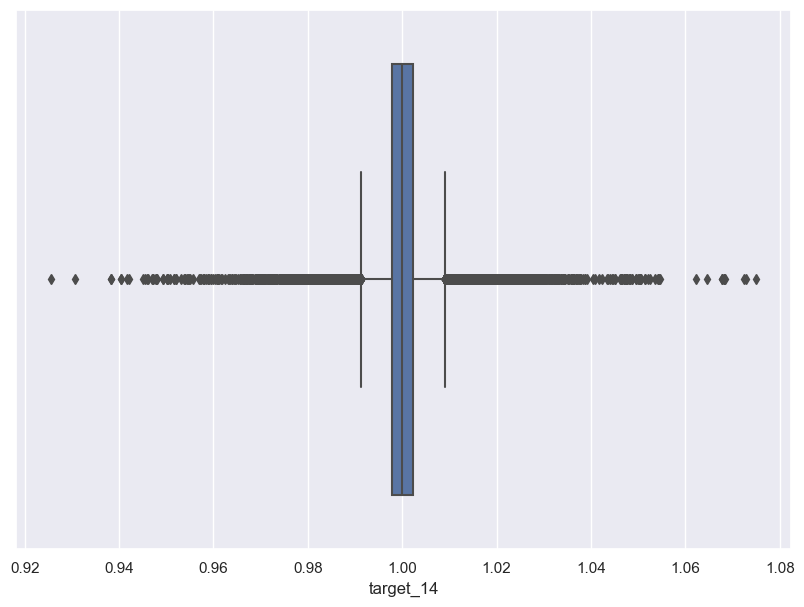

In [84]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(x=df["target_14"]) 

In [85]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [0.99979294, 1.00039342, 1.00030542, ..., 1.00272804, 1.00086448,
        1.00115437],
       [1.0006006 , 1.00051258, 1.00228333, ..., 1.00107177, 1.00136171,
        1.00224709],
       [0.99991203, 1.00168172, 1.00199736, ..., 1.00076065, 1.00164549,
        1.00364286]])

In [86]:
y_train_sca

array([[ 0.08516126,  0.06811946, -0.1041921 , ..., -0.04359903,
         0.01510052, -0.05117316],
       [-0.03601705, -0.2082493 , -0.05683633, ..., -0.08901159,
        -0.15525476, -0.28963378],
       [-0.19122832, -0.03980394, -0.14769381, ..., -0.13822978,
        -0.27261892, -0.33697428],
       ...,
       [-0.06581844,  0.07000408,  0.05009905, ...,  0.59807267,
         0.1765545 ,  0.242124  ],
       [ 0.11686756,  0.09695841,  0.4974836 , ...,  0.22344005,
         0.28902312,  0.48928572],
       [-0.03888029,  0.36140449,  0.43280031, ...,  0.15306914,
         0.35321153,  0.80499493]])

## Autoencoder

### Model creation

### Training

In [87]:
X_train_sca.shape

(52048, 72, 104)

In [88]:
3*3*3*10*35/3600

2.625

Training: TS 0.8 - units 4 - enc_dim 2 - drop 0 ...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 104)]       0         
                                                                 
 lstm (LSTM)                 (None, None, 4)           1744      
                                                                 
 layer_normalization (LayerN  (None, None, 4)          8         
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, None, 4)           0         
                                                                 
 dense (Dense)               (None, None, 2)           10        
                                                                 
Total params: 1,762
Trainable params: 1,762
Non-trainable params: 0
_______

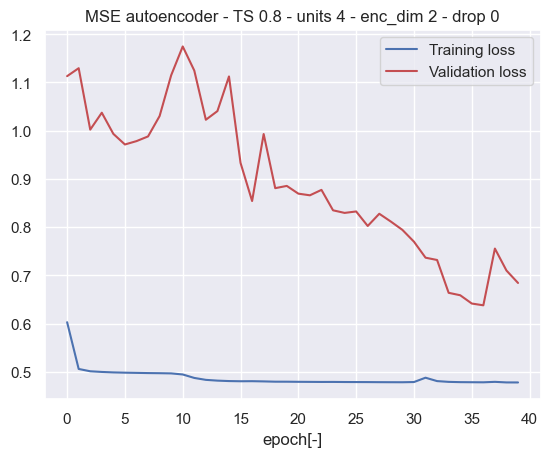

MSE TEST :  0.6381790637969971
Save autoencoder:  data/mdl_autoencoder


INFO:tensorflow:Assets written to: data/mdl_autoencoder/assets


INFO:tensorflow:Assets written to: data/mdl_autoencoder/assets


Save encoder:  data/mdl_encoder


INFO:tensorflow:Assets written to: data/mdl_encoder/assets


INFO:tensorflow:Assets written to: data/mdl_encoder/assets


Best model : n_unit:4 / enc_dim: 2 / dropout: 0


In [90]:
#n_unit_enc = 16
#encoding_dim = 4
#dropout_autoenc = 0.5
seed = 1
epochs = 40 #100 #150 #6 #300
patience = 10 #20 #40 #3 #100
mse_curr_min = None
if MODE_TRAIN_AE:
    for n_unit_enc in [4]: #[32, 64, 128]: #[104]: #
        for encoding_dim in [2]:#[16, 20, 32]:
            for dropout_autoenc in [0]: #[0.05, 0.15, 0.25]: #[0.25]:
                # check already done ? 
                #ie: output_MSE autoencoder - units 16 - enc_dim 4 - drop 0.25.jpg
                plt_name = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
                path_jpg = os.path.join(path_data,
                    f"output_MSE autoencoder - {plt_name}.jpg")
                if (MODE_TRAIN_AE == False):
                    print(f"BE CAREFUL ! training inactivated => no training done...")
                    continue
                print(f"Training: {plt_name} ...")
                # Init
                tf.keras.backend.clear_session()
                np.random.seed(seed)
                random.seed(seed)
                tf.random.set_seed(seed)
                # Input dimension
                input_dim = X_train.shape[-1]
                # Reduced encoded input dimension
                # 64/8/0.5
                # Définir l'encodeur
                encoder_inputs = keras.Input(shape=(None, input_dim))
                encoder = layers.LSTM(n_unit_enc, return_sequences=True)(encoder_inputs)
                encoder = layers.LayerNormalization()(encoder)
                #encoder = layers.Dense(encoding_dim, activation='relu')
                encoder = layers.Dropout(dropout_autoenc)(encoder)
                encoder_outputs = layers.Dense(encoding_dim)(encoder)
                encoder_model = keras.Model(encoder_inputs, encoder_outputs)
                print(encoder_model.summary())
                # Définir le décodeur
                decoder_inputs = keras.Input(shape=(None, encoding_dim))
                decoder = layers.LSTM(n_unit_enc, return_sequences=True)(decoder_inputs)
                decoder = layers.LayerNormalization()(decoder)
                #decoder = layers.Dense(n_unit_enc, activation='relu')
                #decoder = layers.Dropout(dropout_autoenc)(decoder)
                decoder_outputs = layers.Dense(input_dim)(decoder)
                decoder_model = keras.Model(decoder_inputs, decoder_outputs)
                print(decoder_model.summary())
                # Define complete autoencoder 
                autoencoder_inputs = keras.Input(shape=(None, input_dim))
                encoded = encoder_model(autoencoder_inputs)
                decoded = decoder_model(encoded)
                autoencoder = keras.Model(autoencoder_inputs, decoded)
                # Compile : autoencoder
                optim = tf.keras.optimizers.legacy.Adam()
                #optim = tf.keras.optimizers.Adam()
                autoencoder.compile(optimizer=optim, loss="mse")
                # earlystop 
                es = EarlyStopping(patience=patience, verbose=2, min_delta=0.001, 
                                monitor='val_loss', mode='auto', restore_best_weights=True)
                # Train
                if patience == 0:
                    autoenc_step_history = autoencoder.fit(X_train_sca,X_train_sca,
                    epochs=epochs, batch_size=BATCH_SIZE, validation_data=(X_test_sca,X_test_sca),
                    verbose=1)
                else:
                    autoenc_step_history = autoencoder.fit(X_train_sca,X_train_sca,
                        epochs=epochs, batch_size=BATCH_SIZE, validation_data=(X_test_sca,X_test_sca),
                        verbose=1, callbacks=[es])

                plot_train_history(
                    autoenc_step_history,f"MSE autoencoder - {plt_name}",
                    saveFolder=path_data)
                #autoencoder.save(f"{path_mdl_autoencoder}_u{n_unit_enc}_e{encoding_dim}_d{dropout_autoenc}")
                #encoder_model.save(f"{path_mdl_encoder}_u{n_unit_enc}_e{encoding_dim}_d{dropout_autoenc}")
                            # save the best
                mse_curr = np.min(autoenc_step_history.history['val_loss'])
                print("MSE TEST : ", mse_curr)

                if mse_curr_min == None:
                    mse_curr_min = mse_curr
                    n_unit_enc_min = n_unit_enc
                    encoding_dim_min = encoding_dim
                    dropout_autoenc_min = dropout_autoenc
                    print("Save autoencoder: ", path_mdl_autoencoder)
                    autoencoder.save(path_mdl_autoencoder)
                    print("Save encoder: ", path_mdl_encoder)
                    encoder_model.save(path_mdl_encoder)
                else:
                    if mse_curr < mse_curr_min:
                        mse_curr_min = mse_curr
                        n_unit_enc_min = n_unit_enc
                        encoding_dim_min = encoding_dim
                        dropout_autoenc_min = dropout_autoenc
                        print("Save autoencoder: ", path_mdl_autoencoder)
                        autoencoder.save(path_mdl_autoencoder)
                        print("Save encoder: ", path_mdl_encoder)
                        encoder_model.save(path_mdl_encoder)

    mse_curr = mse_curr_min 
    n_unit_enc = n_unit_enc_min 
    encoding_dim = encoding_dim_min
    dropout_autoenc = dropout_autoenc_min
else:
    print("Load models...")
    autoencoder = tf.keras.models.load_model(path_mdl_autoencoder)
    print(autoencoder.summary())
    encoder_model = tf.keras.models.load_model(path_mdl_encoder)
    print(encoder_model.summary())
    n_unit_enc = encoder_model.layers[1].units
    dropout_autoenc = encoder_model.layers[3].rate
    encoding_dim = encoder_model.layers[4].units

print(f"Best model : n_unit:{n_unit_enc} / enc_dim: {encoding_dim} / dropout: {dropout_autoenc}")

### Save model

In [90]:
# TODO select best model


In [91]:
path_mdl_autoencoder

'data/mdl_autoencoder'

In [92]:
#autoencoder.save(path_mdl_autoencoder)
#encoder_model.save(path_mdl_encoder)


In [93]:
X_train_sca_pred = autoencoder.predict(X_train_sca)
X_train_sca_pred.shape

2023-08-10 01:48:09.986974: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1589/1589 [==============================] - 34s 21ms/step


(50831, 72, 104)

### Results

In [94]:
X_train[:,-1,0]

array([1., 1., 1., ..., 1., 1., 1.])

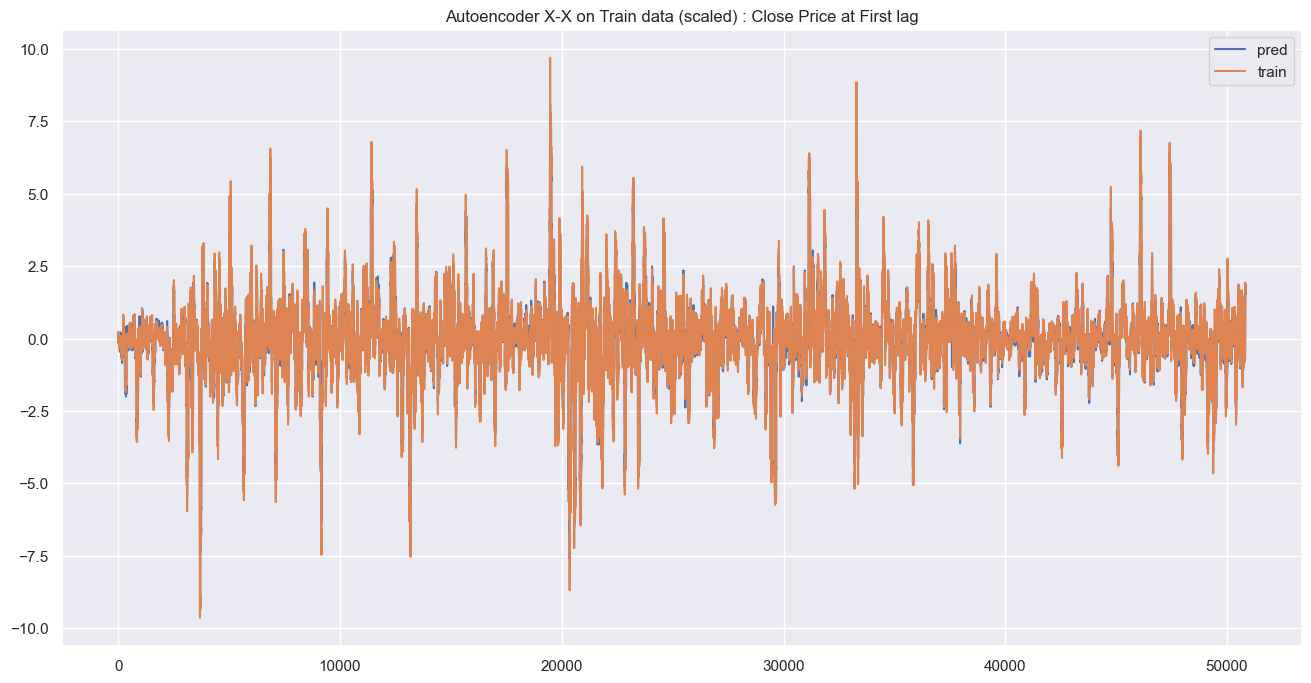

In [95]:
fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Train data (scaled) : Close Price at First lag")
plt.plot(X_train_sca_pred[:,0,0], label="pred")
plt.plot(X_train_sca[:,0,0], label="train")
plt.legend(loc='upper right')

##### MAE by lags and by features

In [96]:
print(X_train_sca_pred.shape) 
print(X_train_sca.shape)
mae_ae_train = np.mean(np.abs(X_train_sca_pred - X_train_sca), 0)
print(mae_ae_train.shape)
mae_ae_train_feat = np.mean(mae_ae_train, 0)[np.newaxis,:]
print(mae_ae_train_feat.shape)
df_mae_train = pd.DataFrame(mae_ae_train, columns=list_col_select)
df_mae_train.index = [f"lag_{i_lag}" for i_lag in range(len(df_mae_train.index))]
df_mae_train_feat = pd.DataFrame(mae_ae_train_feat, columns=list_col_select)

(50831, 72, 104)
(50831, 72, 104)
(72, 104)
(1, 104)


In [97]:
df_mae_train

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
lag_0    0.119113  0.128392  0.112599  0.116738          0.170482   
lag_1    0.102663  0.101601  0.090473  0.094330          0.149794   
lag_2    0.097514  0.097119  0.083773  0.090080          0.143194   
lag_3    0.095921  0.094814  0.081677  0.088564          0.138886   
lag_4    0.095975  0.093717  0.080897  0.088572          0.136418   
...           ...       ...       ...       ...               ...   
lag_67   0.094631  0.091363  0.079923  0.088080          0.129333   
lag_68   0.094596  0.091316  0.079873  0.088045          0.129340   
lag_69   0.094530  0.091295  0.079836  0.087994          0.129303   
lag_70   0.094509  0.091230  0.079803  0.087948          0.129287   
lag_71   0.094413  0.091251  0.079756  0.087930          0.129253   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
lag_0           0.158299        0.135849         0.120036   
lag_1           0.133967        0.123725         0.101528   
lag_2           0.124247        0.120414         0.095317   
lag_3           0.118227        0.117516         0.090331   
lag_4           0.114319        0.115747         0.087138   
...                  ...             ...              ...   
lag_67          0.107696        0.107010         0.078226   
lag_68          0.107694        0.107002         0.078213   
lag_69          0.107663        0.106940         0.078184   
lag_70          0.107643        0.106911         0.078133   
lag_71          0.107605        0.106863         0.078073   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  hour_sin  \
lag_0               0.142091              0.115146  ...  0.163910   
lag_1               0.121542              0.101928  ...  0.117529   
lag_2               0.115365              0.097108  ...  0.100878   
lag_3               0.111844              0.094303  ...  0.091641   
lag_4               0.110542              0.092429  ...  0.087963   
...                      ...                   ...  ...       ...   
lag_67              0.104406              0.087988  ...  0.073427   
lag_68              0.104397              0.087969  ...  0.073340   
lag_69              0.104394              0.087937  ...  0.073252   
lag_70              0.104385              0.087915  ...  0.073162   
lag_71              0.104393              0.087895  ...  0.073069   

        weekday_cos  weekday_sin  day_in_month_cos  day_in_month_sin  \
lag_0      0.162918     0.153282          0.167424          0.180264   
lag_1      0.109096     0.100864          0.138206          0.154645   
lag_2      0.090996     0.083545          0.129076          0.145497   
lag_3      0.082443     0.075496          0.125427          0.140487   
lag_4      0.078192     0.074324          0.122224          0.137442   
...             ...          ...               ...               ...   
lag_67     0.065995     0.064130          0.104422          0.128666   
lag_68     0.065959     0.064074          0.104378          0.128652   
lag_69     0.065904     0.064029          0.104313          0.128659   
lag_70     0.065873     0.063997          0.104276          0.128646   
lag_71     0.065820     0.063939          0.104220          0.128644   

        month_cos  month_sin   day_off  event_pred  event_real  
lag_0    0.091466   0.186883  0.129909    0.221769    0.079399  
lag_1    0.087529   0.176719  0.082216    0.131576    0.079749  
lag_2    0.085392   0.169962  0.064253    0.097078    0.078755  
lag_3    0.084004   0.168394  0.055994    0.094332    0.077325  
lag_4    0.083350   0.167007  0.050566    0.093128    0.076411  
...           ...        ...       ...         ...         ...  
lag_67   0.079979   0.165482  0.034258    0.076227    0.071052  
lag_68   0.079966   0.165465  0.034217    0.076198    0.071026  
lag_69   0.079949   0.165445  0.034180    0.076169    0.070983  
lag_70   0.079933   0.165427  0.034142    0.076159    0.070940  
lag_71   0.079918   0.165421  0.03410

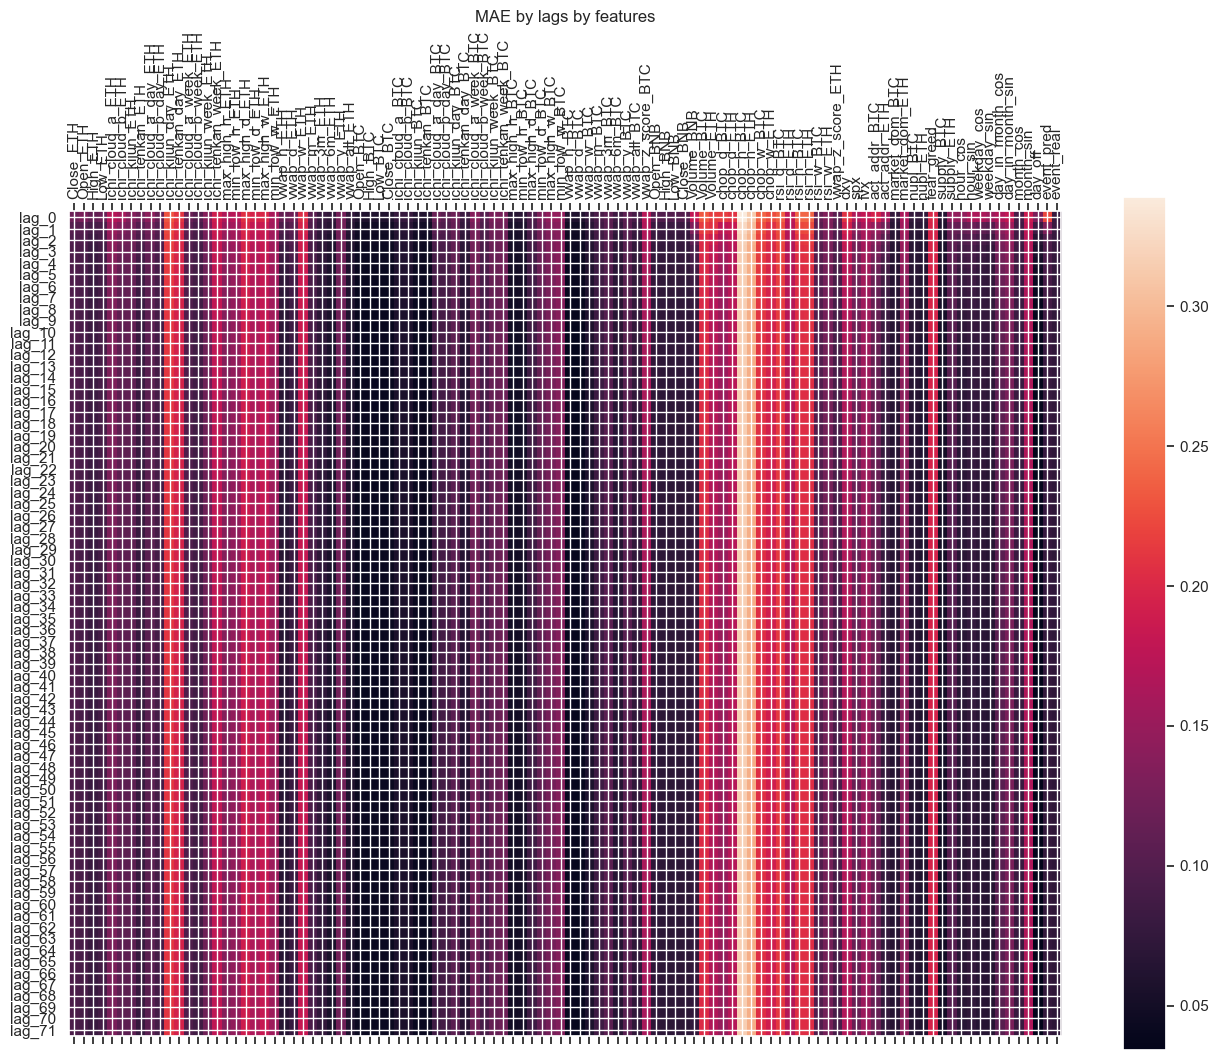

In [98]:
plot_corr(df_mae_train, "MAE by lags by features", aspect=1.2 )

/Users/gregory/miniforge3/envs/ocean_tf_new/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<AxesSubplot: >

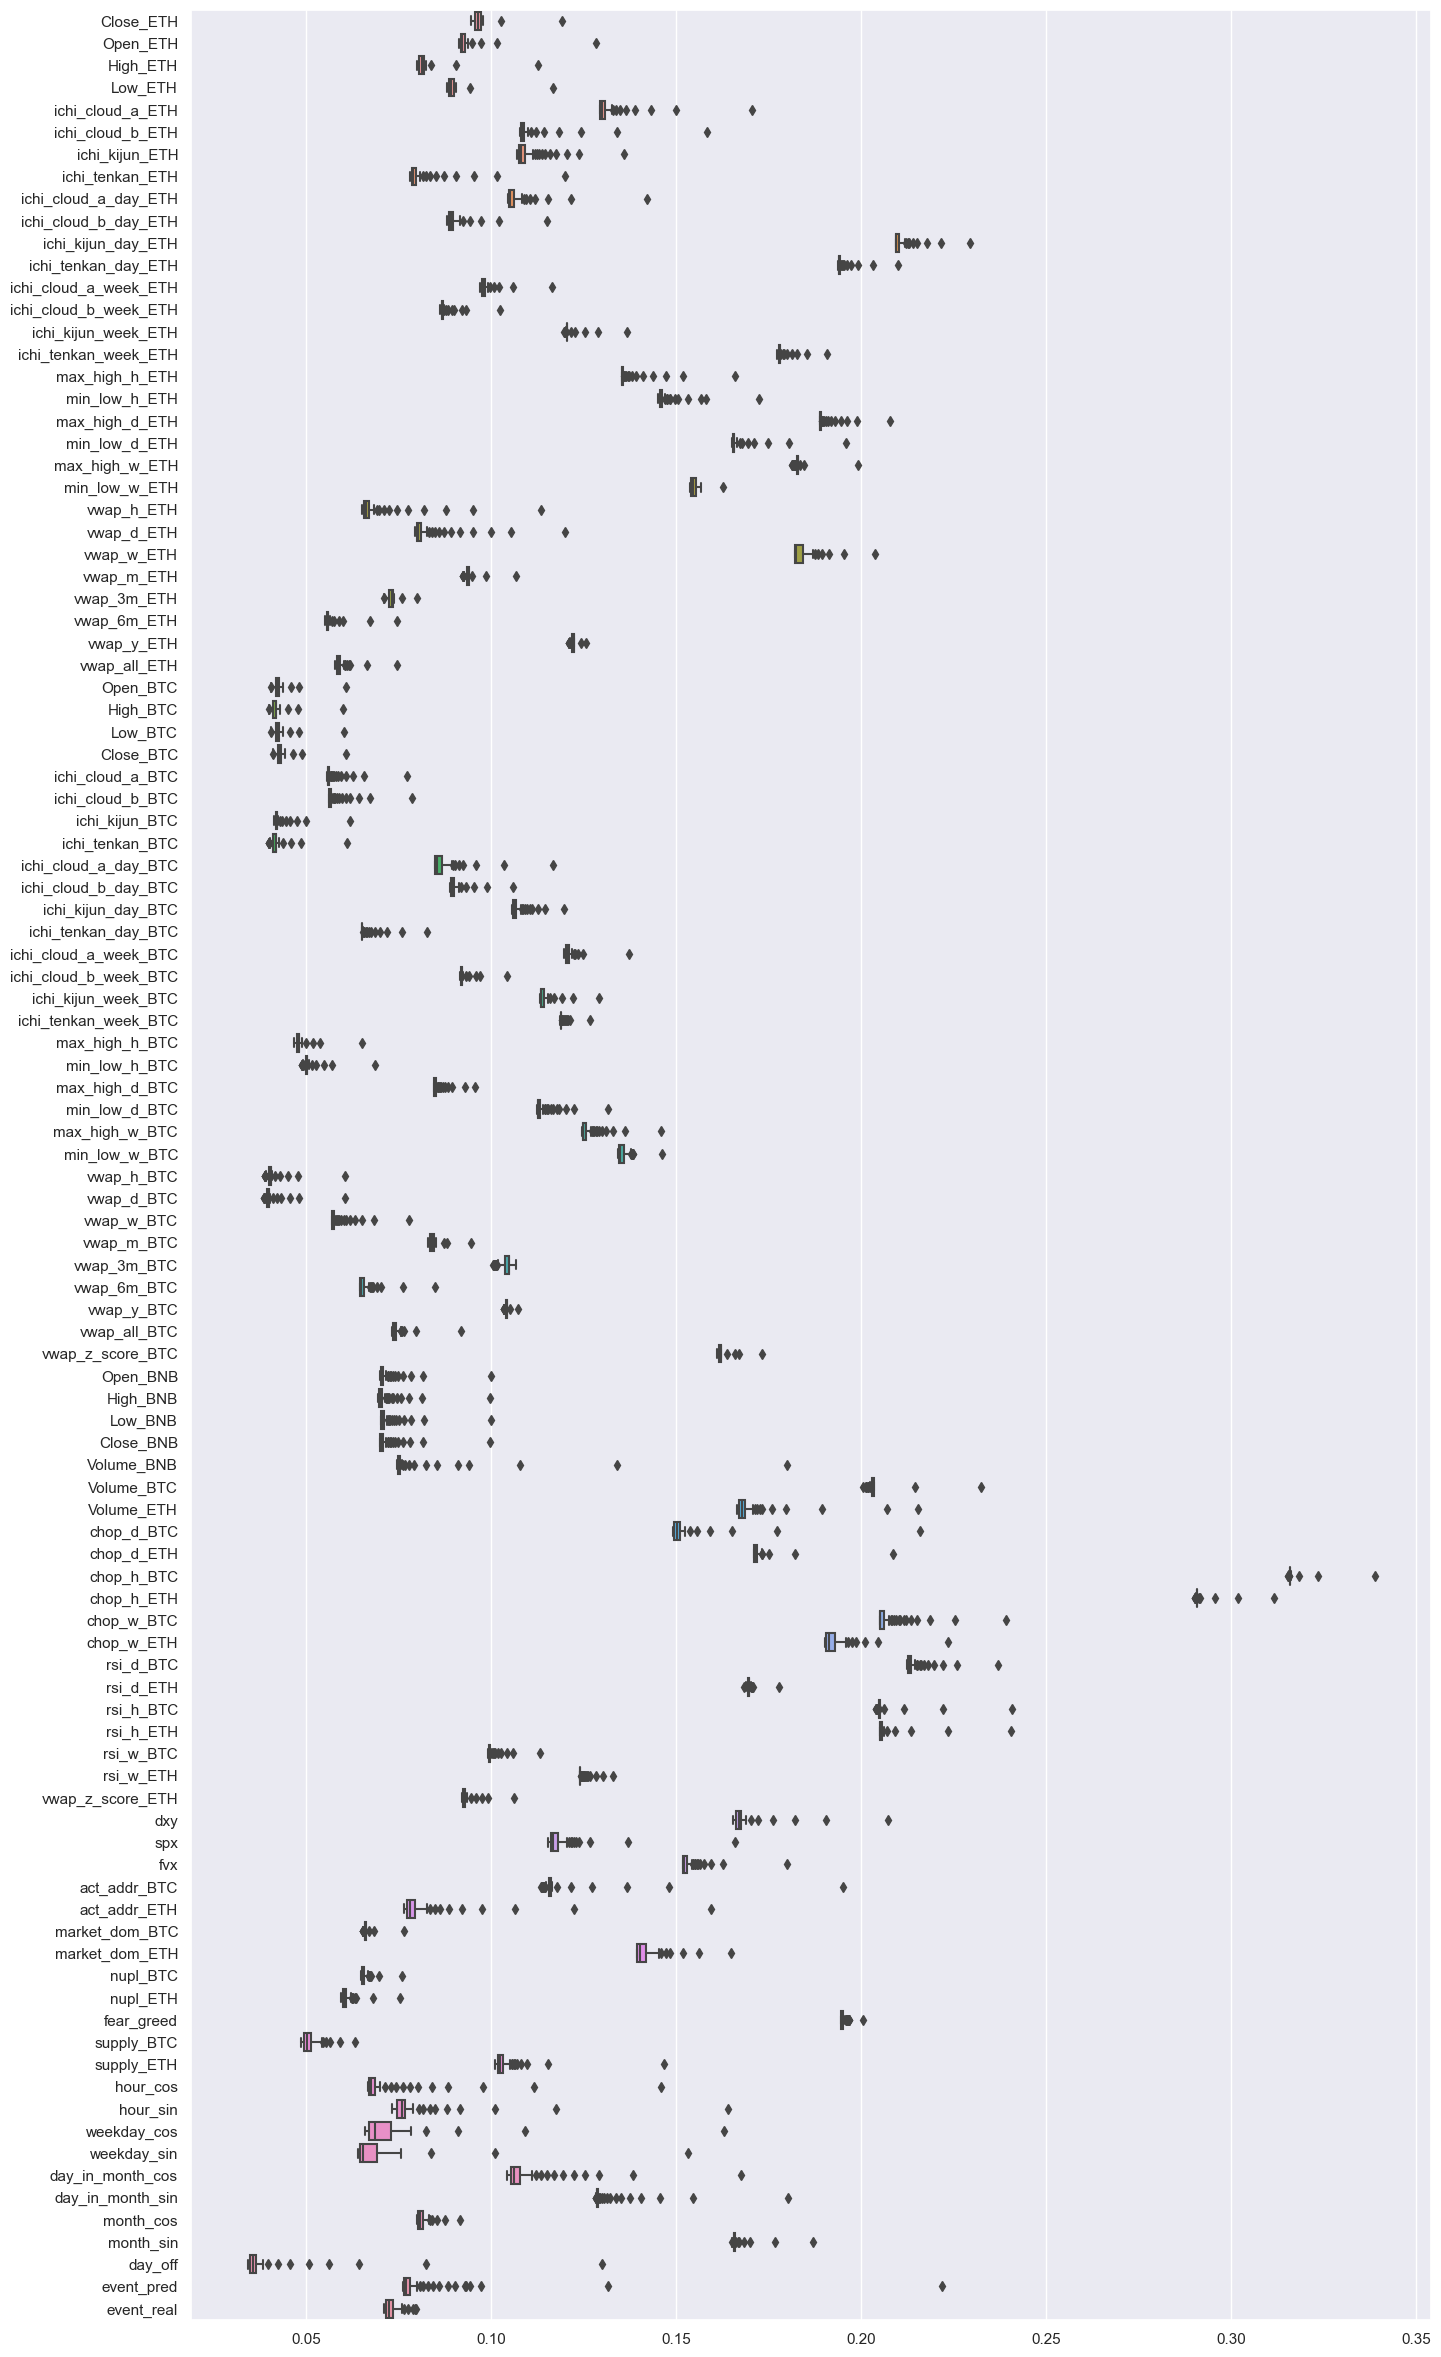

In [99]:
plt.figure(figsize=(16, 30))
sns.boxplot(data=df_mae_train, orient="h")

In [100]:
df_mae_train_feat

Close_ETH  Open_ETH  High_ETH  Low_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0   0.096711  0.092921  0.081688  0.08967          0.131378          0.109969   

   ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0        0.109387         0.080496              0.106449   

   ichi_cloud_b_day_ETH  ...  hour_sin  weekday_cos  weekday_sin  \
0              0.089803  ...  0.078319      0.07191     0.068803   

   day_in_month_cos  day_in_month_sin  month_cos  month_sin   day_off  \
0          0.108887          0.130512     0.0812   0.166168  0.038547   

   event_pred  event_real  
0    0.081407    0.072854  

[1 rows x 104 columns]

Text(0.5, 1.0, 'MAE per feature')

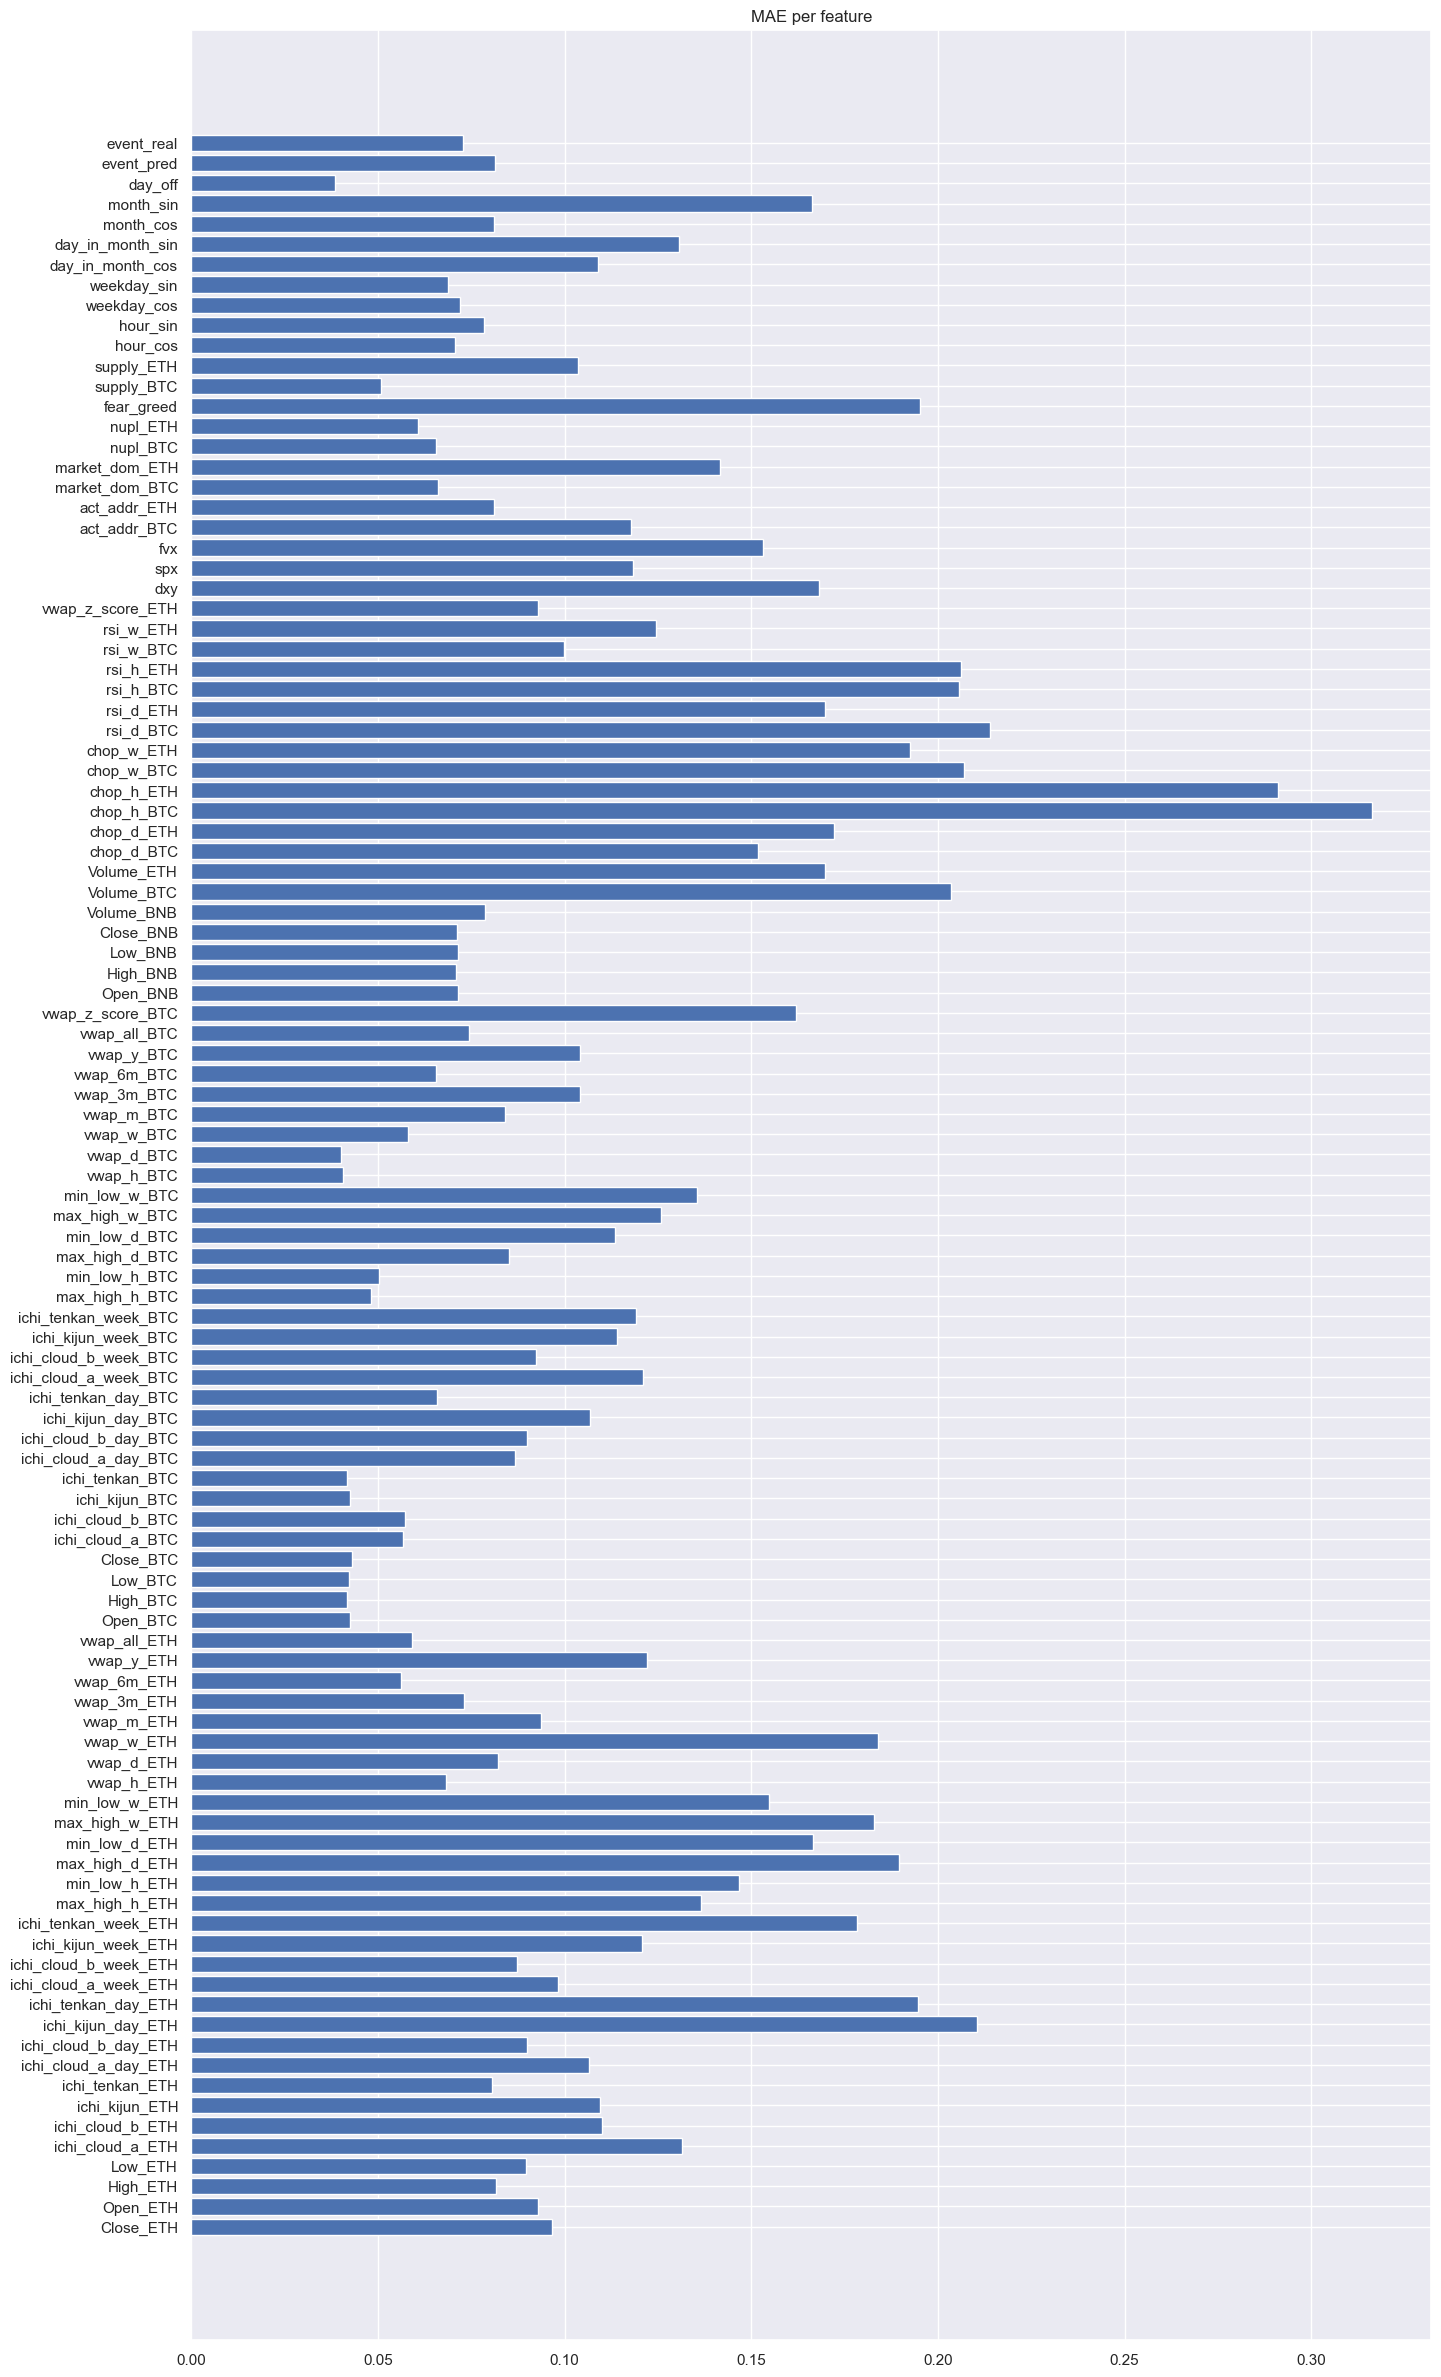

In [101]:
plt.figure(figsize=(16, 30))
plt.barh(df_mae_train_feat.columns, df_mae_train_feat.values[0])
plt.title("MAE per feature")

In [102]:
# X_train_raw
# X_train[0,:10, 0] * X_train_raw[0,-1, 0]
# [samples, lags, features]
print(X_train[:,0, 0].shape)
print(X_train_raw[:,-1, 0].shape)
print(X_train[:,0, 0] * X_train_raw[:,-1, 0])
print(df_feat["Close_ETH"].values[:3])

(50831,)
(50831,)
[1196.32 1195.38 1194.55 ... 1879.81 1880.43 1880.24]
[1196.32 1195.38 1194.55]


In [103]:
X_train_pred = scaler.inverse_transform(X_train_sca_pred.reshape(-1,X_train_sca_pred.shape[-1])).reshape(X_train_sca_pred.shape)
X_train_pred[:,-1,0]

array([1.000746 , 1.0012057, 1.001446 , ..., 0.9998488, 1.000382 ,
       1.0002491], dtype=float32)

[1196.32 1195.38 1194.55 ... 1879.81 1880.43 1880.24]
[1194.42529659 1194.84267932 1194.78816926 ... 1878.8410211  1878.11000626
 1877.99476969]


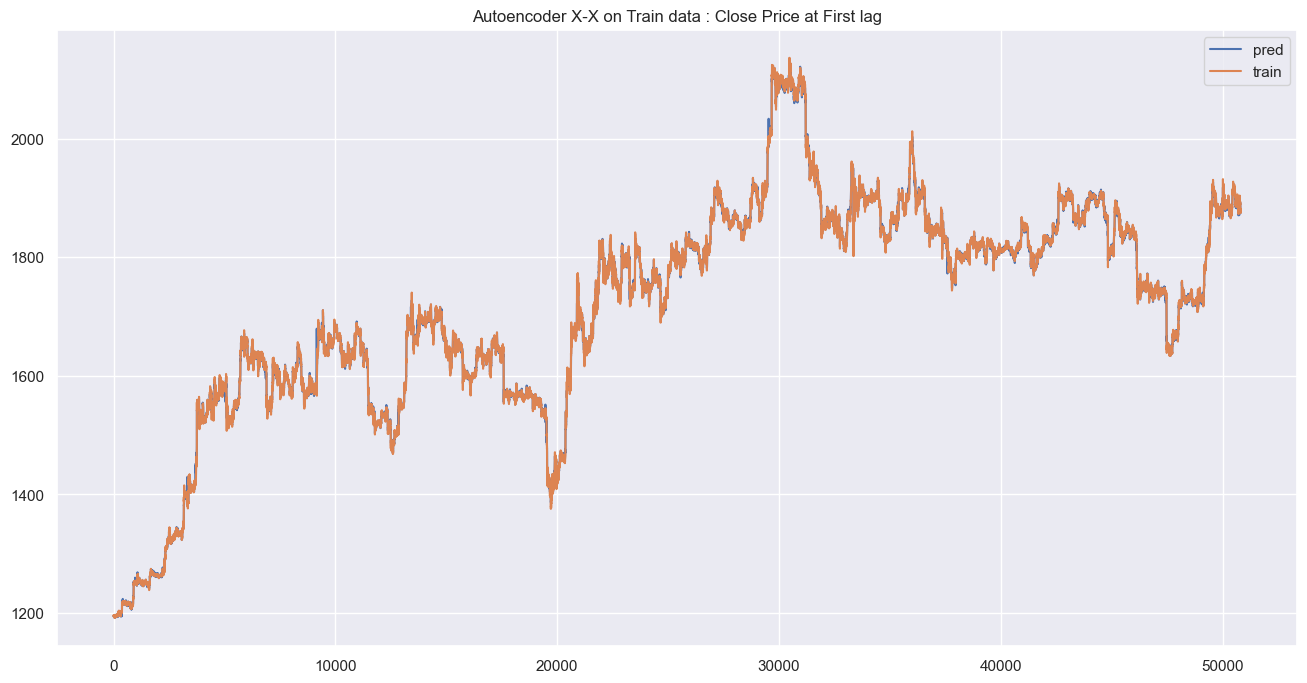

In [104]:
print(X_train_raw[:,0, 0])
print(X_train_pred[:,0, 0] * X_train_raw[:,-1, 0])

fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Train data : Close Price at First lag")
plt.plot(X_train_pred[:,0, 0] * X_train_raw[:,-1, 0], label="pred")
plt.plot(X_train_raw[:,0,0], label="train")
plt.legend(loc='upper right')

#### on Test data

In [105]:
X_test_sca_pred = autoencoder.predict(X_test_sca)
X_test_sca_pred.shape

396/396 [==============================] - 8s 21ms/step


(12641, 72, 104)

In [106]:
df_feat["date_ETH"].iloc[TRAIN_SPLIT]

'2023-06-26 19:05:00'

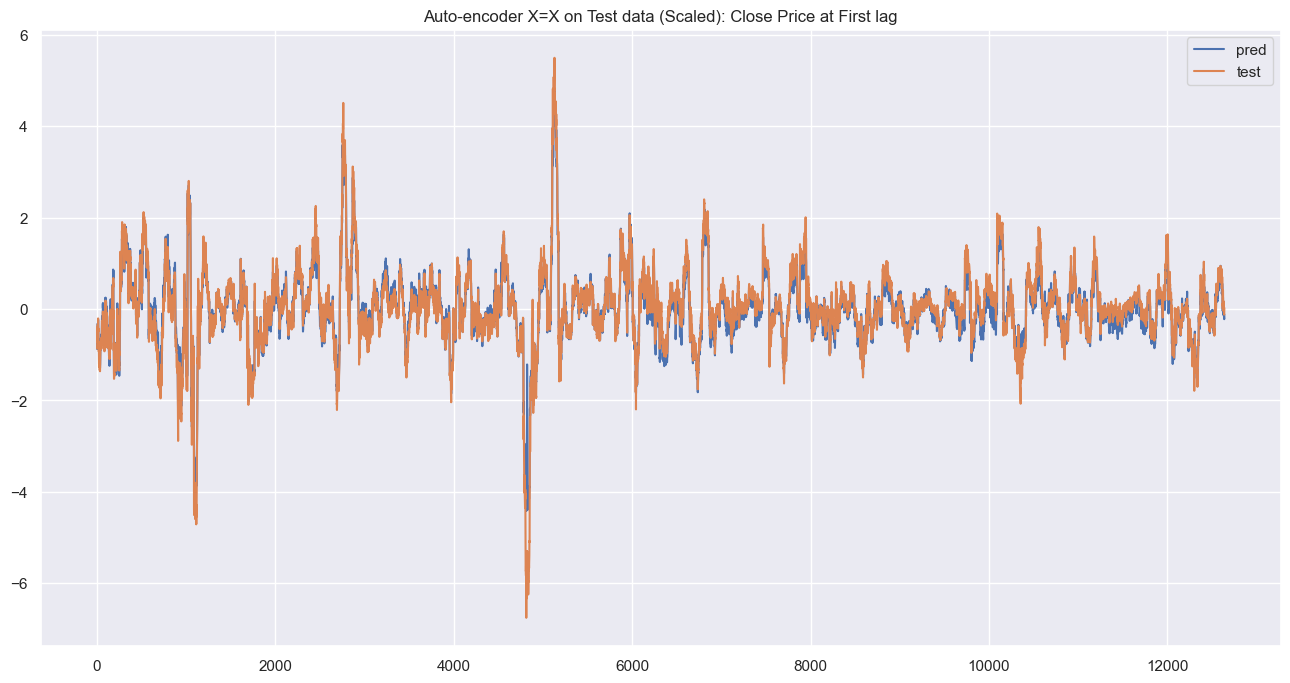

In [107]:
fig = plt.figure(figsize=(16, 8))
plt.title("Auto-encoder X=X on Test data (Scaled): Close Price at First lag")
plt.plot(X_test_sca_pred[:,0,0], label="pred")
plt.plot(X_test_sca[:,0,0], label="test")
plt.legend(loc='upper right')

In [108]:
# X  _raw : df feat raw data
# X : price normalized
# X  _sca : standardized use by model
# X      _pred : predict
X_test_pred = scaler.inverse_transform(X_test_sca_pred.reshape(-1,X_test_sca_pred.shape[-1])).reshape(X_test_sca_pred.shape)
print("X test raw  : ", X_test_raw[:,0, 0][:9])
print("X test pred : ", (X_test_pred[:,0,0] * X_test_raw[:,-1, 0])[:9])

X test raw  :  [1843.97 1846.43 1845.49 1846.15 1850.37 1853.78 1853.39 1855.43 1857.62]
X test pred :  [1843.85250005 1844.65954583 1844.94964717 1845.44644428 1849.77228934
 1852.86517919 1852.81455101 1855.81646388 1857.88082111]


[1843.97 1846.43 1845.49 ... 1852.16 1851.66 1853.94]
[1843.85250005 1844.65954583 1844.94964717 ... 1850.50270822 1849.93932158
 1851.42169082]


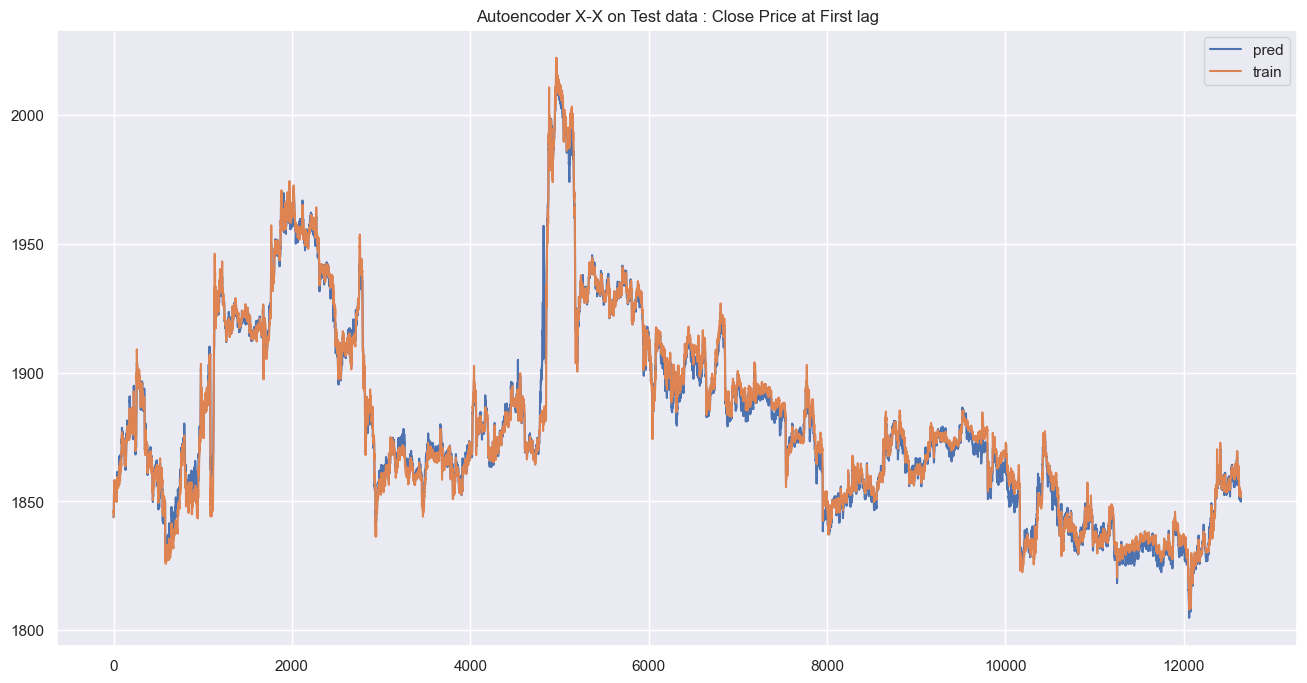

In [109]:
print(X_test_raw[:,0, 0])
print(X_test_pred[:,0, 0] * X_test_raw[:,-1, 0])

fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Test data : Close Price at First lag")
plt.plot(X_test_pred[:,0, 0] * X_test_raw[:,-1, 0], label="pred")
plt.plot(X_test_raw[:,0,0], label="train")
plt.legend(loc='upper right')

In [110]:
X_test_sca.shape

(12641, 72, 104)

In [111]:
mean_absolute_error(X_test_sca[:,0,:], X_test_sca_pred[:,0,:])

0.38392689383300405

In [112]:
print(X_test_sca_pred.shape) 
print(X_test_sca.shape)
mae_ae_test = np.mean(np.abs(X_test_sca_pred - X_test_sca), 0)
print(mae_ae_test.shape)
mae_ae_test_feat = np.mean(mae_ae_test, 0)[np.newaxis,:]
print(mae_ae_test_feat.shape)
df_mae_ae_test = pd.DataFrame(mae_ae_test, columns=list_col_select)
df_mae_ae_test.index = [f"lag_{i_lag}" for i_lag in range(len(df_mae_ae_test.index))]
df_mae_ae_test_feat = pd.DataFrame(mae_ae_test_feat, columns=list_col_select)
df_mae_ae_test["dataset"] = "TEST"
df_mae_train["dataset"] = "TRAIN"
df_mae_ae_comp = pd.concat([df_mae_train, df_mae_ae_test], ignore_index=False)
df_mae_ae_comp

(12641, 72, 104)
(12641, 72, 104)
(72, 104)
(1, 104)


Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
lag_0    0.119113  0.128392  0.112599  0.116738          0.170482   
lag_1    0.102663  0.101601  0.090473  0.094330          0.149794   
lag_2    0.097514  0.097119  0.083773  0.090080          0.143194   
lag_3    0.095921  0.094814  0.081677  0.088564          0.138886   
lag_4    0.095975  0.093717  0.080897  0.088572          0.136418   
...           ...       ...       ...       ...               ...   
lag_67   0.093690  0.089978  0.084629  0.115351          0.141069   
lag_68   0.093224  0.089592  0.084253  0.115029          0.140976   
lag_69   0.092779  0.089365  0.083859  0.114612          0.140922   
lag_70   0.092487  0.088795  0.083422  0.114199          0.140875   
lag_71   0.092002  0.088474  0.083063  0.113871          0.140841   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
lag_0           0.158299        0.135849         0.120036   
lag_1           0.133967        0.123725         0.101528   
lag_2           0.124247        0.120414         0.095317   
lag_3           0.118227        0.117516         0.090331   
lag_4           0.114319        0.115747         0.087138   
...                  ...             ...              ...   
lag_67          0.108119        0.089481         0.073922   
lag_68          0.108038        0.089149         0.073538   
lag_69          0.108005        0.088816         0.073193   
lag_70          0.107933        0.088528         0.072816   
lag_71          0.107891        0.088333         0.072493   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  weekday_cos  \
lag_0               0.142091              0.115146  ...     0.162918   
lag_1               0.121542              0.101928  ...     0.109096   
lag_2               0.115365              0.097108  ...     0.090996   
lag_3               0.111844              0.094303  ...     0.082443   
lag_4               0.110542              0.092429  ...     0.078192   
...                      ...                   ...  ...          ...   
lag_67              0.373875              0.249620  ...     0.146855   
lag_68              0.373857              0.249580  ...     0.146846   
lag_69              0.373836              0.249533  ...     0.146832   
lag_70              0.373815              0.249486  ...     0.146841   
lag_71              0.373792              0.249440  ...     0.146851   

        weekday_sin  day_in_month_cos  day_in_month_sin  month_cos  month_sin  \
lag_0      0.153282          0.167424          0.180264   0.091466   0.186883   
lag_1      0.100864          0.138206          0.154645   0.087529   0.176719   
lag_2      0.083545          0.129076          0.145497   0.085392   0.169962   
lag_3      0.075496          0.125427          0.140487   0.084004   0.168394   
lag_4      0.074324          0.122224          0.137442   0.083350   0.167007   
...             ...               ...               ...        ...        ...   
lag_67     0.131481          0.333419          0.502102   0.257953   1.386129   
lag_68     0.131451          0.333418          0.502155   0.258059   1.386235   
lag_69     0.131439          0.333420          0.502197   0.258168   1.386339   
lag_70     0.131433          0.333431          0.502249   0.258265   1.386446   
lag_71     0.131438          0.333432          0.502293   0.258366   1.386553   

         day_off  event_pred  event_real  dataset  
lag_0   0.129909    0.221769    0.079399    TRAIN  
lag_1   0.082216    0.131576    0.079749    TRAIN  
lag_2   0.064253    0.097078    0.078755    TRAIN  
lag_3   0.055994    0.094332    0.077325    TRAIN  
lag_4   0.050566    0.093128    0.076411    TRAIN  
...          ...         ...         ...      ...  
lag_67  0.106222    0.100830    0.107109     TEST  
lag_68  0.106163    0.100788    0.107105     TEST  
lag_69  0.106100    0.100770    0.107108     TEST  
lag_70  0.106033    0.100767    0.107111     TEST  
lag_71  0.105962    0.100752    0.10

In [113]:
df_mae_ae_test_feat

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0   0.104565  0.099606  0.094358  0.124721          0.144438   

   ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0          0.115261        0.098533         0.085596              0.356231   

   ichi_cloud_b_day_ETH  ...  hour_sin  weekday_cos  weekday_sin  \
0              0.240137  ...  0.207416     0.148629     0.142121   

   day_in_month_cos  day_in_month_sin  month_cos  month_sin  day_off  \
0          0.340912          0.517998   0.255105   1.395716  0.11333   

   event_pred  event_real  
0    0.112496    0.107479  

[1 rows x 104 columns]

Text(0.5, 1.0, 'MAE per feature on TEST')

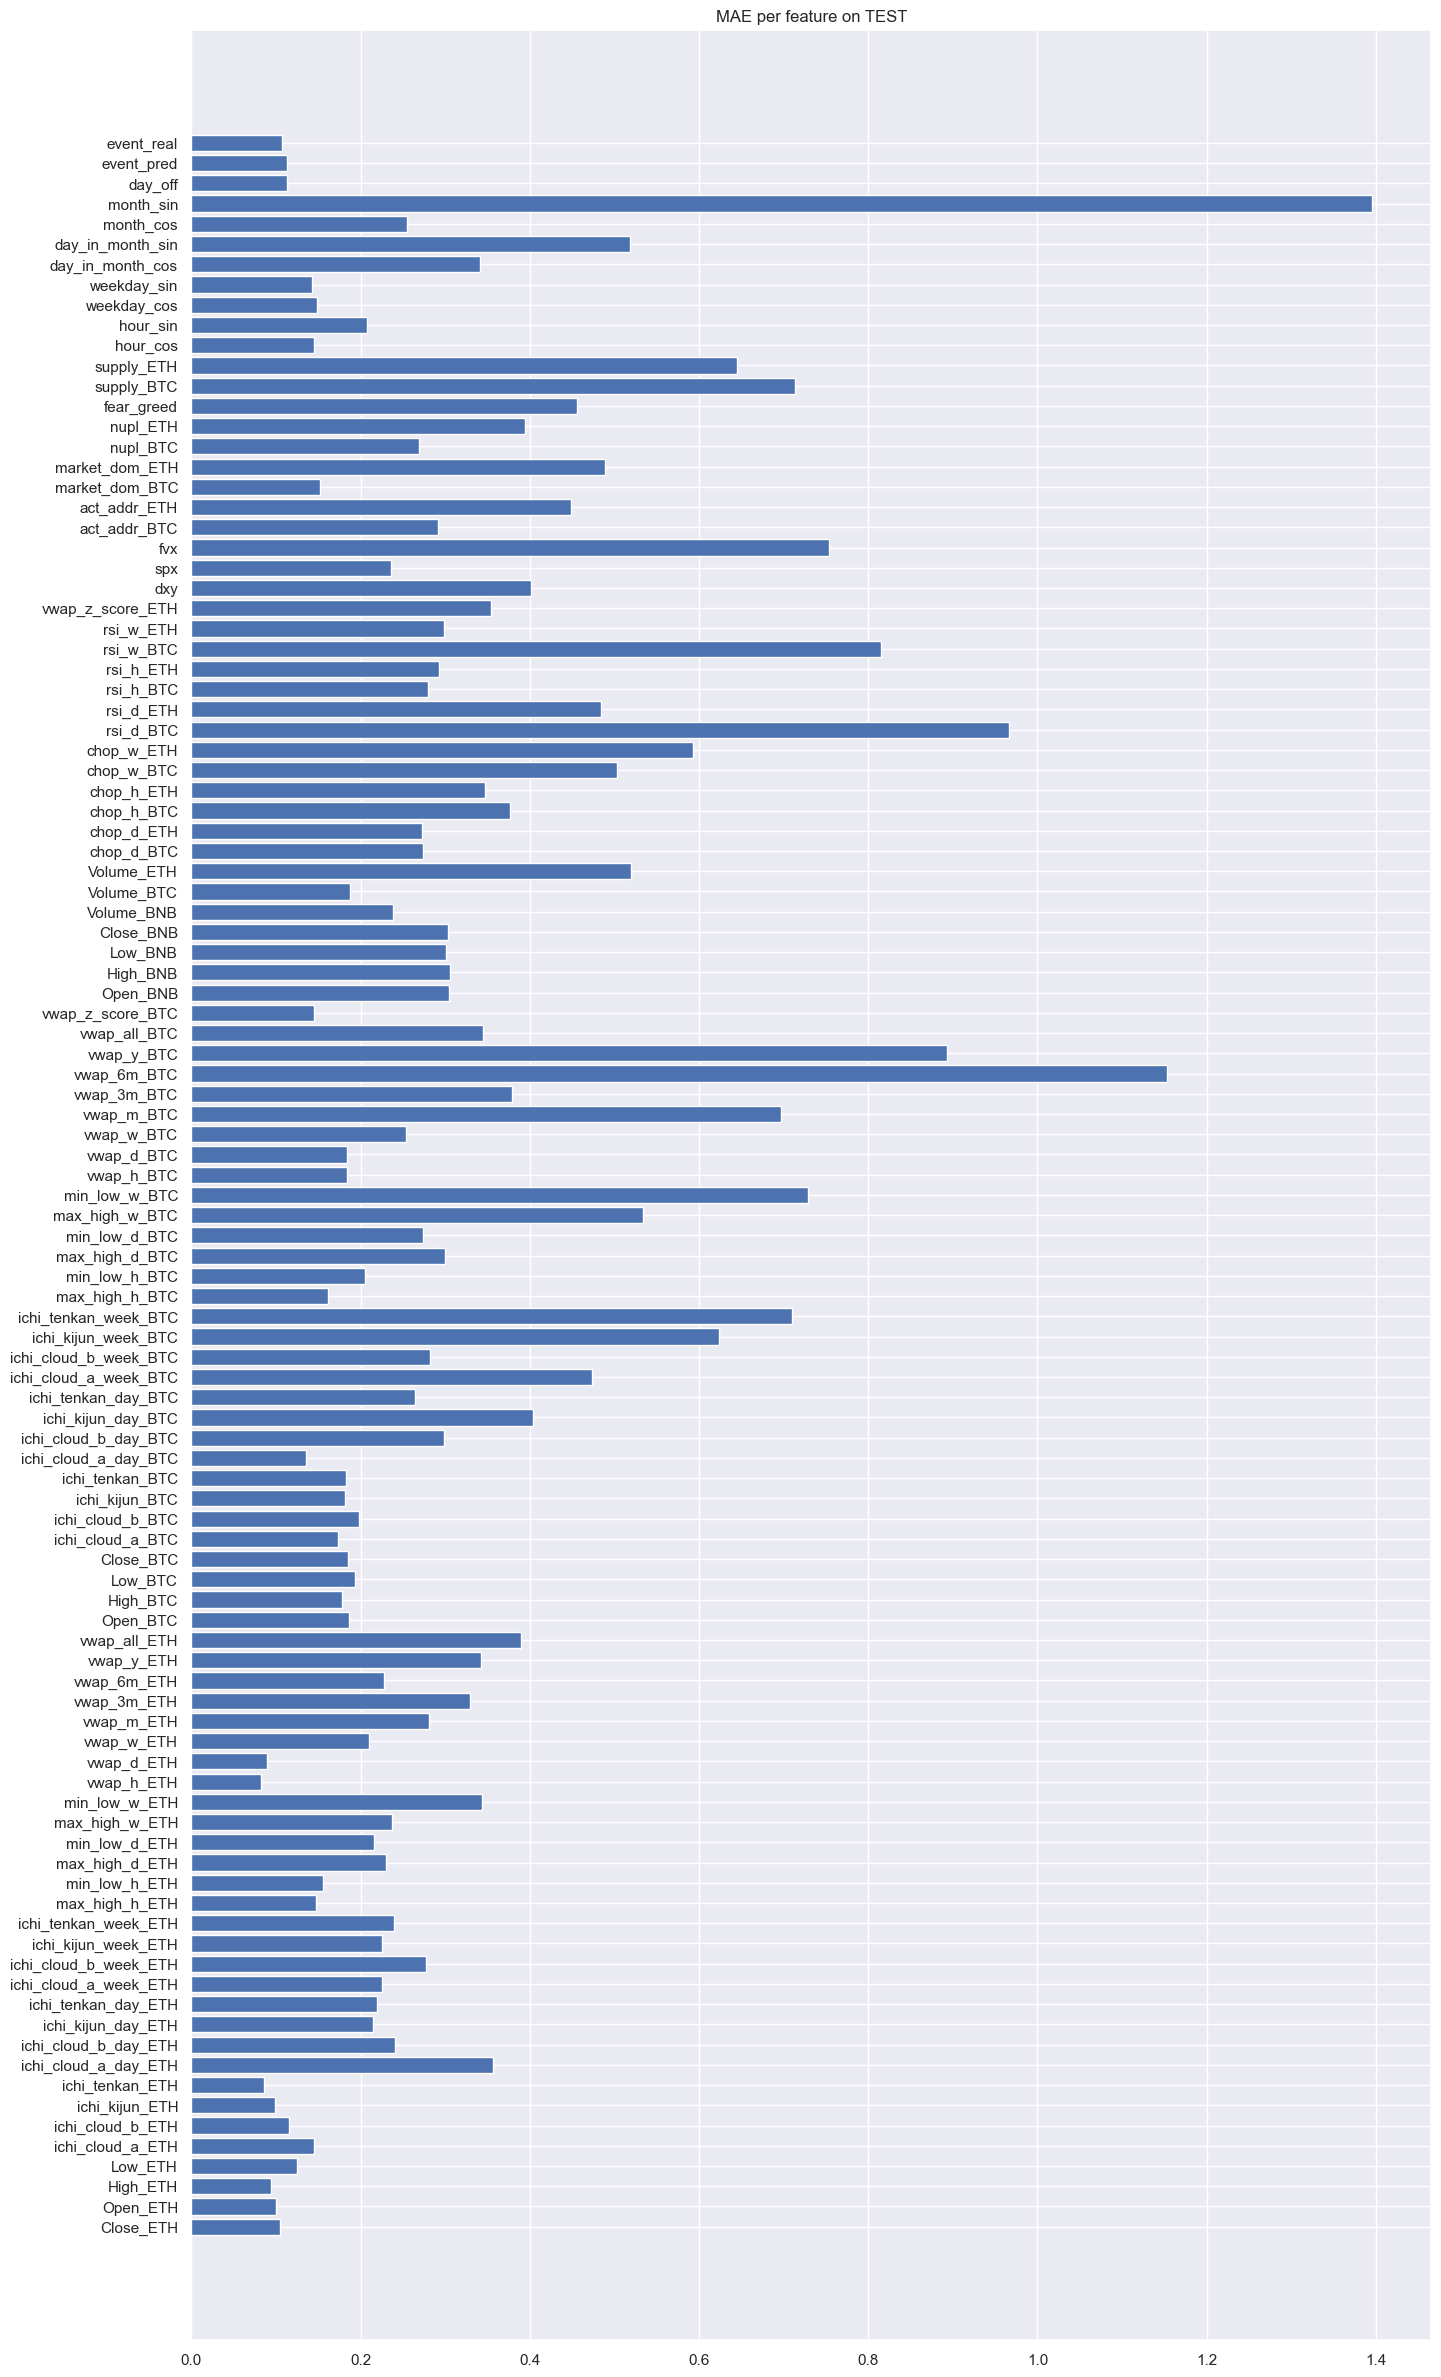

In [114]:
plt.figure(figsize=(16, 30))
plt.barh(df_mae_ae_test_feat.columns, df_mae_ae_test_feat.values[0])
plt.title("MAE per feature on TEST")

In [115]:
df_mae_ae_test_feat.values[0]

array([0.10456534, 0.09960552, 0.0943577 , 0.12472059, 0.14443799,
       0.11526099, 0.09853267, 0.08559603, 0.35623142, 0.24013742,
       0.21453745, 0.21911585, 0.22559935, 0.27679105, 0.22502088,
       0.23987269, 0.14724114, 0.15557979, 0.23003391, 0.21582505,
       0.23726527, 0.34341604, 0.08275484, 0.089378  , 0.20965542,
       0.28109781, 0.32913939, 0.22830855, 0.34240834, 0.38948527,
       0.18581713, 0.17850354, 0.1938115 , 0.18556994, 0.17277472,
       0.19845351, 0.18138061, 0.18290276, 0.1358801 , 0.29910568,
       0.40344417, 0.26389012, 0.47327973, 0.28264439, 0.62345416,
       0.70998383, 0.16148614, 0.20525384, 0.30019023, 0.27359593,
       0.53400962, 0.72915802, 0.18357966, 0.18364703, 0.2531514 ,
       0.69648449, 0.37895078, 1.15361233, 0.89293682, 0.34449823,
       0.14521617, 0.30421838, 0.30567971, 0.30059333, 0.3029774 ,
       0.23850781, 0.18748884, 0.51963236, 0.2739528 , 0.27255398,
       0.37629213, 0.34756767, 0.50336071, 0.59253106, 0.96622

In [116]:
2/df_mae_ae_test_feat.values[0].sum()

0.05881288133032961

In [117]:
df_comp = df_mae_ae_comp.melt(id_vars=["dataset"], value_vars=list_col_select, value_name="MAE")
df_comp

dataset    variable       MAE
0       TRAIN   Close_ETH  0.119113
1       TRAIN   Close_ETH  0.102663
2       TRAIN   Close_ETH  0.097514
3       TRAIN   Close_ETH  0.095921
4       TRAIN   Close_ETH  0.095975
...       ...         ...       ...
14971    TEST  event_real  0.107109
14972    TEST  event_real  0.107105
14973    TEST  event_real  0.107108
14974    TEST  event_real  0.107111
14975    TEST  event_real  0.107118

[14976 rows x 3 columns]

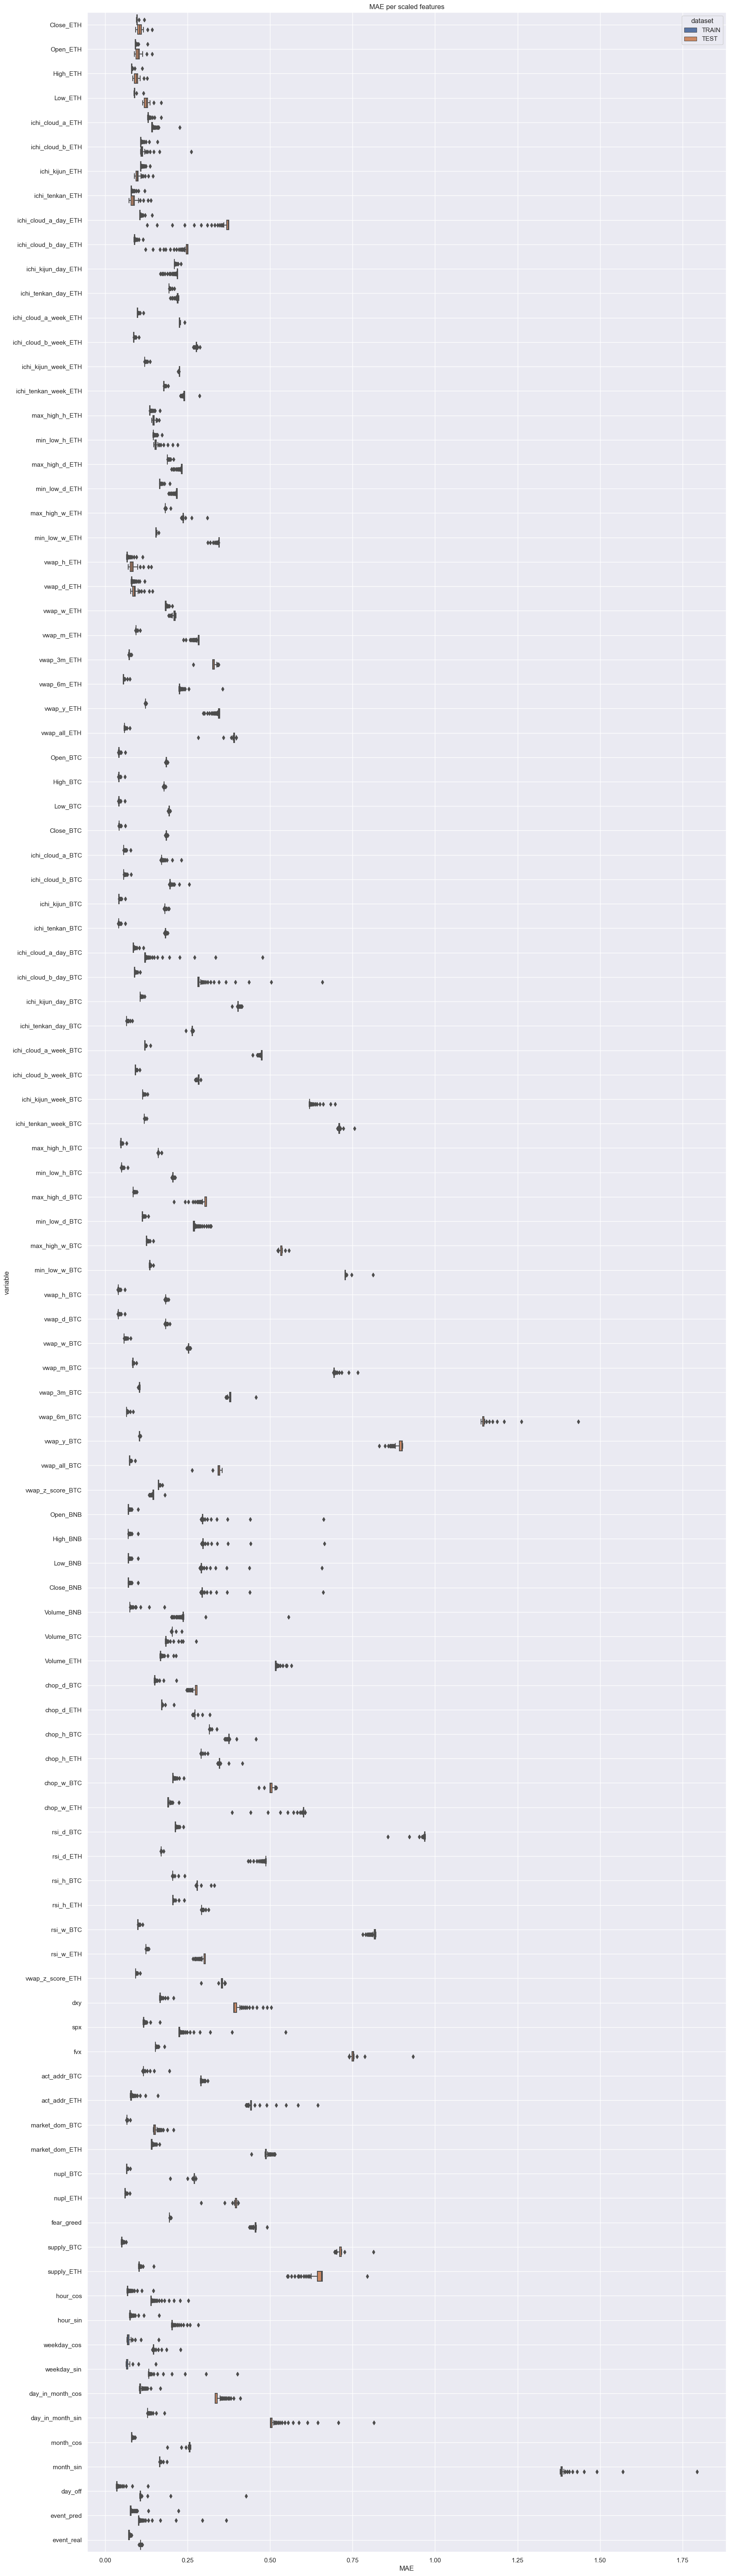

In [118]:
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_comp, x="MAE", y="variable" , hue="dataset")
fig = plt.gcf()
ax = fig.gca()
ax.yaxis.grid(True)
#ax.set_xlim([-30,30])
plt.title("MAE per scaled features")

name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE_MAE - {name_plt}.jpg")
)

In [119]:
encoder_model.layers[3].get_weights()

[]

## Prediction Models

### LSTM all features

In [120]:
X_train_sca.shape

(50831, 72, 104)

In [121]:
X_train_sca.shape[-1]

104

In [122]:
X_train_sca.shape[-2:]

(72, 104)

In [123]:
# Init
#NB_TRY = 50
#STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)
if MODE_TRAIN_LSTM:
    EPOCHS = 5
    patience = 0
    dropout_rate = 0.05
    n_units = 128
    seed = 0
    tf.keras.backend.clear_session()
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    # optimizer def 
    optim = tf.optimizers.Adam()

    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                    verbose=1, patience=patience,
                                    restore_best_weights=True)
    # create model
    multi_step_model_1 = tf.keras.models.Sequential()
    multi_step_model_1.add(tf.keras.layers.LSTM(n_units, 
                        return_sequences=False,
                        input_shape=X_train_sca.shape[-2:],
                        dropout=dropout_rate))
    multi_step_model_1.add(tf.keras.layers.LayerNormalization())
    multi_step_model_1.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
    # compile
    multi_step_model_1.compile(optimizer=optim, loss='mse')
    # fitting
    if patience == 0:
        multi_step_history_1 = multi_step_model_1.fit(
            X_train_sca, y_train_sca, epochs=EPOCHS, 
            batch_size=BATCH_SIZE, 
            validation_data=(X_test_sca,y_test_sca), verbose=1
        )
    else:
        multi_step_history_1 = multi_step_model_1.fit(
            X_train_sca, y_train_sca, epochs=EPOCHS, 
            batch_size=BATCH_SIZE, 
            validation_data=(X_test_sca,y_test_sca), verbose=1, callbacks=[es])

    # eval
    mse_curr_1 = np.min(multi_step_history_1.history['val_loss'])
    print("mse_curr_1 = ", mse_curr_1)
    # plot mse
    plot_train_history(multi_step_history_1,
                        'Multi Step Training and validation loss', "data")
    # save mdl
    multi_step_model_1.save(path_mdl_predict_lstm)
    # results
    # _train_sca -> unscaler -> _train -> multiply by  Close price last lag
    y_train_pred_1 = multi_step_model_1.predict(X_train_sca)
    y_train_pred_unscaled_1 = scaler_y.inverse_transform(y_train_pred_1.reshape(-1,y_train_pred_1.shape[-1])).reshape(y_train_pred_1.shape)
    y_train_pred_raw_1 = y_train_pred_unscaled_1 * X_train_raw[:,-1, 0][:, np.newaxis]

    y_test_pred_1 = multi_step_model_1.predict(X_test_sca)
    y_test_pred_unscaled_1 = scaler_y.inverse_transform(y_test_pred_1.reshape(-1,y_test_pred_1.shape[-1])).reshape(y_test_pred_1.shape)
    y_test_pred_raw_1 = y_test_pred_unscaled_1 * X_test_raw[:,-1, 0][:, np.newaxis]
    # plot predict TRAIN
    fig = plt.figure(figsize=(16, 8))
    plt.title("LSTM Prediction on TRAIN data : Close Price at 6th lag")
    plt.plot(y_train_pred_raw_1[:1000, 5], label="pred")
    plt.plot(y_train_raw[:1000, 5], label="TRAIN")
    plt.legend(loc='upper right')
    # plot predict TRAIN
    fig = plt.figure(figsize=(16, 8))
    plt.title("LSTM Prediction on TEST data : Close Price at 6th lag")
    plt.plot(y_test_pred_raw_1[:1000, 5], label="pred")
    plt.plot(y_test_raw[:1000, 5], label="TEST")
    plt.legend(loc='upper right')


### Autoencoder + LSTM reduced features

In [124]:
encoder_model = tf.keras.models.load_model(path_mdl_encoder)
encoder_model.layers

Concatenate 

In [125]:
X_train_encoded = encoder_model.predict(X_train_sca)
X_train_encoded.shape

1589/1589 [==============================] - 18s 11ms/step


(50831, 72, 32)

In [126]:
X_test_encoded = encoder_model.predict(X_test_sca)
X_test_encoded.shape

396/396 [==============================] - 5s 12ms/step


(12641, 72, 32)

In [127]:
if MODE_TRAIN_AE:
    scaler_enc = StandardScaler()
    X_train_encoded_sca = scaler_enc.fit_transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)

    X_test_encoded_sca = scaler_enc.transform(
        X_test_encoded.reshape(
            -1, 
            X_test_encoded.shape[-1]
        )
    ).reshape(X_test_encoded.shape)

    joblib.dump(scaler_enc, path_scaler_enc)
    
else:
    print("reloading scaler_enc...")
    scaler_enc = joblib.load(path_scaler_enc)
    X_train_encoded_sca = scaler_enc.transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)

    X_test_encoded_sca = scaler_enc.transform(
        X_test_encoded.reshape(
            -1, 
            X_test_encoded.shape[-1]
        )
    ).reshape(X_test_encoded.shape)    



reloading scaler_enc...


In [128]:
"""path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")
joblib.dump(scaler_enc, path_scaler_enc)
sc_enc = joblib.load(path_scaler_enc)
sc_enc.transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)"""

'path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")\njoblib.dump(scaler_enc, path_scaler_enc)\nsc_enc = joblib.load(path_scaler_enc)\nsc_enc.transform(\n        X_train_encoded.reshape(\n            -1, \n            X_train_encoded.shape[-1]\n        )\n    ).reshape(X_train_encoded.shape)'

In [129]:
"""# scale encoded data
scaler_enc = StandardScaler()
X_train_encoded_sca = scaler_enc.fit_transform(
    X_train_encoded.reshape(
        -1, 
        X_train_encoded.shape[-1]
    )
).reshape(X_train_encoded.shape)

X_test_encoded_sca = scaler_enc.transform(
    X_test_encoded.reshape(
        -1, 
        X_test_encoded.shape[-1]
    )
).reshape(X_test_encoded.shape)"""

'# scale encoded data\nscaler_enc = StandardScaler()\nX_train_encoded_sca = scaler_enc.fit_transform(\n    X_train_encoded.reshape(\n        -1, \n        X_train_encoded.shape[-1]\n    )\n).reshape(X_train_encoded.shape)\n\nX_test_encoded_sca = scaler_enc.transform(\n    X_test_encoded.reshape(\n        -1, \n        X_test_encoded.shape[-1]\n    )\n).reshape(X_test_encoded.shape)'

In [130]:
# _train_sca -> unscaler -> _train -> multiply by  Close price last lag
X_train_ = np.concatenate([X_train_sca[:,:,0:4], X_train_encoded_sca], axis=-1)
X_test_ = np.concatenate([X_test_sca[:,:,0:4], X_test_encoded_sca], axis=-1)

X_train_.shape, X_test_.shape

((50831, 72, 36), (12641, 72, 36))

#### Correlations

In [131]:
list_col_enc =  [f"enc_{i_enc}" for i_enc in range(encoding_dim)]
list_col_ae = list_col_select[:4] + list_col_enc
nb_plot = len(list_col_ae)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_ae + list_col_targets

list_corr = []
for i_lag in range(X_train_.shape[1]):

    df = pd.DataFrame(np.hstack((X_train_[:,i_lag,:], y_train)), 
        columns=list_col_corr)
    # Calculer la matrice de corrélation
    corr_matrix = df.corr()
    if len(list_corr) > 0:
        corr_matrix_min = list_corr[-1].combine(corr_matrix, np.minimum)
        corr_matrix_max = list_corr[-1].combine(corr_matrix, np.maximum)
    
    list_corr.append(corr_matrix)



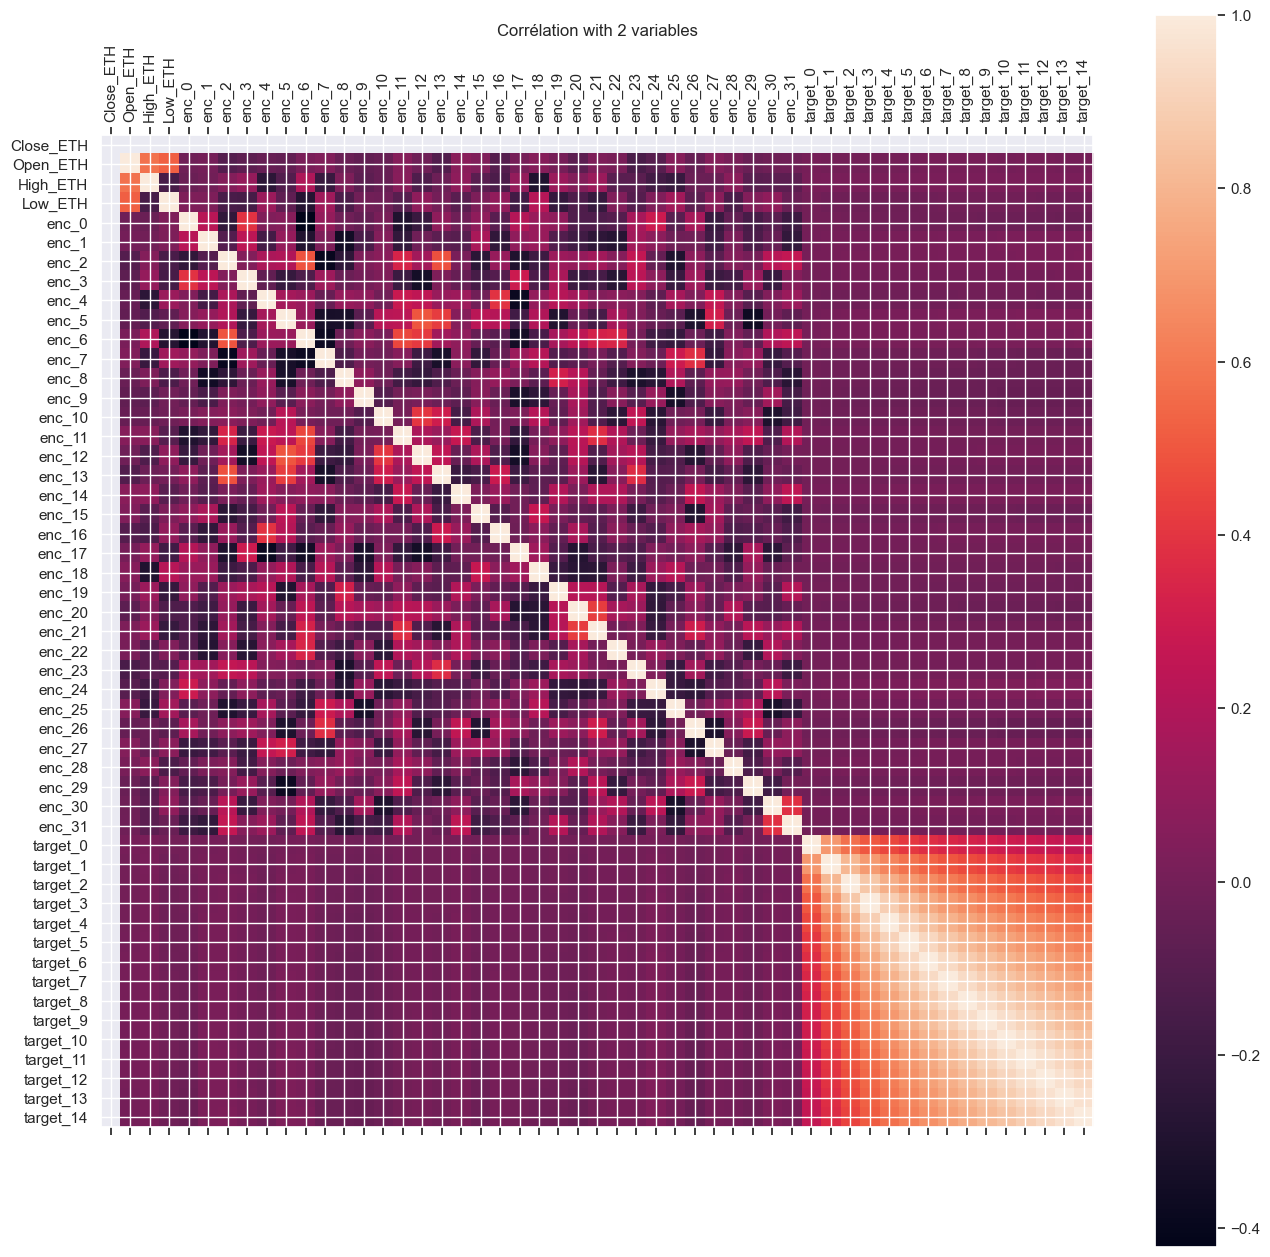

In [132]:
fig = plot_corr(corr_matrix_min)

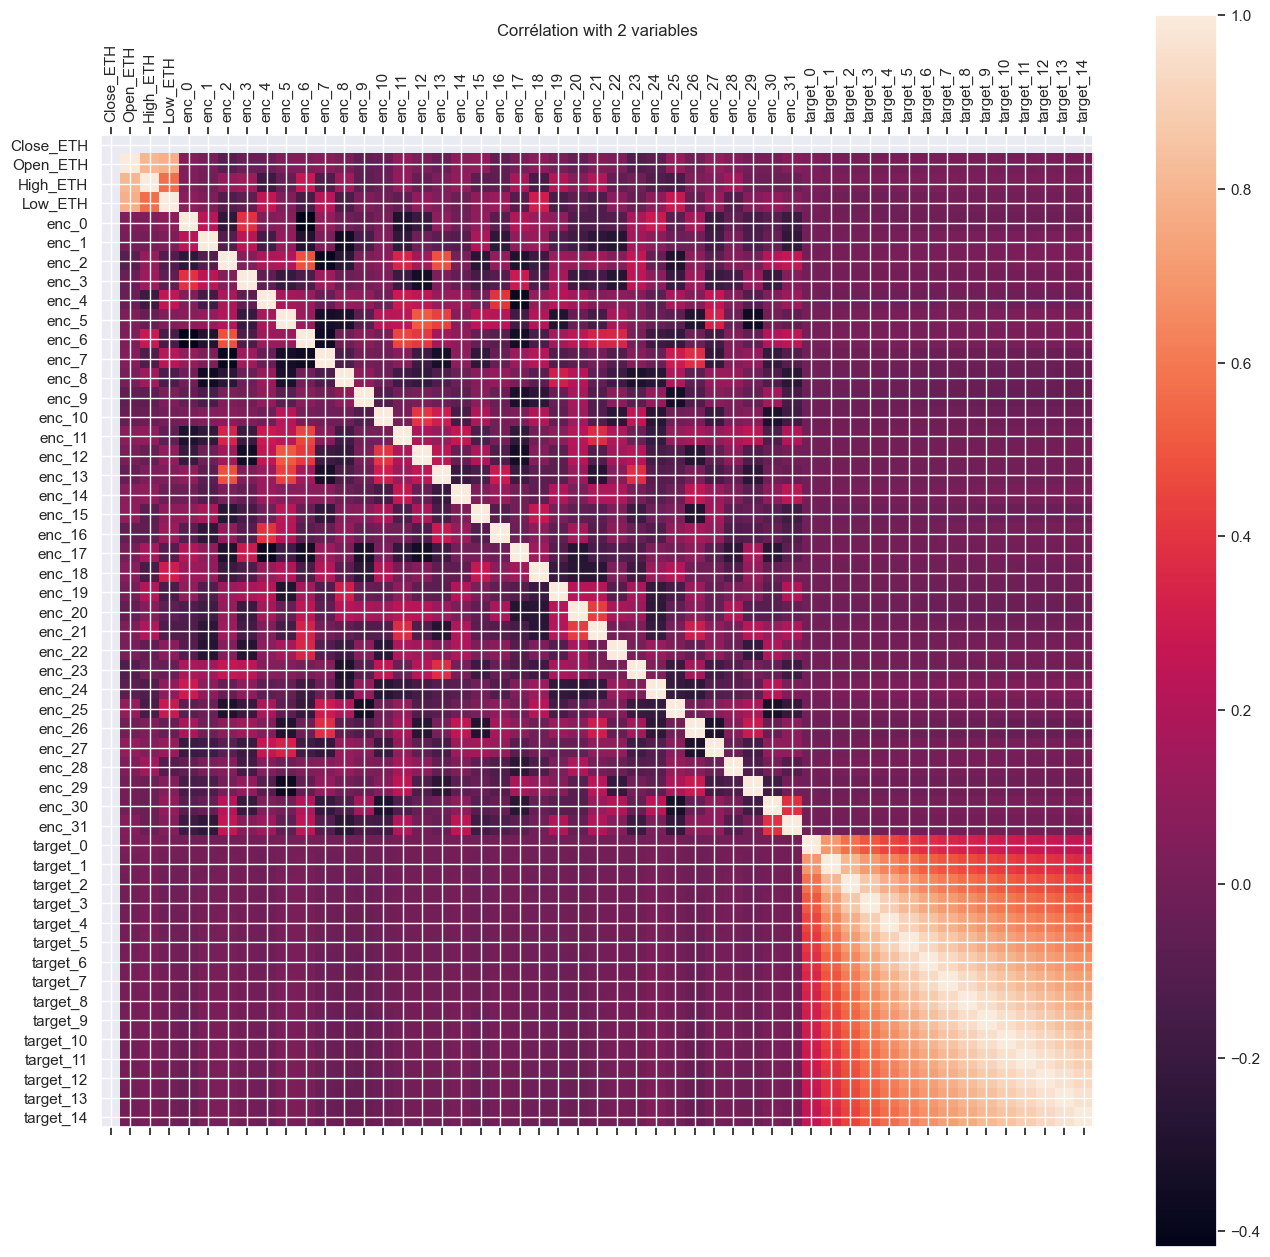

In [133]:
fig = plot_corr(corr_matrix_max) 

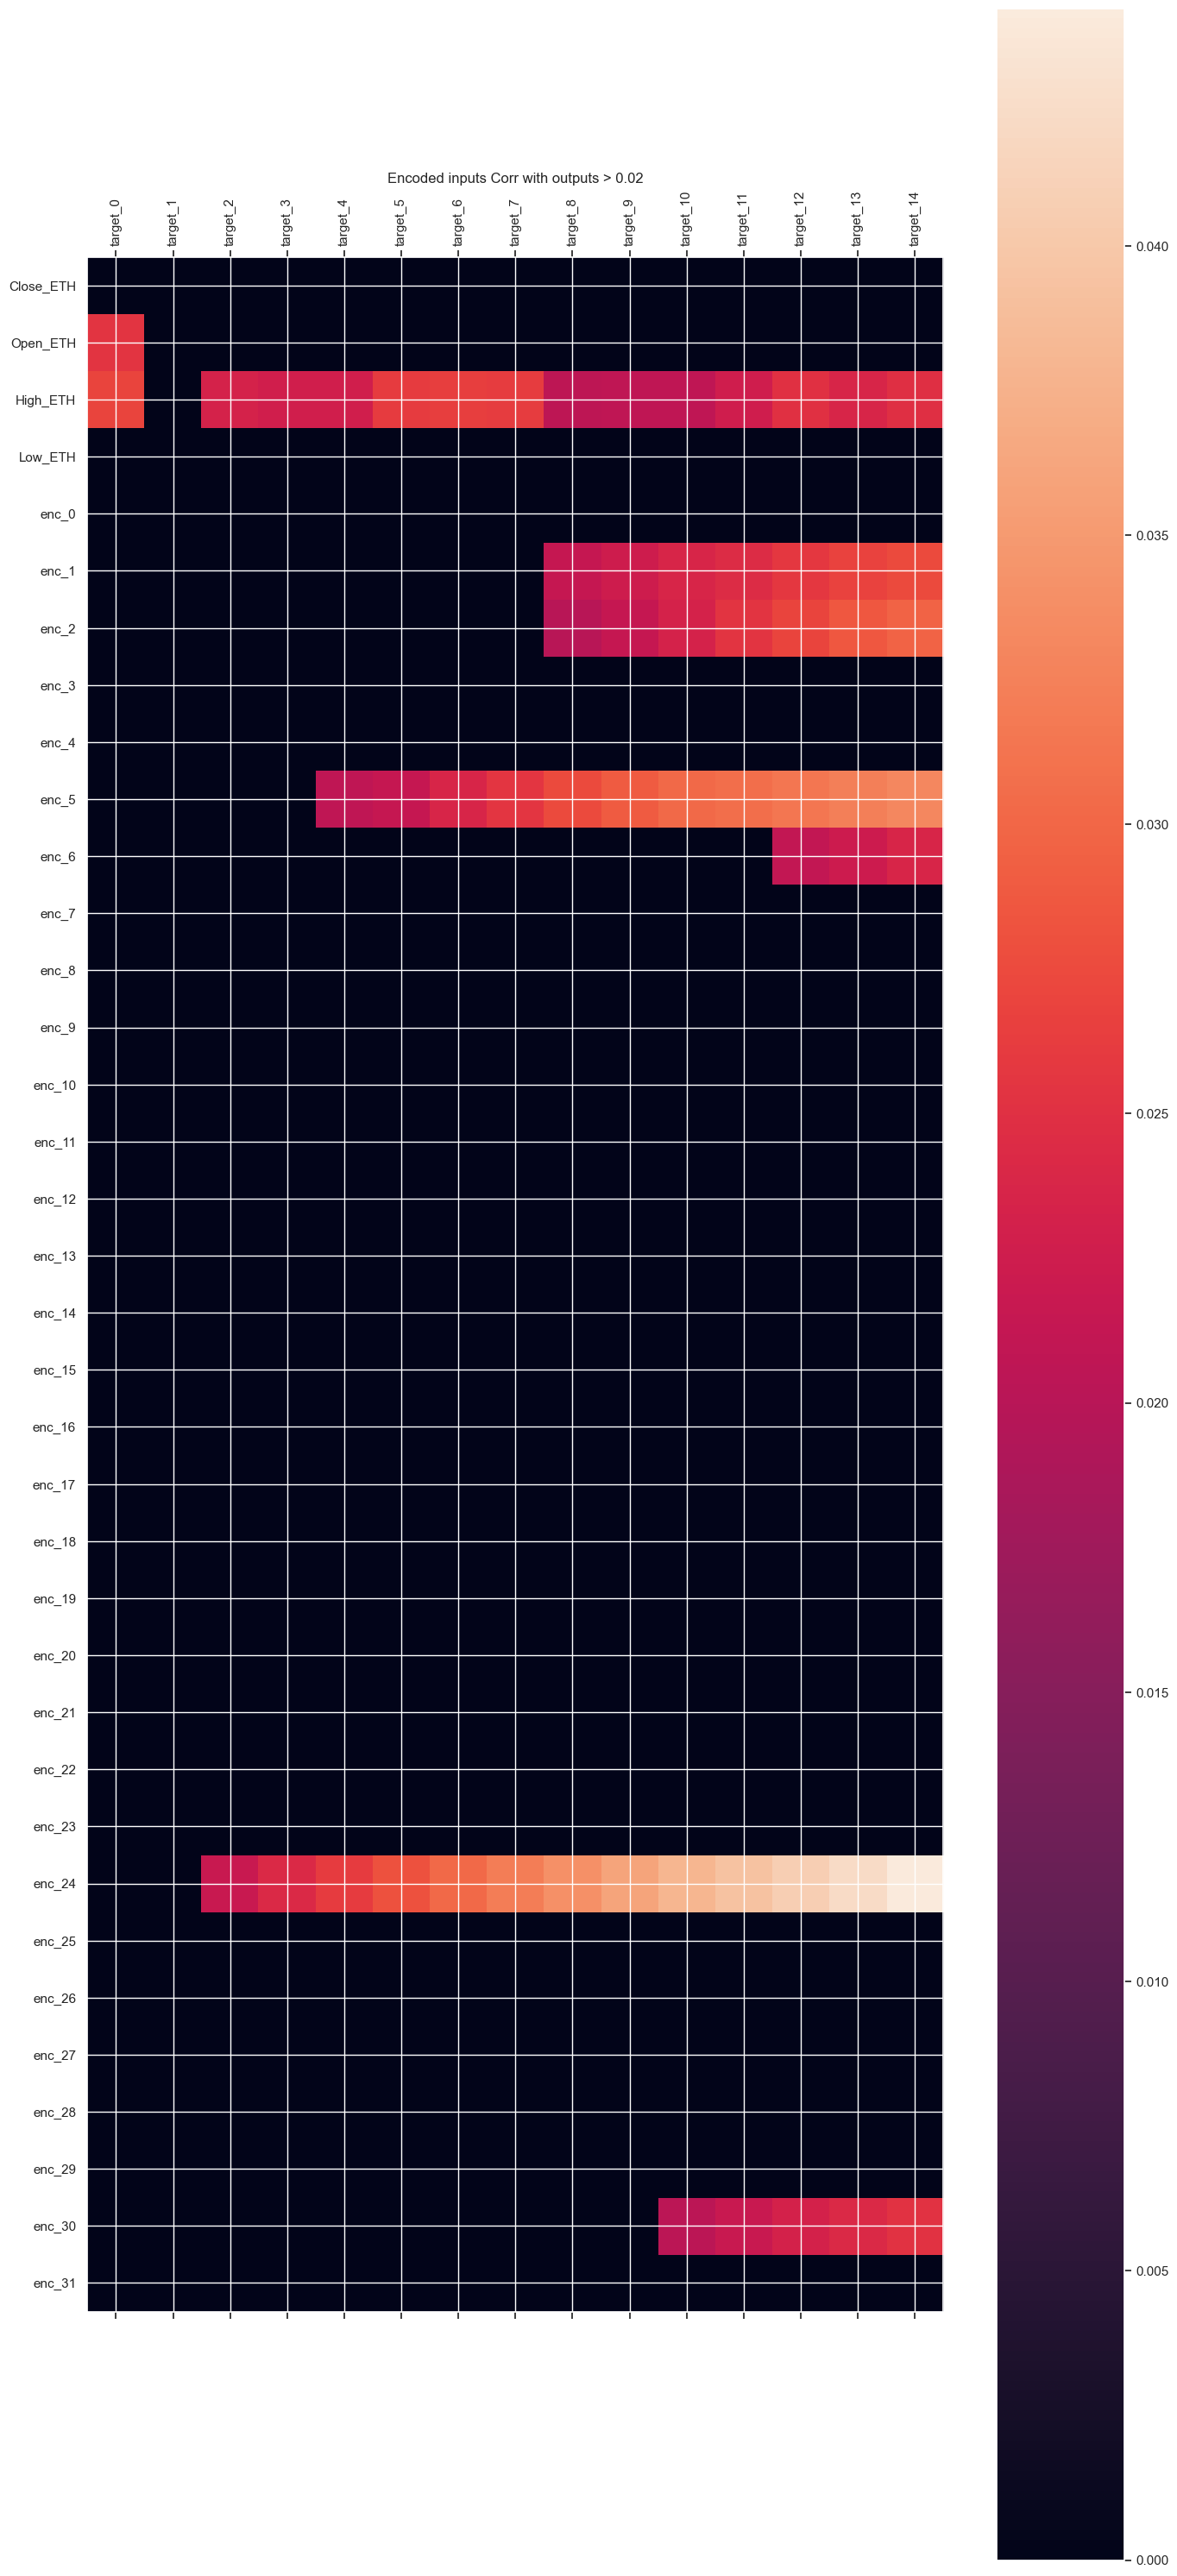

In [134]:
corr_matrix_targets_max = corr_matrix_max.copy().loc[list_col_ae, list_col_targets]
fig = plot_corr(corr_matrix_targets_max.where(corr_matrix_targets_max>0.02, 0), "Encoded inputs Corr with outputs > 0.02")

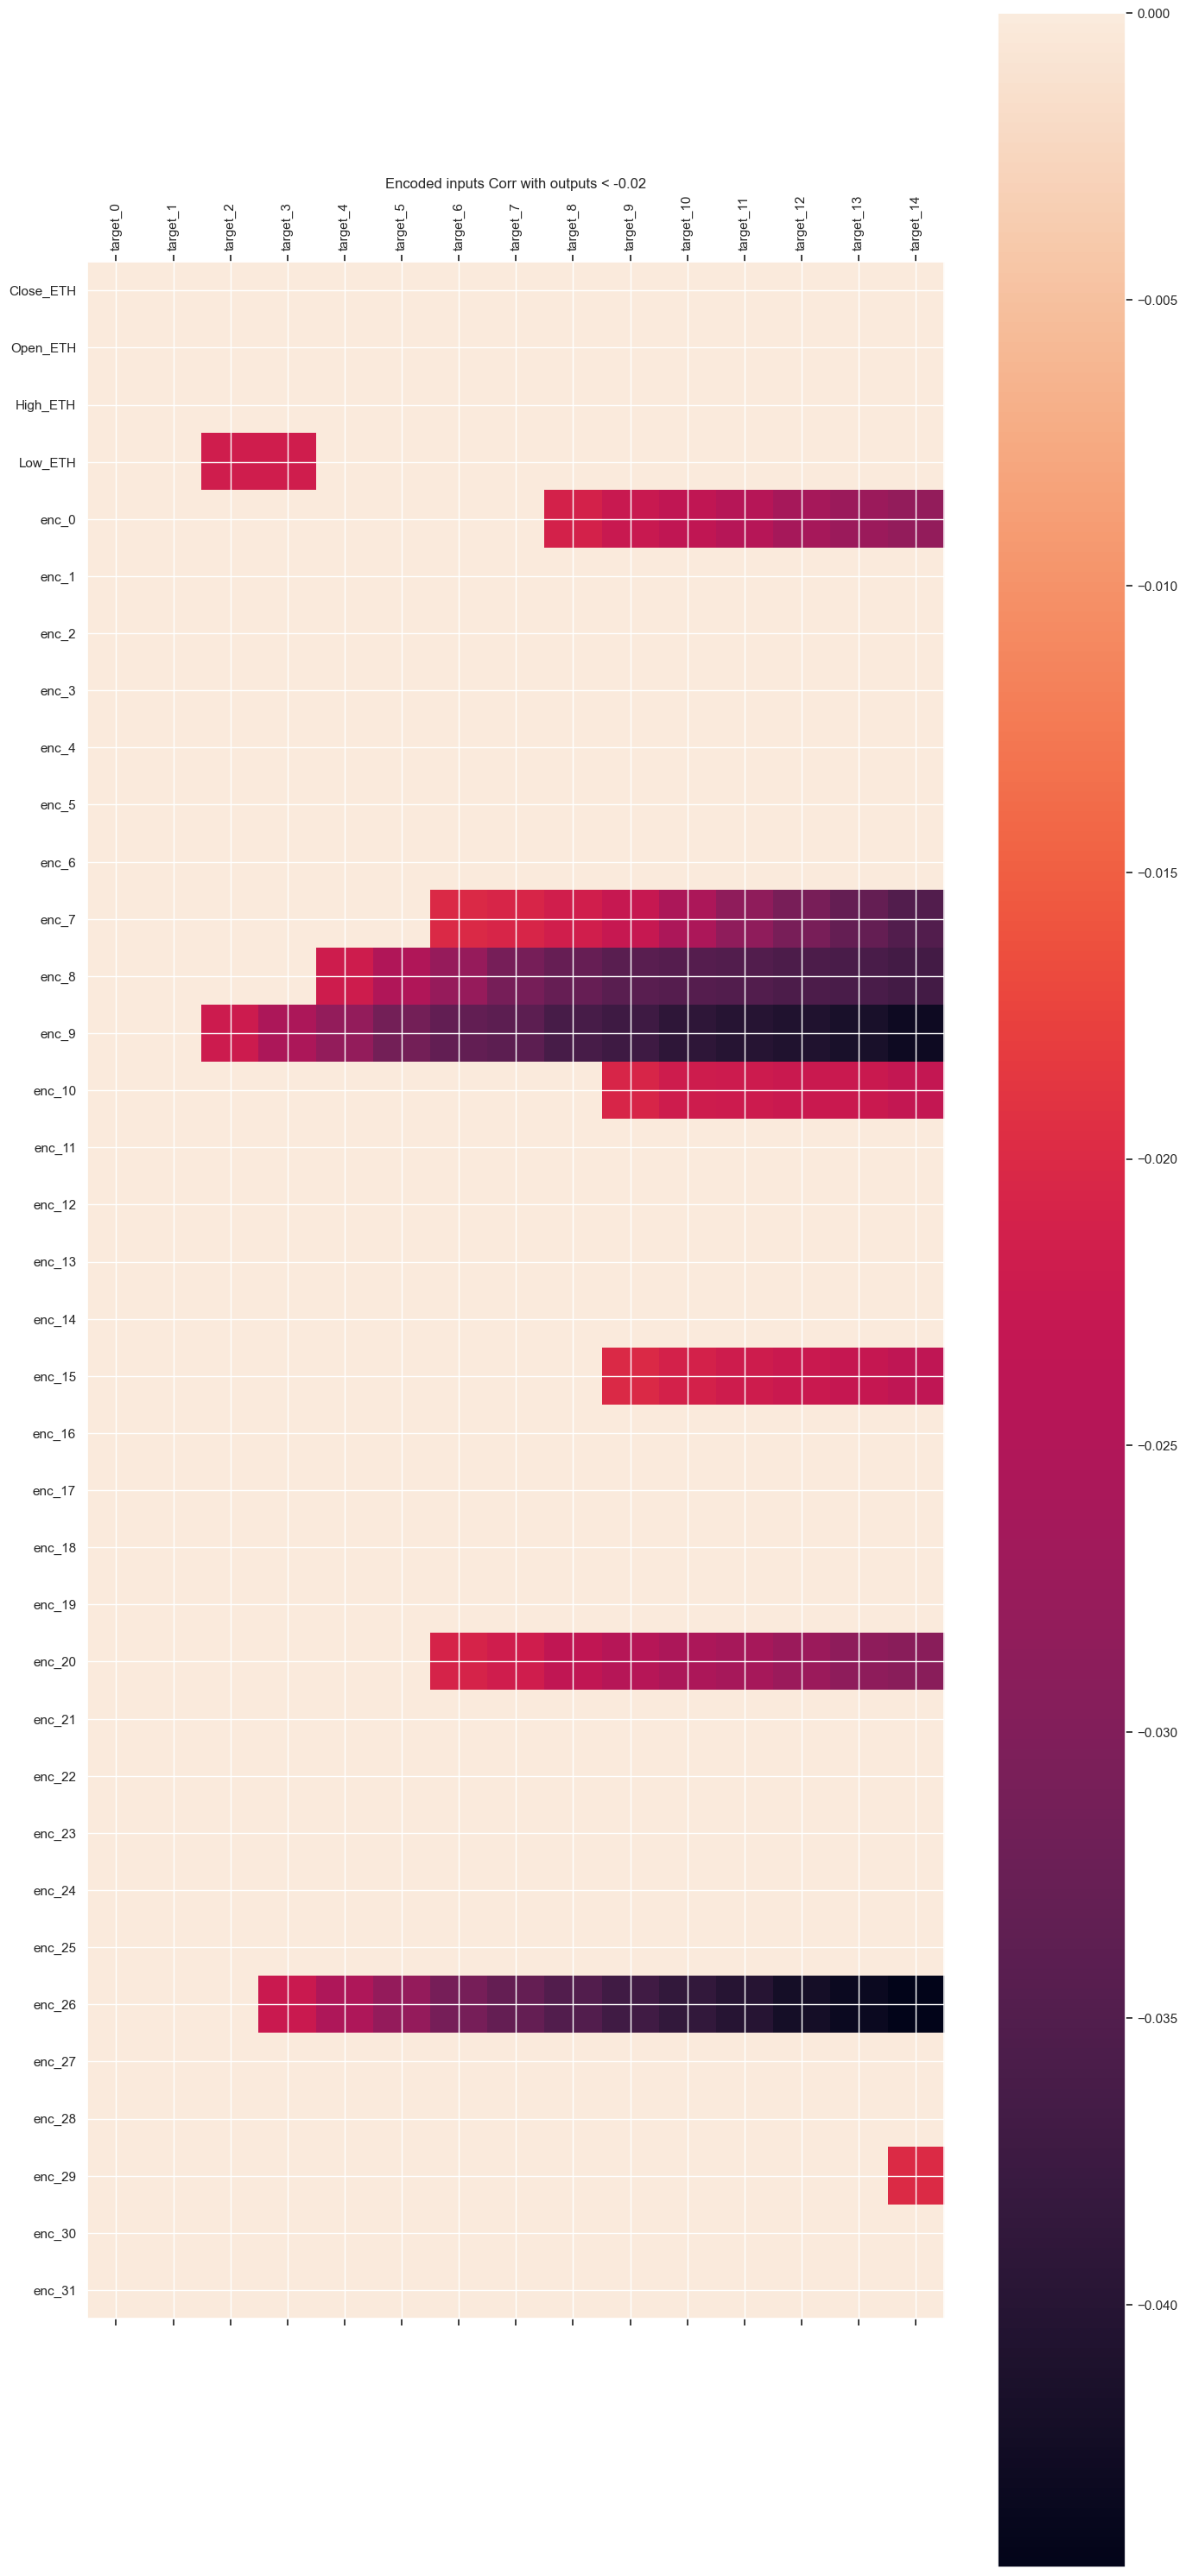

In [135]:
corr_matrix_targets_min = corr_matrix_min.copy().loc[list_col_ae, list_col_targets]
fig = plot_corr(corr_matrix_targets_min.where(corr_matrix_targets_min < -0.02, 0), "Encoded inputs Corr with outputs < -0.02")

In [136]:
"""list_col_enc =  [f"enc_{i_enc}" for i_enc in range(encoding_dim)]
list_col_ae = list_col_select[:4] + list_col_enc
nb_plot = len(list_col_ae)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_ae + list_col_targets

# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), 
#    columns=list_col_select[:nb_plot] + ['target'])
df = pd.DataFrame(np.hstack((X_train_[:,-1,:], y_train)), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df.corr()

fig = plot_corr(corr_matrix)"""

'list_col_enc =  [f"enc_{i_enc}" for i_enc in range(encoding_dim)]\nlist_col_ae = list_col_select[:4] + list_col_enc\nnb_plot = len(list_col_ae)\nlist_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]\nlist_col_corr = list_col_ae + list_col_targets\n\n# Créer un DataFrame pandas à partir des données d\'entrée X et de la variable à prédire y\n#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), \n#    columns=list_col_select[:nb_plot] + [\'target\'])\ndf = pd.DataFrame(np.hstack((X_train_[:,-1,:], y_train)), \n    columns=list_col_corr)\n# Calculer la matrice de corrélation\ncorr_matrix = df.corr()\n\nfig = plot_corr(corr_matrix)'

In [137]:
"""corr_matrix_targets = corr_matrix.copy().loc[list_col_ae, list_col_targets]
fig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0), "Encoded inputs Corr with outputs > 0.02")"""


'corr_matrix_targets = corr_matrix.copy().loc[list_col_ae, list_col_targets]\nfig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0), "Encoded inputs Corr with outputs > 0.02")'

In [138]:
"""fig = plot_corr(
    corr_matrix_targets.where(corr_matrix_targets<-0.02, 0),
    "Encoded inputs Corr with outputs < -0.02",
)"""

'fig = plot_corr(\n    corr_matrix_targets.where(corr_matrix_targets<-0.02, 0),\n    "Encoded inputs Corr with outputs < -0.02",\n)'

#### Auto select features 

In [139]:
MODE_AUTO_SELECT

1

In [140]:
# select corr var [1, 2, 5, 7, 10, 11, 16, 19, 23, 24, 27, 28, 31]
def unique_list(list1):
    x = np.array(list1)
    return list(np.unique(x))

if MODE_AUTO_SELECT == 1:
    #list_col_enc_select = []
    list_i_enc_select = []
    for i_enc , col_enc in enumerate(list_col_enc):
        if (np.any(corr_matrix_targets_min.loc[col_enc].values <  -0.02) |
            np.any(corr_matrix_targets_max.loc[col_enc].values >  0.02)
            ):
            #list_col_enc_select.append(col_enc)
            list_i_enc_select.append(i_enc)
    list_i_enc_select = unique_list(list_i_enc_select)
    # save list
    save_list(list_i_enc_select, path_save_auto_select)

elif MODE_AUTO_SELECT == 2:
    list_i_enc_select = load_list(path_save_auto_select)
else:
    list_i_enc_select = list(range(X_train_encoded_sca.shape[-1]))


print(list_i_enc_select)
print("nb encoded features: ", len(list_i_enc_select))

[0, 1, 2, 5, 6, 7, 8, 9, 10, 15, 20, 24, 26, 29, 30]
nb encoded features:  15


In [141]:
X_train_.shape

(50831, 72, 36)

In [142]:
np.array(list(range(4)) + list(4+ np.array(list_i_enc_select)))

array([ 0,  1,  2,  3,  4,  5,  6,  9, 10, 11, 12, 13, 14, 19, 24, 28, 30,
       33, 34])

In [143]:
X_train_ = X_train_[:,:, np.array(list(range(4)) + list(4 + np.array(list_i_enc_select)))]
X_test_ = X_test_[:,:, np.array(list(range(4)) + list(4 + np.array(list_i_enc_select)))]

In [144]:
X_train_.shape

(50831, 72, 19)

#### Train

Epoch 1/5
1589/1589 [==============================] - 41s 25ms/step - loss: 1.0745 - val_loss: 0.4483
Epoch 2/5
1589/1589 [==============================] - 37s 24ms/step - loss: 0.9558 - val_loss: 0.5749
Epoch 3/5
1589/1589 [==============================] - 37s 23ms/step - loss: 0.8928 - val_loss: 0.6469
Epoch 4/5
1589/1589 [==============================] - 36s 23ms/step - loss: 0.8326 - val_loss: 0.9848
Epoch 5/5
1589/1589 [==============================] - 37s 23ms/step - loss: 0.7867 - val_loss: 0.9824
MSE TEST :  0.4483162462711334


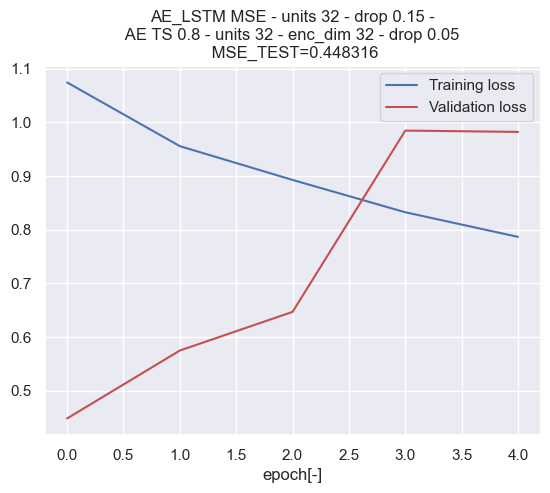

Save model:  data/mdl_predict_autoenc_lstm


INFO:tensorflow:Assets written to: data/mdl_predict_autoenc_lstm/assets


INFO:tensorflow:Assets written to: data/mdl_predict_autoenc_lstm/assets


In [145]:
#NB_TRY = 50
#STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)
EPOCHS = 5#30
patience = 0#10
#dropout_rate = 0.25#0.1
#n_units = 128#32
#reg = L1L2(l1=0.0001, l2=0.0001)
seed = 1
mse_curr_min = None
if MODE_TRAIN_PREDICTOR:
    for n_units in [32]: #[32, 64, 128]: #[128]: #
        for dropout_rate in  [0.15]: #[0.05, 0.15, 0.25]: #[0.1]:

            tf.keras.backend.clear_session()
            np.random.seed(seed)
            random.seed(seed)
            tf.random.set_seed(seed)
            optim = tf.keras.optimizers.legacy.Adam()
            if patience is not None:
                es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                                verbose=1, patience=patience,
                                                restore_best_weights=True)
            # create model
            multi_step_model = tf.keras.models.Sequential()
            multi_step_model.add(
                tf.keras.layers.LSTM(
                    n_units,
                    return_sequences=False,
                    input_shape=X_train_.shape[-2:],
                    #kernel_regularizer=reg,
                    #bias_regularizer=reg,
                )
            )
            multi_step_model.add(tf.keras.layers.LayerNormalization())
            multi_step_model.add(tf.keras.layers.Dropout(dropout_rate))
            #multi_step_model.add(tf.keras.layers.BatchNormalization())
            multi_step_model.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
            # compile
            multi_step_model.compile(optimizer=optim, loss='mse')
            # fitting
            if patience == 0:
                multi_step_history = multi_step_model.fit(
                    X_train_, y_train_sca, epochs=EPOCHS,
                    batch_size=BATCH_SIZE, 
                    validation_data=(X_test_, y_test_sca), 
                    verbose=1,
                )
            else:
                multi_step_history = multi_step_model.fit(
                    X_train_, y_train_sca, epochs=EPOCHS,
                    batch_size=BATCH_SIZE, 
                    validation_data=(X_test_, y_test_sca), 
                    verbose=1, 
                    callbacks=[es],
                )
            # eval
            mse_curr = np.min(multi_step_history.history['val_loss'])
            print("MSE TEST : ", mse_curr)

            # plot MSE
            name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
            plot_train_history(
                multi_step_history,
                f"AE_LSTM MSE - units {n_units} - drop {dropout_rate} -\n AE {name_plt} \n MSE_TEST={mse_curr:2f}",
                saveFolder="data",
            )

            # save the best
            if mse_curr_min == None:
                mse_curr_min = mse_curr
                n_units_min = n_units
                dropout_rate_min = dropout_rate

                print("Save model: ", path_mdl_predict_autoenc_lstm)
                multi_step_model.save(path_mdl_predict_autoenc_lstm)
            else:
                if mse_curr < mse_curr_min:
                    mse_curr_min = mse_curr
                    n_units_min = n_units
                    dropout_rate_min = dropout_rate
                    print("Save model: ", path_mdl_predict_autoenc_lstm)
                    multi_step_model.save(path_mdl_predict_autoenc_lstm)
    
    n_units = n_units_min#32
    dropout_rate = dropout_rate_min #0.25
    mse_curr = mse_curr_min

else:
    
    print("Load model: ", path_mdl_predict_autoenc_lstm)
    multi_step_model = tf.keras.models.load_model(path_mdl_predict_autoenc_lstm)
    n_units = multi_step_model.layers[0].units#32
    dropout_rate = multi_step_model.layers[2].rate#0.25
    print(multi_step_model.summary())

In [146]:
np.min(y_train)

0.925613296000411

In [147]:
np.max(y_train)

1.0749270774292548

#### Results

Save mdl

In [148]:
X_train_.shape

(50831, 72, 19)

Predict

In [149]:
# _train_sca -> unscaler -> _train -> multiply by  Close price last lag
# predict
y_train_pred = multi_step_model.predict(X_train_)
# unscale
#y_train_pred_unscaled = scaler_y.inverse_transform(y_train_pred.reshape(-1,y_train_pred.shape[-1])).reshape(y_train_pred.shape)
y_train_pred_unscaled = scaler_y.inverse_transform(
    y_train_pred.ravel().reshape(-1, 1)).reshape(y_train_pred.shape)
#  multiply by  Close price last lag
y_train_pred_raw = y_train_pred_unscaled * X_train_raw[:,-1, 0][:, np.newaxis]
# predict
y_test_pred = multi_step_model.predict(X_test_)
# unscale
y_test_pred_unscaled = scaler_y.inverse_transform(
    y_test_pred.ravel().reshape(-1, 1)).reshape(y_test_pred.shape)
#  multiply by  Close price last lag
y_test_pred_raw = y_test_pred_unscaled * X_test_raw[:,-1, 0][:, np.newaxis]

396/396 [==============================] - 4s 11ms/step


Plots

In [150]:
print(y_train_raw[0::FUTURE_TARGET,:].ravel().shape)
print(y_train_pred_raw[0::FUTURE_TARGET,:].ravel().shape)

(50835,)
(50835,)


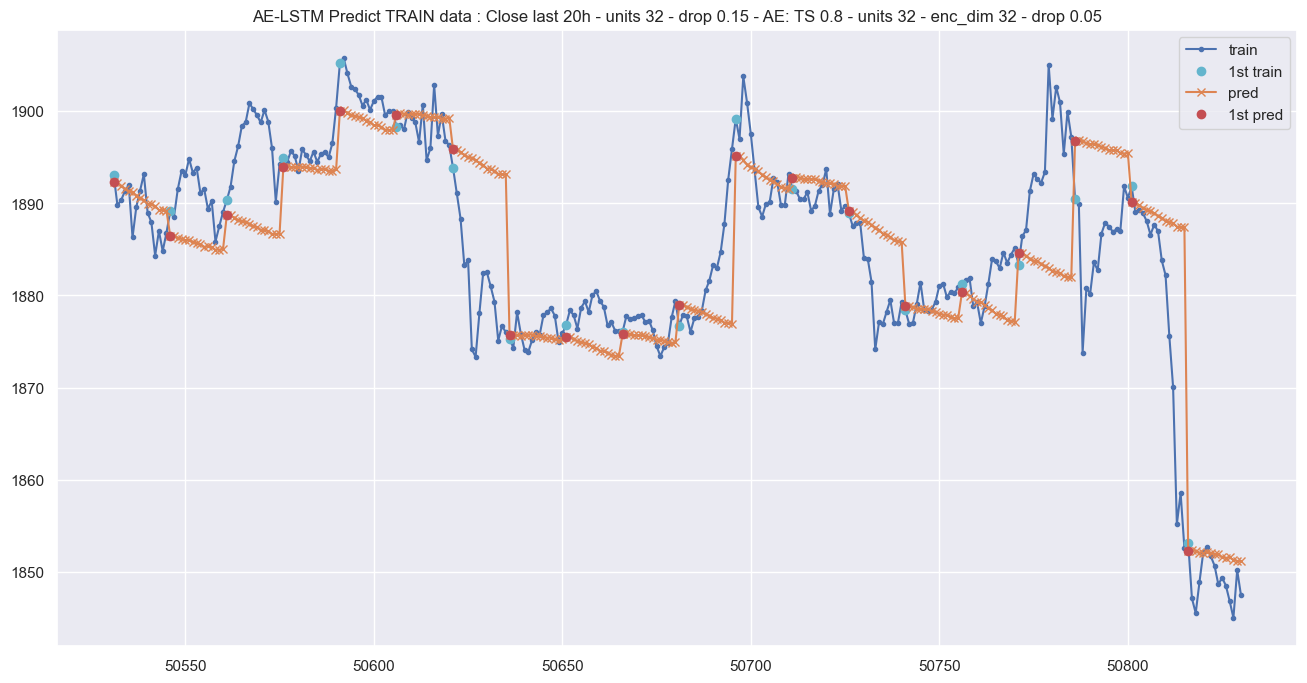

In [151]:
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
fig = plt.figure(figsize=(16, 8))
plt.title(f"AE-LSTM Predict TRAIN data : Close last 20h - units {n_units} - drop {dropout_rate} - AE: {name_plt}")
nb_pred = 20
nb_points = nb_pred*FUTURE_TARGET

x_axis = np.array(range(y_train_raw.shape[0]))
x_axis_1 =  np.flip(np.array(range(y_train_raw.shape[0]-FUTURE_TARGET,0, -FUTURE_TARGET)))
y_train_raw_1 = y_train_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
y_train_pred_raw_1 = y_train_pred_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
plt.plot(x_axis[-nb_points:], y_train_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], '.-', label="train")
plt.plot(x_axis_1[-nb_pred:], y_train_raw_1[-nb_pred:], 'oc', label ='1st train')
plt.plot(x_axis[-nb_points:], y_train_pred_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], 'x-', label="pred")
plt.plot(x_axis_1[-nb_pred:], y_train_pred_raw_1[-nb_pred:], 'or', label ='1st pred')
plt.legend(loc='upper right')
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE pred TRAIN - units {n_units} - drop {dropout_rate} - AE {name_plt}.jpg")
)

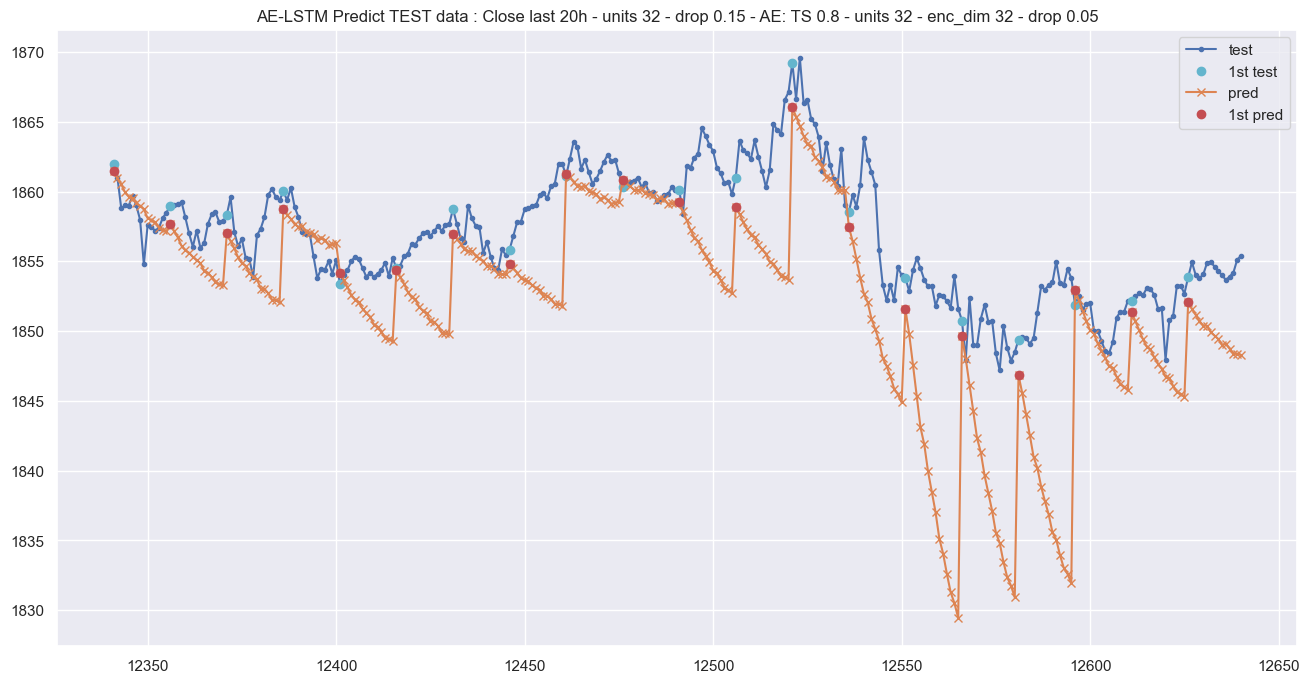

In [152]:
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
fig = plt.figure(figsize=(16, 8))
plt.title(f"AE-LSTM Predict TEST data : Close last 20h - units {n_units} - drop {dropout_rate} - AE: {name_plt}")
nb_pred = 20
nb_points = nb_pred*FUTURE_TARGET

x_axis = np.array(range(y_test_raw.shape[0]))
x_axis_1 =  np.flip(np.array(range(y_test_raw.shape[0]-FUTURE_TARGET,0, -FUTURE_TARGET)))
y_test_raw_1 = y_test_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
y_test_pred_raw_1 = y_test_pred_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
plt.plot(x_axis[-nb_points:], y_test_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], '.-', label="test")
plt.plot(x_axis_1[-nb_pred:], y_test_raw_1[-nb_pred:], 'oc', label ='1st test')
plt.plot(x_axis[-nb_points:], y_test_pred_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], 'x-', label="pred")
plt.plot(x_axis_1[-nb_pred:], y_test_pred_raw_1[-nb_pred:], 'or', label ='1st pred')
plt.legend(loc='upper right')
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE pred TEST - units {n_units} - drop {dropout_rate} - AE {name_plt}.jpg")
)

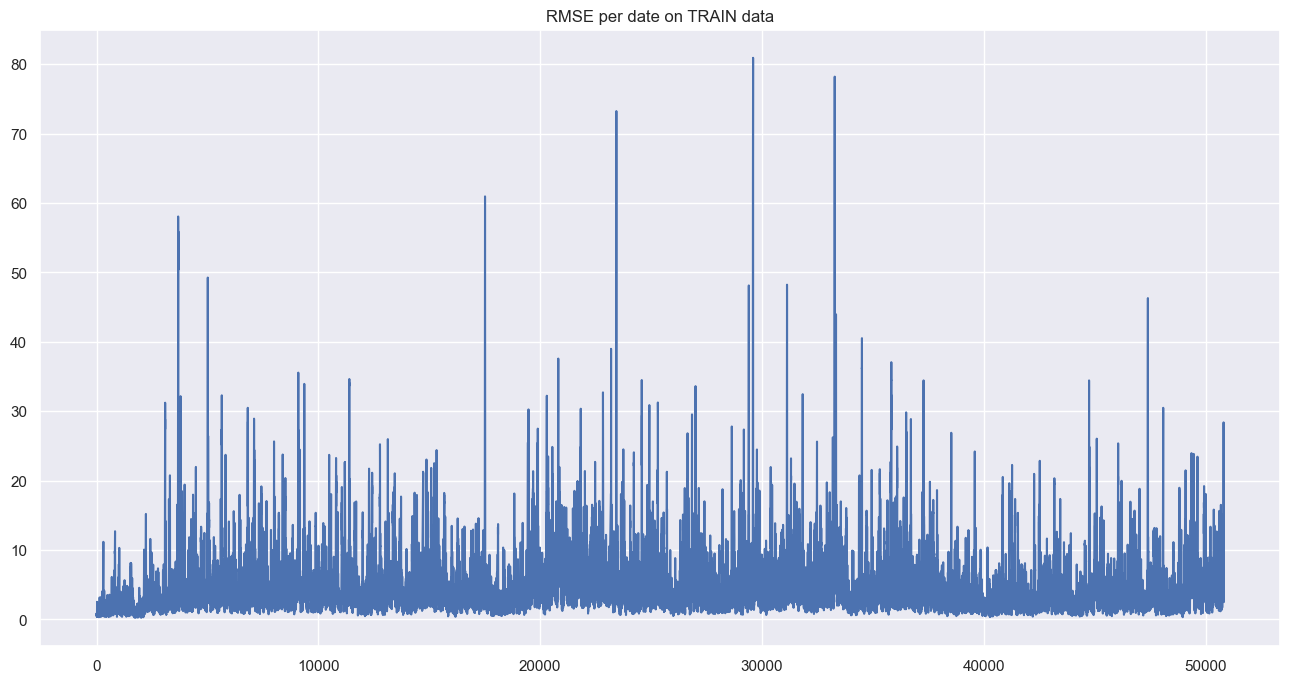

In [153]:
arr_mse_train = np.zeros((y_train_raw.shape[0]))
for i_date in range(y_train_raw.shape[0]):
    arr_mse_train[i_date] = mean_squared_error(
        y_train_raw[i_date], 
        y_train_pred_raw[i_date], 
        squared=False,
    )
fig = plt.figure(figsize=(16, 8))
plt.title("RMSE per date on TRAIN data")
plt.plot(arr_mse_train, label="mse")

Text(0.5, 1.0, 'Distrib. RMSE on TRAIN')

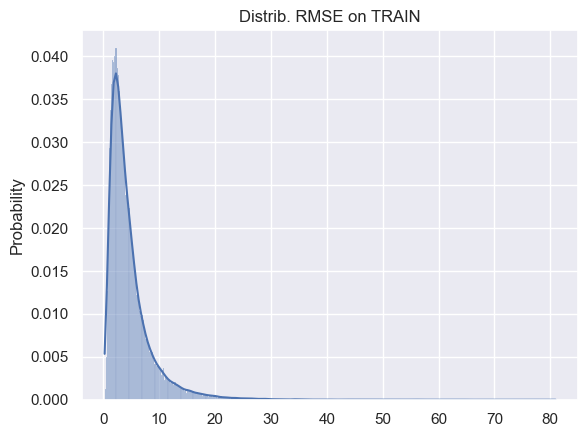

In [154]:
sns.histplot(x=arr_mse_train, stat="probability", kde=True)
fig = plt.gcf()
plt.title("Distrib. RMSE on TRAIN")

Text(0.5, 1.0, 'RMSE on TRAIN: mean= 4.75')

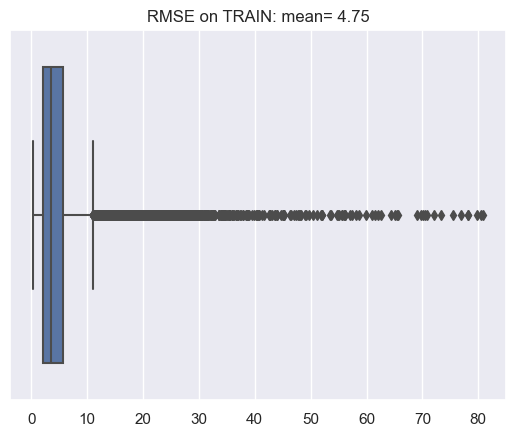

In [155]:

sns.boxplot(x=arr_mse_train)
fig = plt.gcf()
plt.title(f"RMSE on TRAIN: mean= {np.mean(arr_mse_train):.2f}")

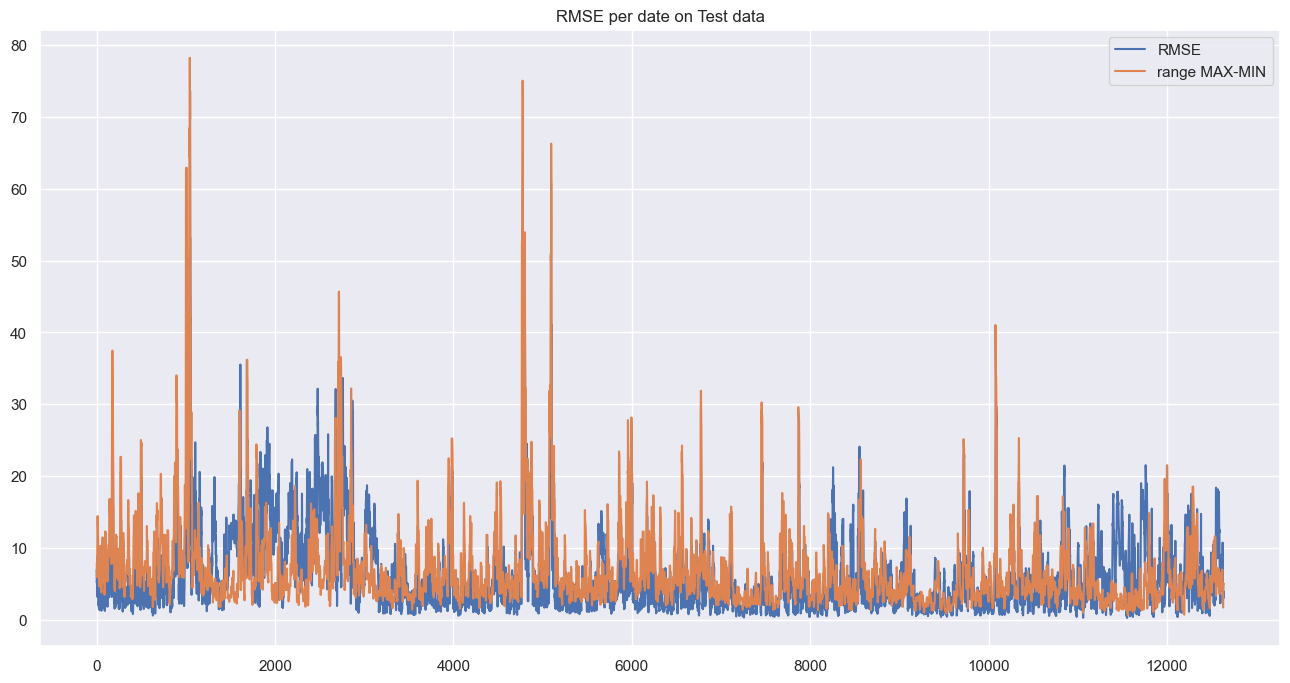

In [156]:
arr_mse = np.zeros((y_test_raw.shape[0]))
arr_range = np.zeros((y_test_raw.shape[0]))
for i_date in range(y_test_raw.shape[0]):
    arr_mse[i_date] = mean_squared_error(
        y_test_raw[i_date], 
        y_test_pred_raw[i_date],
        squared=False,
    )
    arr_range[i_date] = np.max(y_test_raw[i_date]) - np.min(y_test_raw[i_date])
fig = plt.figure(figsize=(16, 8))
plt.title("RMSE per date on Test data")
plt.plot(arr_mse, label="RMSE")
plt.plot(arr_range, label="range MAX-MIN")
plt.legend(loc='upper right')

In [157]:
np.mean(arr_range)

7.127811090894709

<AxesSubplot: ylabel='Probability'>

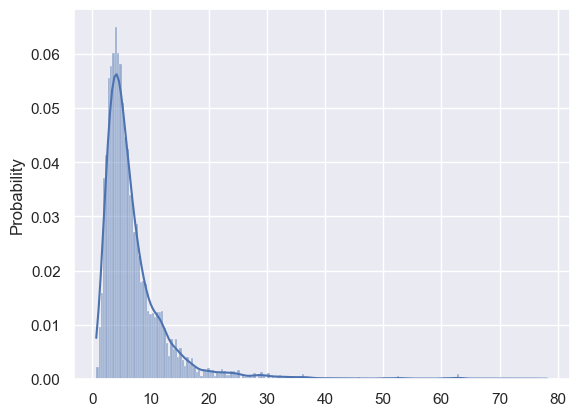

In [158]:
sns.histplot(x=arr_range,  stat="probability", kde=True)

In [159]:
np.mean(3*np.sqrt(np.var(y_test_raw, axis=1)))

6.32171020293997

<AxesSubplot: ylabel='Probability'>

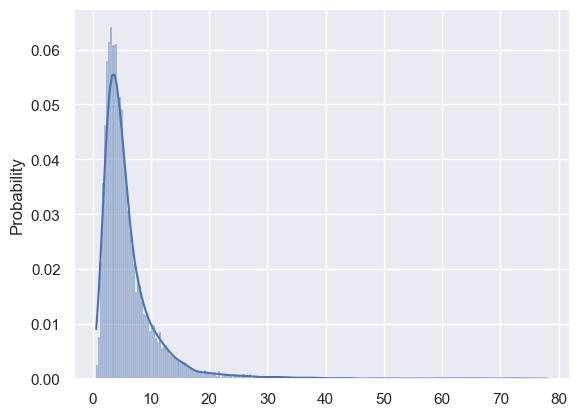

In [160]:
sns.histplot(x=3*np.sqrt(np.var(y_test_raw, axis=1)),  stat="probability", kde=True)

Text(0.5, 1.0, 'probability of RSME on each sequence')

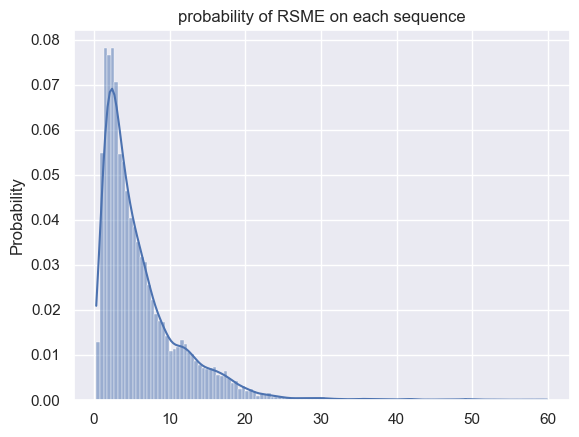

In [161]:
sns.histplot(x=arr_mse,  stat="probability", kde=True)
plt.title("probability of RSME on each sequence")

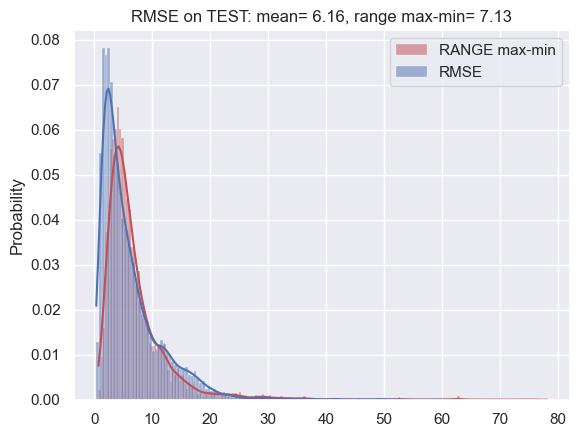

In [162]:
ax = sns.histplot(x=arr_range,  stat="probability", kde=True, label="RANGE max-min", color="r")
sns.histplot(x=arr_mse,  stat="probability", kde=True, label="RMSE", ax=ax)
plt.title(f"RMSE on TEST: mean= {np.mean(arr_mse):.2f}, range max-min= {np.mean(arr_range):.2f}")
plt.legend(loc='upper right')

Text(0.5, 1.0, 'RMSE on TEST: mean= 6.16')

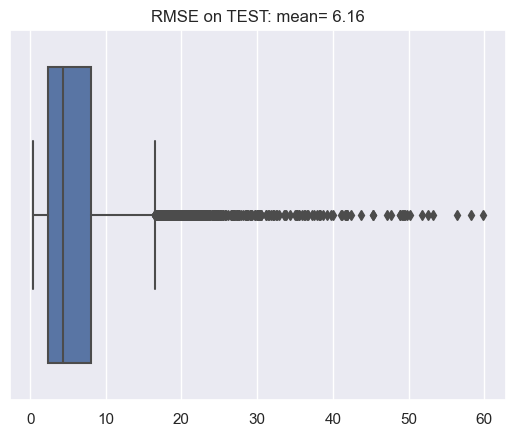

In [163]:
sns.boxplot(x=arr_mse)
fig = plt.gcf()
plt.title(f"RMSE on TEST: mean= {np.mean(arr_mse):.2f}")

In [164]:
print(y_test_raw[-3,:])
print(y_test_pred_raw[-3,:])

[1854.29 1854.01 1853.66 1853.91 1854.2  1855.12 1855.4  1855.57 1857.24
 1858.16 1858.28 1858.74 1856.9  1857.28 1857.13]
[1854.25083215 1853.99237896 1853.78245484 1853.58767532 1853.54036225
 1853.69291375 1853.43733472 1853.37852501 1853.30136491 1853.06402573
 1853.30379689 1853.13212118 1852.89820889 1852.97238429 1853.01737592]


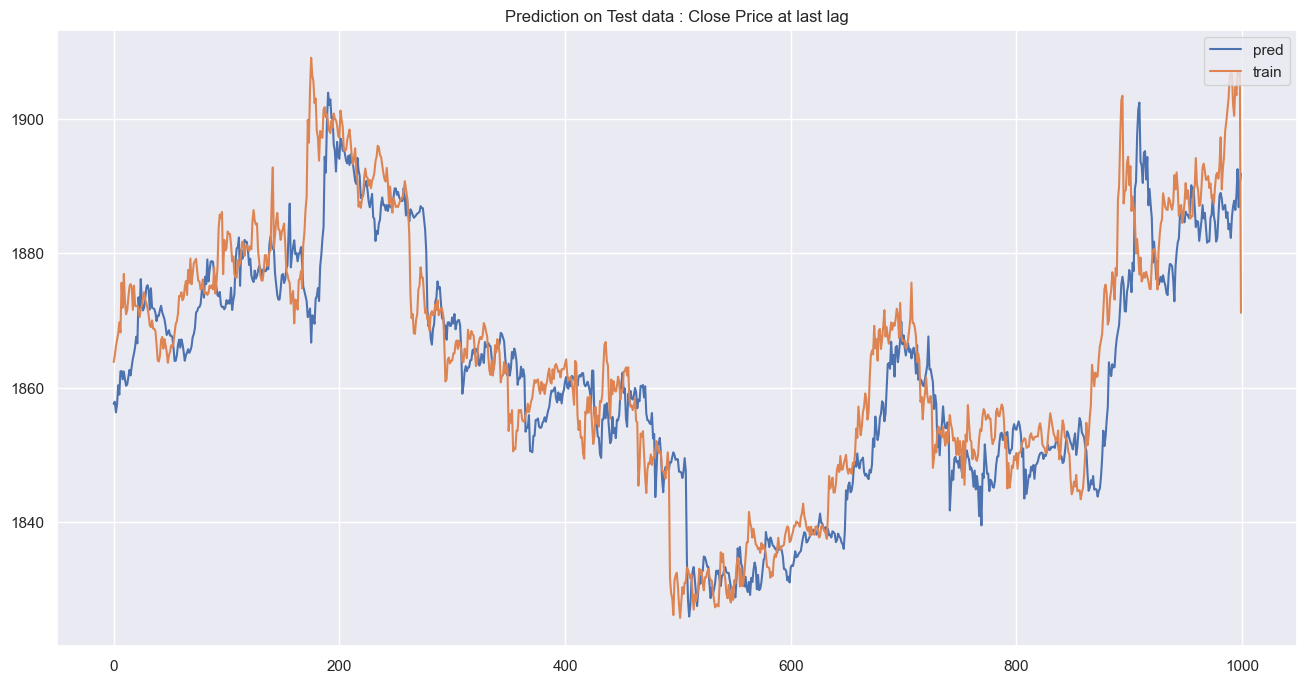

In [165]:
fig = plt.figure(figsize=(16, 8))
plt.title("Prediction on Test data : Close Price at last lag")
plt.plot(y_test_pred_raw[:1000,-1], label="pred")
plt.plot(y_test_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

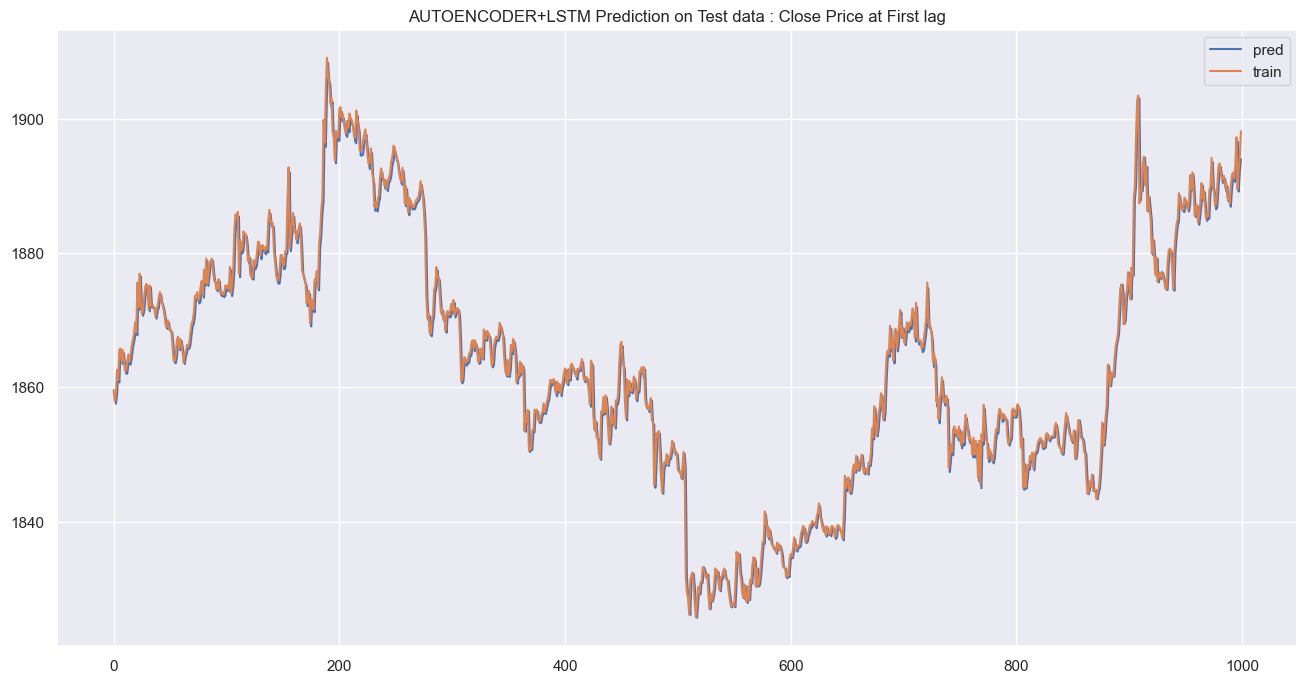

In [166]:
fig = plt.figure(figsize=(16, 8))
plt.title("AUTOENCODER+LSTM Prediction on Test data : Close Price at First lag")
plt.plot(y_test_pred_raw[:1000, 0], label="pred")
plt.plot(y_test_raw[:1000, 0], label="train")
plt.legend(loc='upper right')

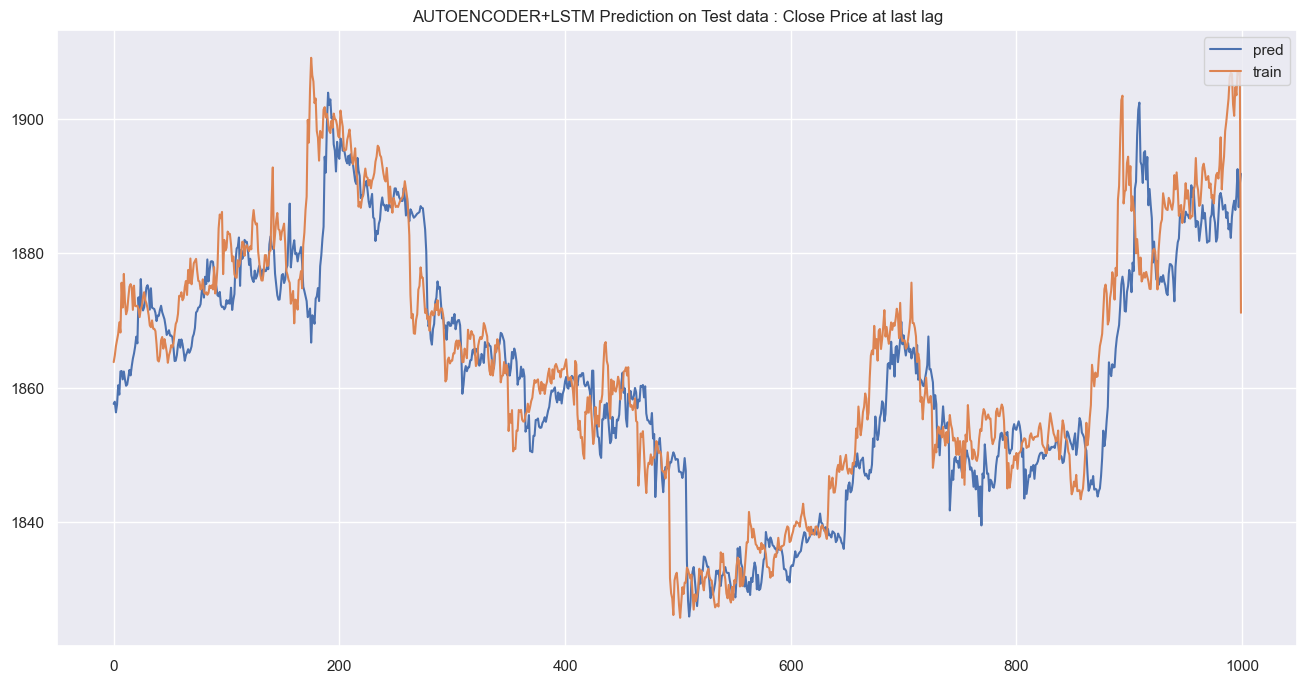

In [167]:

fig = plt.figure(figsize=(16, 8))
plt.title("AUTOENCODER+LSTM Prediction on Test data : Close Price at last lag")
plt.plot(y_test_pred_raw[:1000,-1], label="pred")
plt.plot(y_test_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

## Compare

## Predict last prediction

In [168]:
X_test_sca.shape

(12641, 72, 104)

In [169]:
df_feat["Close_ETH"].iloc[-1]

1856.81

In [170]:
df_feat["Close_ETH"].iloc[-1]

1856.81

In [171]:
len(list_i_enc_select)

15

In [172]:
# reload MDLS
#multi_step_model = tf.keras.models.load_model(path_mdl_predict_autoenc_lstm)
#encoder_model = tf.keras.models.load_model(path_mdl_encoder)
print("[batch, lags, features]")
X_last_raw = df_feat[list_col_select].iloc[-PAST_HISTORY:].values[np.newaxis,:]
X_last = X_last_raw.copy()
#list(np.array(list_col_select)[i_col_price_dep])/ df_feat["Close_ETH"].iloc[-1]
print("X_last[0,:,0]:")
print(X_last[0,:,0])
# Scale by ETH price
X_last[:,:,i_col_price_dep] = X_last[:,:,i_col_price_dep] / df_feat["Close_ETH"].iloc[-1]
assert X_last[0,-1,0] == 1, "Scaling by ETH price is not good!"
print("X_last[0,:,0] after divide by price:")
print(X_last[0,:,0])
print(X_last.shape)
# Standardize
X_last_sca = scaler.transform(X_last.reshape(-1,X_last.shape[-1])).reshape(X_last.shape)
print("X_last_sca[0,:,0]:")
print(X_last_sca[0,:,0])
print(X_last_sca.shape)
# Encode
X_last_encoded = encoder_model.predict(X_last_sca)
print("X_last_encoded[0,:,0]:")
print(X_last_encoded[0,:,0])
print(X_last_encoded.shape)
# Standardize encoded
X_last_encoded_sca = scaler_enc.transform(
    X_last_encoded.reshape(
        -1, 
        X_last_encoded.shape[-1]
    )
).reshape(X_last_encoded.shape)
print("X_last_encoded_sca[0,:,0]:")
print(X_last_encoded_sca[0,:,0])
print(X_last_encoded_sca.shape)
print("X_last_sca[0,0,0:4]:")
print(X_last_sca[0,0,0:4])
print("X_last_encoded_sca[0,0,:]:")
print(X_last_encoded_sca[0,0,:])
# Concatenate (auto selected encoded features)
X_last_ = np.concatenate([
        X_last_sca[:,:,0:4], 
        X_last_encoded_sca[:, :, np.array(list_i_enc_select)]
    ],
    axis=-1,
)
print("X_last_[0,0,:]:")
print(X_last_[0,0,:])
print(X_last_.shape)
# Predict
y_last_pred = multi_step_model.predict(X_last_)
print("y_last_pred (scaled):")
print(y_last_pred)
print(y_last_pred.shape)
# Unscale
#scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)
y_last_pred_unscaled = scaler_y.inverse_transform(y_last_pred.ravel().reshape(-1, 1)).reshape(y_last_pred.shape)
print("y_last_pred_unscaled:")
print(y_last_pred_unscaled)
print(y_last_pred_unscaled.shape)
# Multiply by price
y_last_pred_raw = y_last_pred_unscaled * df_feat["Close_ETH"].iloc[-1]
print("y_last_pred_raw:")
print(y_last_pred_raw)
print(y_last_pred_raw.shape)
nb_last_hour = 12
list_pred = list(y_last_pred_raw.squeeze()[-nb_last_hour:])
print("list_pred:")
print(list_pred)
print(len(list_pred))


[batch, lags, features]
X_last[0,:,0]:
[1848.48 1849.4  1849.55 1849.5  1849.1  1849.49 1851.33 1853.22 1852.97
 1853.3  1853.49 1854.99 1853.42 1853.29 1854.46 1853.8  1851.89 1852.54
 1851.55 1851.95 1852.01 1850.03 1850.02 1849.31 1848.56 1848.4  1849.2
 1850.97 1851.38 1851.38 1852.17 1852.19 1852.49 1852.7  1852.56 1853.08
 1853.   1852.61 1851.61 1851.65 1847.94 1850.78 1851.06 1853.25 1853.27
 1852.69 1853.87 1854.94 1854.01 1853.8  1854.06 1854.89 1854.94 1854.63
 1854.29 1854.01 1853.66 1853.91 1854.2  1855.12 1855.4  1855.57 1857.24
 1858.16 1858.28 1858.74 1856.9  1857.28 1857.13 1857.14 1856.81 1856.81]
X_last[0,:,0] after divide by price:
[0.99551381 0.99600928 0.99609007 0.99606314 0.99584772 0.99605775
 0.9970487  0.99806658 0.99793194 0.99810966 0.99821199 0.99901982
 0.99817429 0.99810428 0.99873439 0.99837894 0.99735029 0.99770036
 0.99716718 0.99738261 0.99741492 0.99634858 0.99634319 0.99596081
 0.9955569  0.99547073 0.99590157 0.99685482 0.99707563 0.99707563
 0.99

In [173]:
X_last_encoded_sca.shape

(1, 72, 32)

In [174]:
list_i_enc_select

[0, 1, 2, 5, 6, 7, 8, 9, 10, 15, 20, 24, 26, 29, 30]

In [175]:
X_last_encoded_sca[:,:, np.array(list_i_enc_select)].shape

(1, 72, 15)

In [176]:
X_last_sca[:,:,0:4].shape

(1, 72, 4)

In [177]:
X_train_.shape

(50831, 72, 19)

In [178]:
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
63641  1691623500000   1856.91   1857.73  1856.90    1857.28    260.1975   
63642  1691623800000   1857.29   1857.29  1856.97    1857.13    162.4812   
63643  1691624100000   1857.13   1857.14  1856.94    1857.14    160.6070   
63644  1691624400000   1857.13   1857.14  1856.80    1856.81    152.5477   
63645  1691624700000   1856.80   1856.81  1856.80    1856.81     15.5371   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1751.001785        1750.44207   
1      2023-01-01 00:05:00       1751.001785        1750.44207   
2      2023-01-01 00:10:00       1751.001785        1750.44207   
3      2023-01-01 00:15:00       1751.001785        1750.44207   
4      2023-01-01 00:20:00       1751.001785        1750.44207   
...                    ...               ...               ...   
63641  2023-08-09 23:25:00       1850.140000        1850.64000   
63642  2023-08-09 23:30:00       1849.990000        1850.64000   
63643  2023-08-09 23:35:00       1850.015000        1850.64000   
63644  2023-08-09 23:40:00       1850.195000        1850.64000   
63645  2023-08-09 23:45:00       1850.195000        1850.64000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...         0.0            0.0           0.0   
1            1194.710  ...         0.0            0.0           0.0   
2            1194.710  ...         0.0            0.0           0.0   
3            1194.710  ...         0.0            0.0           0.0   
4            1194.710  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
63641        1854.765  ...         NaN            NaN           NaN   
63642        1854.905  ...         NaN            NaN           NaN   
63643        1855.425  ...         NaN            NaN           NaN   
63644        1855.425  ...         NaN            NaN           NaN   
63645        1855.620  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
63641               NaN         0.0               NaN         0.0      0.0   
63642               NaN         0.0               NaN         0.0      0.0   
63643               NaN         0.0               NaN         0.0      0.0   
63644               NaN         0.0               NaN         0.0      0.0   
63645               NaN         0.0               NaN         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
63641                  NaN  False  
63642                  NaN  False  
63643                  NaN  False  
63644                  NaN  False  
63645                  NaN  False  

[63646 rows x 136 columns]

In [179]:
mode_lstm_simple = False
if mode_lstm_simple:
    # TODO : finish pred
    X_last_raw = df_feat[list_col_select].iloc[-PAST_HISTORY:].values[np.newaxis,:]
    # divided price
    X_last = X_last_raw / df_feat["Close_ETH"].iloc[-1]
    # scaler
    X_last_sca = scaler.transform(X_last.reshape(-1,X_last.shape[-1])).reshape(X_last.shape)
    y_last_pred = multi_step_model_1.predict(X_last_sca)
    y_last_pred_unscaled = scaler_y.inverse_transform(y_last_pred.reshape(-1,y_last_pred.shape[-1])).reshape(y_last_pred.shape)
    y_last_pred_raw = y_last_pred_unscaled * df_feat["Close_ETH"].iloc[-1]
    print(y_last_pred_raw)
    nb_last_pred = 12
    list_pred = list(y_last_pred_raw.squeeze()[-nb_last_pred:])
    print(list_pred)

In [180]:
y_last_pred_unscaled

array([[1.0002091, 1.0004447, 1.0007639, 1.0010942, 1.0015644, 1.001907 ,
        1.0021794, 1.002456 , 1.0027462, 1.0029395, 1.0032687, 1.003504 ,
        1.0036358, 1.0038159, 1.0040181]], dtype=float32)

In [181]:
df_feat["Close_ETH"].iloc[-1]

1856.81

In [182]:
y_last_pred_raw

array([[1857.1984, 1857.6357, 1858.2285, 1858.8418, 1859.7148, 1860.351 ,
        1860.8568, 1861.3702, 1861.9093, 1862.2681, 1862.8794, 1863.3164,
        1863.561 , 1863.8954, 1864.2709]], dtype=float32)

In [183]:
y_last_pred_raw.shape

(1, 15)

## Save last prediction

In [184]:
list_pred

[1858.8418,
 1859.7148,
 1860.351,
 1860.8568,
 1861.3702,
 1861.9093,
 1862.2681,
 1862.8794,
 1863.3164,
 1863.561,
 1863.8954,
 1864.2709]

In [185]:
save_list(list_pred, path_save_pred_vals)

In [186]:
list_pred_reload = load_list(path_save_pred_vals)
from numpy.testing import assert_almost_equal
assert_almost_equal(list_pred_reload,list_pred, decimal=3)
#"Reload prediction list not good!"

In [187]:
list_pred_reload

[1858.8418,
 1859.7148,
 1860.351,
 1860.8568,
 1861.3702,
 1861.9093,
 1862.2681,
 1862.8794,
 1863.3164,
 1863.561,
 1863.8954,
 1864.2709]